In [1]:
import requests
import pandas as pd 
import numpy as np 
import warnings
warnings.filterwarnings("ignore")
np.random.seed(1)
from shapefinder import Shape,finder
from pmdarima.arima import auto_arima
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt 
from sklearn.metrics import mean_squared_error
import math 
from dtaidistance import dtw
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense,LSTM,Bidirectional,Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from pmdarima.arima import auto_arima
import os
from cycler import cycler

In [2]:
# Plot parameters 
plot_params = {"text.usetex":True,"font.family":"serif","font.size":20,"xtick.labelsize":20,"ytick.labelsize":20,"axes.labelsize":20,"figure.titlesize":20,"figure.figsize":(8,5),"axes.prop_cycle":cycler(color=['black','rosybrown','gray','indianred','red','maroon','silver',])}
plt.rcParams.update(plot_params)

In [3]:
### Define out paths ------
home = '/Users/hannahfrank/'
if not os.path.exists(os.path.join(home,'desktop/Views_competition_out')):
    os.makedirs(os.path.join(home,'desktop/Views_competition_out'))

out_paths = {"plots": os.path.join(home,'desktop/Views_competition_out/plots'),
    "data": os.path.join(home,'desktop/Views_competition_out/data'),
    "analysis": os.path.join(home,'desktop/Views_competition_out/analysis'),}

for key, val in out_paths.items():
    if not os.path.exists(val):
        os.makedirs(val)

In [4]:
df_list_preds={"fatalities001_2022_00_t01":1,
         "fatalities001_2022_01_t01":2,
         "fatalities001_2022_02_t01":3,
         "fatalities001_2022_03_t01":4,
         "fatalities001_2022_04_t01":5,
         "fatalities001_2022_05_t01":6,
         "fatalities001_2022_06_t01":7,
         "fatalities001_2022_07_t01":8,
         "fatalities001_2022_08_t01":9,
         "fatalities001_2022_09_t01":10,
         "fatalities001_2022_10_t01":11,
         "fatalities001_2022_11_t01":12,
         "fatalities001_2023_00_t01":1,
         "fatalities001_2023_01_t01":2,
         "fatalities001_2023_02_t01":3,
         "fatalities001_2023_03_t01":4,
         #"fatalities002_2023_04_t01":5,
         #"fatalities001_2023_05_t01":6,
         #"fatalities001_2023_06_t01":7,
         #"fatalities001_2023_07_t01":8,
         #"fatalities001_2023_08_t01":9,
         #"fatalities001_2023_09_t01":10,
         #"fatalities001_2023_10_t01":11,
         #"fatalities001_2023_11_t01":12
        }

In [5]:
df_all=pd.DataFrame()
for i in range(len(df_list_preds)):
    print(f'https://api.viewsforecasting.org/{list(df_list_preds.keys())[i]}/cm/sb')
    response = requests.get(f'https://api.viewsforecasting.org/{list(df_list_preds.keys())[i]}/cm/sb')
    json_data = response.json()
    df=pd.DataFrame(json_data["data"])
    df=df[['country_id','month_id','month','sc_cm_sb_main']]
    df=df.loc[df["month"]==list(df_list_preds.values())[i]]
    df_all = pd.concat([df_all, df])
    df_all=df_all.reset_index(drop=True)
cc_sort=df_all.country_id.unique()
cc_sort.sort()
df_preds = df_all.pivot(index="month_id",columns='country_id', values='sc_cm_sb_main')
df_preds

https://api.viewsforecasting.org/fatalities001_2022_00_t01/cm/sb
https://api.viewsforecasting.org/fatalities001_2022_01_t01/cm/sb
https://api.viewsforecasting.org/fatalities001_2022_02_t01/cm/sb
https://api.viewsforecasting.org/fatalities001_2022_03_t01/cm/sb
https://api.viewsforecasting.org/fatalities001_2022_04_t01/cm/sb
https://api.viewsforecasting.org/fatalities001_2022_05_t01/cm/sb
https://api.viewsforecasting.org/fatalities001_2022_06_t01/cm/sb
https://api.viewsforecasting.org/fatalities001_2022_07_t01/cm/sb
https://api.viewsforecasting.org/fatalities001_2022_08_t01/cm/sb
https://api.viewsforecasting.org/fatalities001_2022_09_t01/cm/sb
https://api.viewsforecasting.org/fatalities001_2022_10_t01/cm/sb
https://api.viewsforecasting.org/fatalities001_2022_11_t01/cm/sb
https://api.viewsforecasting.org/fatalities001_2023_00_t01/cm/sb
https://api.viewsforecasting.org/fatalities001_2023_01_t01/cm/sb
https://api.viewsforecasting.org/fatalities001_2023_02_t01/cm/sb
https://api.viewsforecast

country_id     1       2       3       4       5       6       7       8    \
month_id                                                                     
505         0.0066  0.0072  0.0069  0.0154  0.0192  0.0188  0.0072  0.0073   
506         0.0051  0.0052  0.0103  0.2905  0.0043  0.0042  0.0062  0.0059   
507         0.0050  0.0051  0.0102  0.6689  0.0042  0.0042  0.0065  0.0063   
508         0.0058  0.0050  0.0044  0.8708  0.0042  0.0042  0.0065  0.0067   
509         0.0264  0.0053  0.0043  0.6149  0.0042  0.0041  0.0073  0.0086   
510         0.0135  0.0053  0.0043  0.4890  0.0042  0.0041  0.0069  0.0077   
511         0.0105  0.0059  0.0053  0.4458  0.0043  0.0042  0.0080  0.0086   
512         0.0095  0.0057  0.0101  0.3081  0.0042  0.0042  0.0071  0.0072   
513         0.0114  0.0062  0.0157  0.3085  0.0052  0.0052  0.0073  0.0084   
514         0.0097  0.0062  0.0111  0.2841  0.0052  0.0052  0.0071  0.0091   
515         0.0101  0.0062  0.0120  0.2367  0.0053  0.0054  0.0069  0.0091   
516         0.0105  0.0064  0.0062  0.2208  0.0062  0.0054  0.0072  0.0091   
517         0.0099  0.0062  0.0109  0.2771  0.0055  0.0054  0.0069  0.0079   
518         0.0158  0.0074  0.0214  0.2847  0.0208  0.0193  0.0077  0.0092   
519         0.0157  0.0074  0.0072  0.1667  0.0199  0.0192  0.0076  0.0092   
520         0.0158  0.0075  0.0072  0.1130  0.0196  0.0190  0.0075  0.0092   

country_id     9       10   ...     232     233     234     235     237  \
month_id                    ...                                           
505         0.3841  0.0075  ...  0.4080  0.0068  0.0064  0.0403  1.2568   
506         0.2752  0.0058  ...  0.0058  0.0049  0.0938  0.9349  2.1421   
507         0.2815  0.0087  ...  0.0059  0.0049  0.0643  0.6613  2.2285   
508         1.1124  0.0071  ...  0.0061  0.0050  0.0617  1.4478  2.3037   
509         1.4744  0.0064  ...  0.0062  0.0050  0.0485  1.0104  1.8034   
510         1.3030  0.0058  ...  0.0060  0.0050  0.0448  0.9347  1.3595   
511         1.7512  0.0063  ...  0.0058  0.0049  0.0439  0.6796  1.0760   
512         1.6593  0.0058  ...  0.0058  0.0049  0.0405  0.5733  1.4657   
513         1.3001  0.0075  ...  0.0062  0.0052  0.0487  0.4870  1.4176   
514         1.2384  0.0071  ...  0.0062  0.0052  0.0476  0.5117  0.9896   
515         1.3136  0.0082  ...  0.0062  0.0052  0.0460  0.6889  0.7649   
516         1.1026  0.0075  ...  0.0062  0.0052  0.0472  0.4853  0.5581   
517         0.7564  0.0071  ...  0.0061  0.0051  0.0127  1.3448  1.0771   
518         0.7197  0.0074  ...  0.4078  0.0067  0.0076  0.8178  1.7932   
519         0.7045  0.0074  ...  0.4078  0.0067  0.0122  0.9624  1.6150   
520         1.0918  0.0074  ...  0.4078  0.0067  0.0111  0.7340  0.8504   

country_id     242     243     244     245     246  
month_id                                            
505         1.2067  0.1457  0.0153  1.0401  1.6642  
506         0.9787  0.8862  0.0118  1.5935  1.2076  
507         0.7891  0.6319  0.0183  1.4350  1.2588  
508         0.4762  0.5137  0.0224  1.2584  1.3386  
509         0.5452  1.0332  0.0204  0.9382  1.3042  
510         0.3709  0.6702  0.0199  0.8588  0.9274  
511         0.3409  0.5089  0.0169  0.6948  1.1634  
512         0.2667  0.4126  0.0167  0.6434  1.9857  
513         0.2463  0.2904  0.0184  1.0969  1.7808  
514         0.2714  0.2883  0.0178  1.4150  1.2087  
515         0.7917  0.2795  0.0179  1.3571  1.1258  
516         0.3910  0.2237  0.0174  1.6282  1.1241  
517         0.2847  0.2051  0.0206  1.4706  1.0259  
518         0.1994  0.1687  0.0155  1.4196  0.5840  
519         0.1732  0.1281  0.0149  1.2153  0.6706  
520         0.2089  0.6906  0.5474  1.0357  1.0659  

[16 rows x 191 columns]

In [6]:
df_list_input={"predictors_fatalities002_0000_00/cm":1,
         "predictors_fatalities002_0000_00/cm?page=2":2,
         "predictors_fatalities002_0000_00/cm?page=3":3,
         "predictors_fatalities002_0000_00/cm?page=4":4,
         "predictors_fatalities002_0000_00/cm?page=5":5,
         "predictors_fatalities002_0000_00/cm?page=6":6,
         "predictors_fatalities002_0000_00/cm?page=7":7,
         "predictors_fatalities002_0000_00/cm?page=8":8,
         "predictors_fatalities002_0000_00/cm?page=9":9,
         "predictors_fatalities002_0000_00/cm?page=10":10,
         "predictors_fatalities002_0000_00/cm?page=11":11,
         "predictors_fatalities002_0000_00/cm?page=12":12,
         "predictors_fatalities002_0000_00/cm?page=13":12,
         "predictors_fatalities002_0000_00/cm?page=14":1,
         "predictors_fatalities002_0000_00/cm?page=15":2,
         "predictors_fatalities002_0000_00/cm?page=16":3,
         "predictors_fatalities002_0000_00/cm?page=17":4,
         "predictors_fatalities002_0000_00/cm?page=18":5,
         "predictors_fatalities002_0000_00/cm?page=19":6,
         "predictors_fatalities002_0000_00/cm?page=20":7,
         "predictors_fatalities002_0000_00/cm?page=21":8,
         "predictors_fatalities002_0000_00/cm?page=22":9, 
         "predictors_fatalities002_0000_00/cm?page=23":10,
         "predictors_fatalities002_0000_00/cm?page=24":11,
         "predictors_fatalities002_0000_00/cm?page=25":12,
         "predictors_fatalities002_0000_00/cm?page=26":1,
         "predictors_fatalities002_0000_00/cm?page=27":2,
         "predictors_fatalities002_0000_00/cm?page=28":3,
         "predictors_fatalities002_0000_00/cm?page=29":4,
         "predictors_fatalities002_0000_00/cm?page=30":5,
         "predictors_fatalities002_0000_00/cm?page=31":6,
         "predictors_fatalities002_0000_00/cm?page=32":7,
         "predictors_fatalities002_0000_00/cm?page=33":8,
         "predictors_fatalities002_0000_00/cm?page=34":9,
         "predictors_fatalities002_0000_00/cm?page=35":10,
         "predictors_fatalities002_0000_00/cm?page=36":11,
         "predictors_fatalities002_0000_00/cm?page=37":12,
         "predictors_fatalities002_0000_00/cm?page=38":1,
         "predictors_fatalities002_0000_00/cm?page=39":2,
         "predictors_fatalities002_0000_00/cm?page=40":3,
         "predictors_fatalities002_0000_00/cm?page=41":4,
         "predictors_fatalities002_0000_00/cm?page=42":5,
         "predictors_fatalities002_0000_00/cm?page=43":6,
         "predictors_fatalities002_0000_00/cm?page=44":7,
         "predictors_fatalities002_0000_00/cm?page=45":8,
         "predictors_fatalities002_0000_00/cm?page=46":9,
         "predictors_fatalities002_0000_00/cm?page=47":10, 
         "predictors_fatalities002_0000_00/cm?page=48":11,
         "predictors_fatalities002_0000_00/cm?page=49":12,
         "predictors_fatalities002_0000_00/cm?page=50":1,
         "predictors_fatalities002_0000_00/cm?page=51":2,
         "predictors_fatalities002_0000_00/cm?page=52":3,
         "predictors_fatalities002_0000_00/cm?page=53":4,
         "predictors_fatalities002_0000_00/cm?page=54":5,
         "predictors_fatalities002_0000_00/cm?page=55":6,
         "predictors_fatalities002_0000_00/cm?page=56":7,
         "predictors_fatalities002_0000_00/cm?page=57":8,
         "predictors_fatalities002_0000_00/cm?page=58":9,
         "predictors_fatalities002_0000_00/cm?page=59":10,
         "predictors_fatalities002_0000_00/cm?page=60":11,
         "predictors_fatalities002_0000_00/cm?page=61":12,
         "predictors_fatalities002_0000_00/cm?page=62":1,
         "predictors_fatalities002_0000_00/cm?page=63":2,
         "predictors_fatalities002_0000_00/cm?page=64":3,
         "predictors_fatalities002_0000_00/cm?page=65":4,
         "predictors_fatalities002_0000_00/cm?page=66":5,
         "predictors_fatalities002_0000_00/cm?page=67":6,
         "predictors_fatalities002_0000_00/cm?page=68":7,
         "predictors_fatalities002_0000_00/cm?page=69":8,
         "predictors_fatalities002_0000_00/cm?page=70":9,
         "predictors_fatalities002_0000_00/cm?page=71":10,
         "predictors_fatalities002_0000_00/cm?page=72":11,
         "predictors_fatalities002_0000_00/cm?page=73":12,
         "predictors_fatalities002_0000_00/cm?page=74":1,
         "predictors_fatalities002_0000_00/cm?page=75":2,
         "predictors_fatalities002_0000_00/cm?page=76":3,
         "predictors_fatalities002_0000_00/cm?page=77":4,  
        }

In [7]:
df_input_t=pd.DataFrame()
for i in range(len(df_list_input)):
    print(f'https://api.viewsforecasting.org/{list(df_list_input.keys())[i]}')
    response = requests.get(f'https://api.viewsforecasting.org/{list(df_list_input.keys())[i]}')
    json_data = response.json()
    df=pd.DataFrame(json_data["data"])
    df=df[["country_id","month_id","ucdp_ged_sb_best_sum"]]
    df_input_t = pd.concat([df_input_t, df])
    df_input_t=df_input_t.reset_index(drop=True)


df_input_s = df_input_t[df_input_t['country_id'].isin(cc_sort)]
df_input = df_input_s.pivot(index="month_id",columns='country_id',values='ucdp_ged_sb_best_sum')
df_input=df_input[:-8]
df_input

https://api.viewsforecasting.org/predictors_fatalities002_0000_00/cm
https://api.viewsforecasting.org/predictors_fatalities002_0000_00/cm?page=2
https://api.viewsforecasting.org/predictors_fatalities002_0000_00/cm?page=3
https://api.viewsforecasting.org/predictors_fatalities002_0000_00/cm?page=4
https://api.viewsforecasting.org/predictors_fatalities002_0000_00/cm?page=5
https://api.viewsforecasting.org/predictors_fatalities002_0000_00/cm?page=6
https://api.viewsforecasting.org/predictors_fatalities002_0000_00/cm?page=7
https://api.viewsforecasting.org/predictors_fatalities002_0000_00/cm?page=8
https://api.viewsforecasting.org/predictors_fatalities002_0000_00/cm?page=9
https://api.viewsforecasting.org/predictors_fatalities002_0000_00/cm?page=10
https://api.viewsforecasting.org/predictors_fatalities002_0000_00/cm?page=11
https://api.viewsforecasting.org/predictors_fatalities002_0000_00/cm?page=12
https://api.viewsforecasting.org/predictors_fatalities002_0000_00/cm?page=13
https://api.vie

country_id  1    2    3    4    5    6    7    8    9    10   ...  232  233  \
month_id                                                      ...             
121         0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  NaN  NaN   
122         0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  NaN  NaN   
123         0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  NaN  NaN   
124         0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  NaN  NaN   
125         0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  NaN  NaN   
...         ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
516         0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
517         0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
518         0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  ...  0.0  0.0   
519         0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  6.0  0.0  ...  0.0  0.0   
520         0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   

country_id  234    235   237  242  243  244    245   246  
month_id                                                  
121         0.0    0.0   0.0  NaN  0.0  0.0    NaN   NaN  
122         0.0    5.0   0.0  NaN  0.0  0.0    NaN   NaN  
123         0.0  300.0   0.0  NaN  0.0  0.0    NaN   NaN  
124         0.0   53.0   0.0  NaN  0.0  0.0    NaN   NaN  
125         0.0   25.0   0.0  NaN  0.0  0.0    NaN   NaN  
...         ...    ...   ...  ...  ...  ...    ...   ...  
516         0.0   21.0   8.0  0.0  0.0  0.0    0.0   0.0  
517         0.0    0.0  21.0  0.0  0.0  0.0    0.0   0.0  
518         0.0    1.0   8.0  0.0  0.0  0.0    0.0   2.0  
519         0.0    0.0   0.0  0.0  1.0  6.0    0.0  10.0  
520         0.0    0.0   0.0  0.0  0.0  0.0  272.0   0.0  

[400 rows x 191 columns]

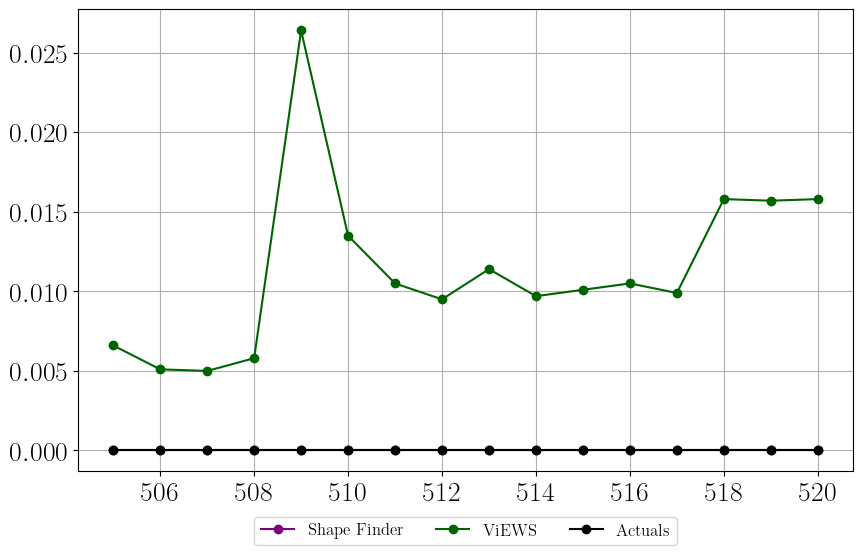

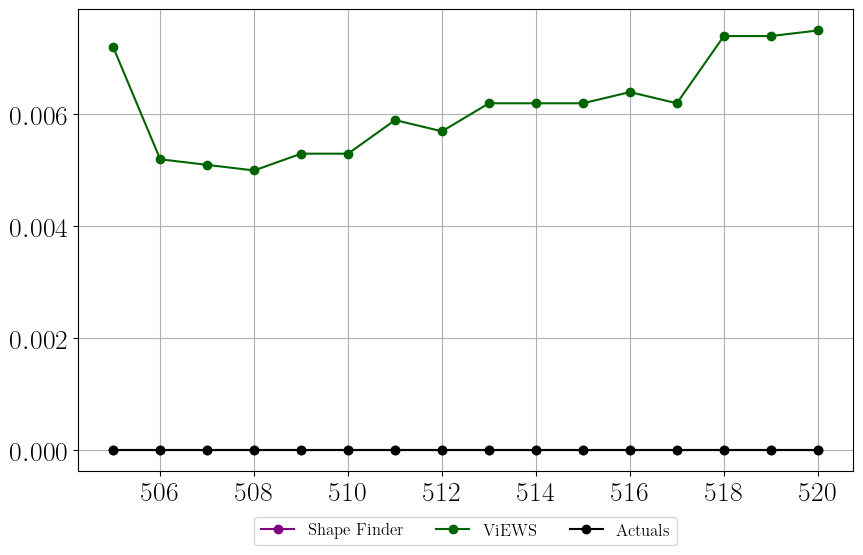

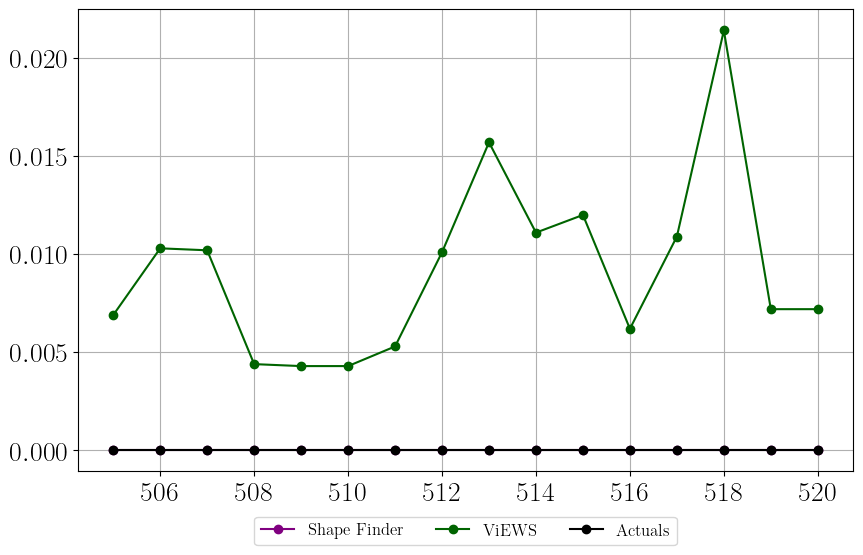

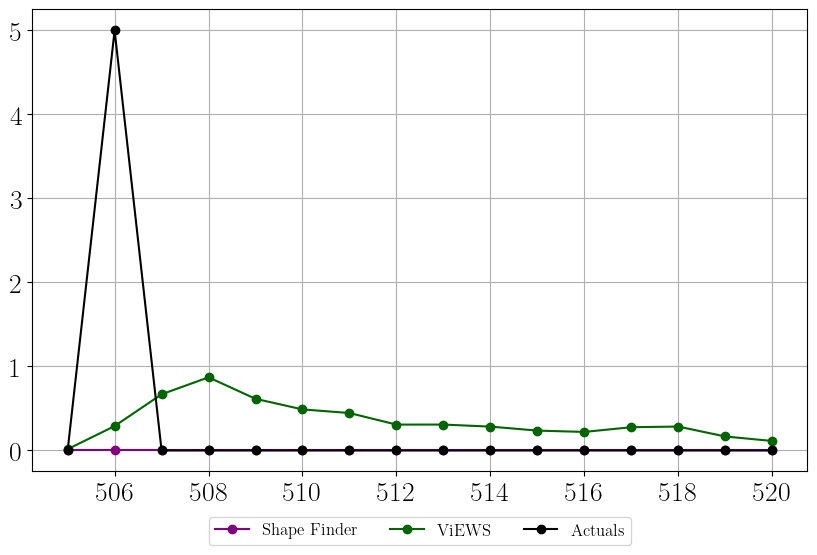

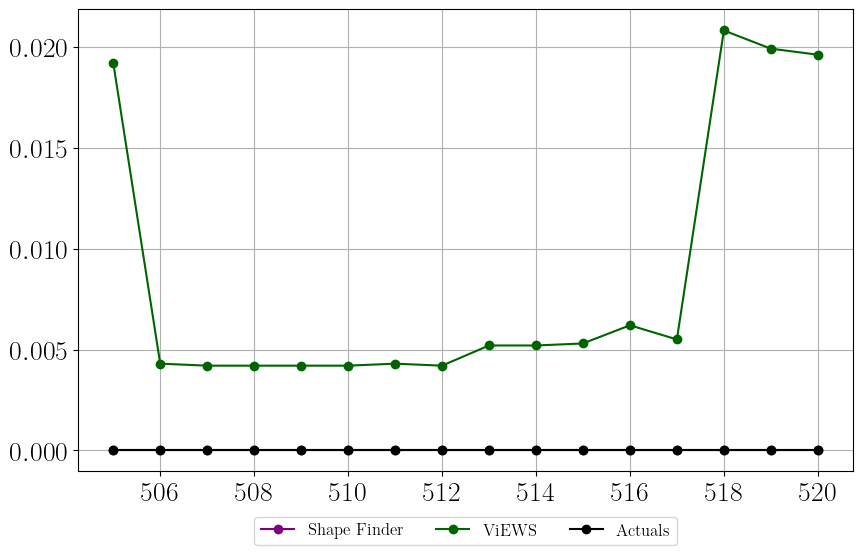

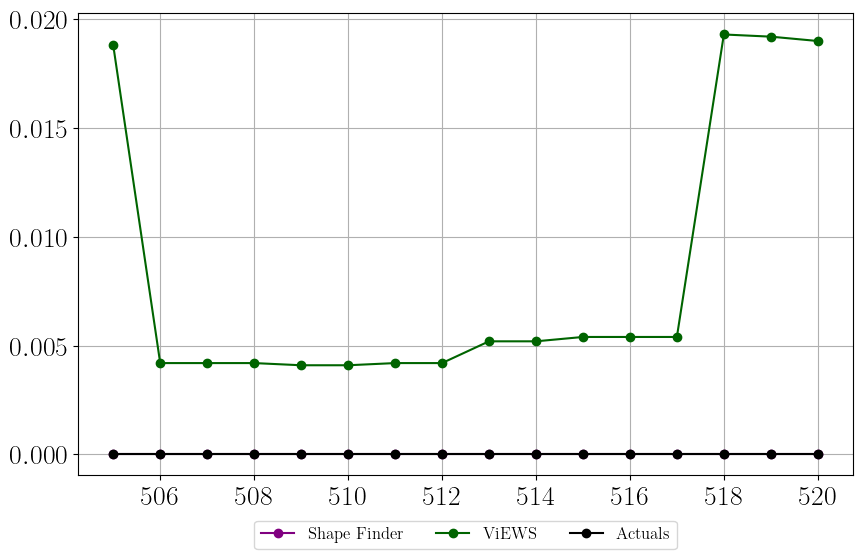

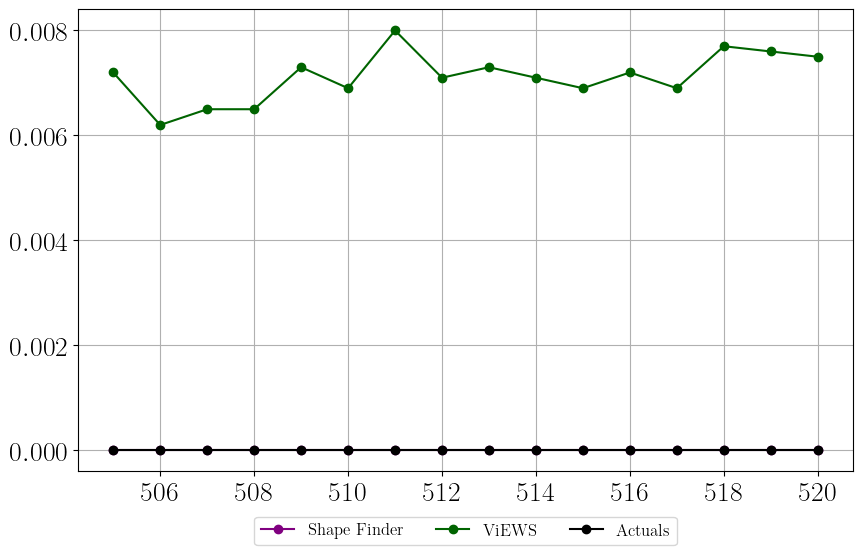

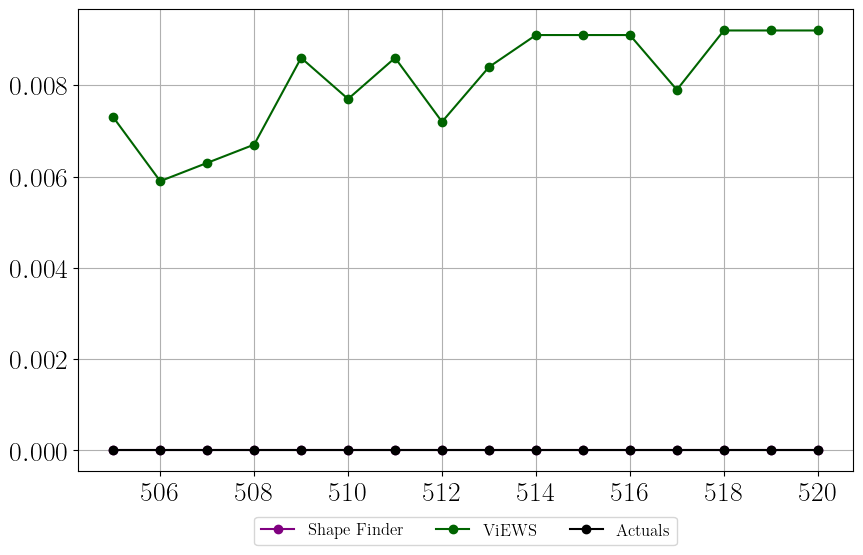

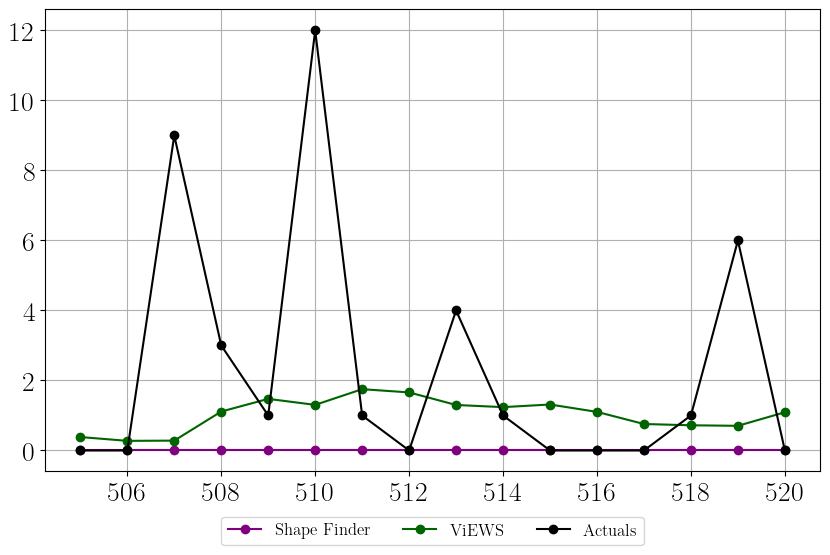

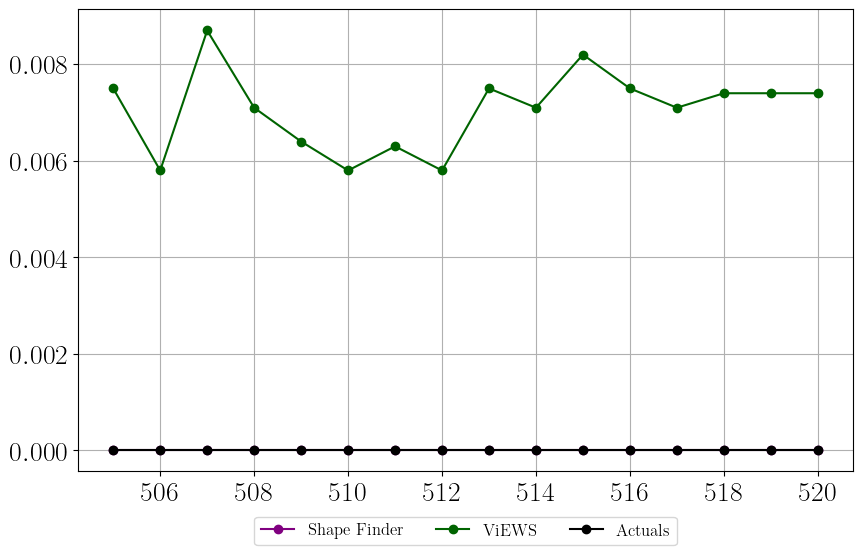

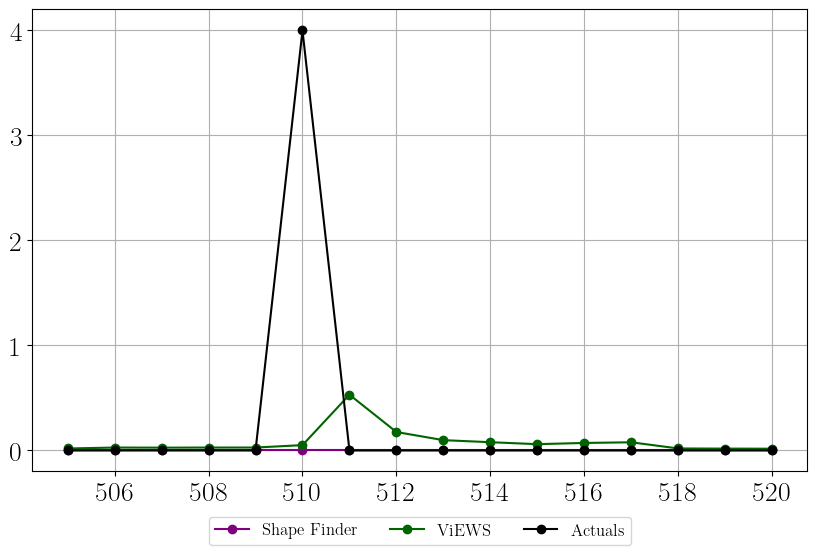

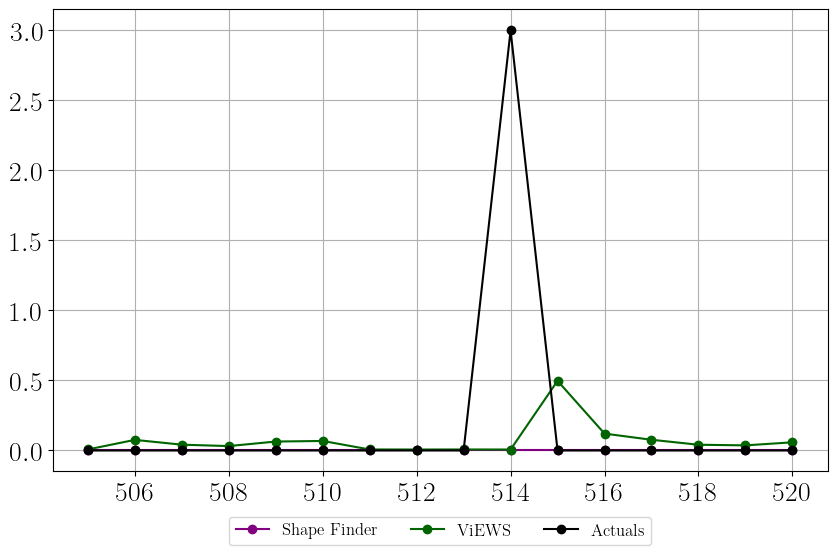

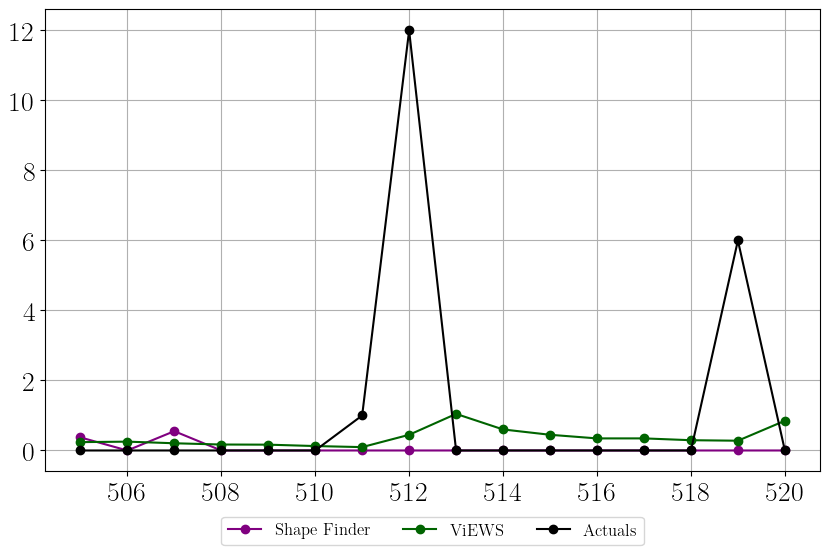

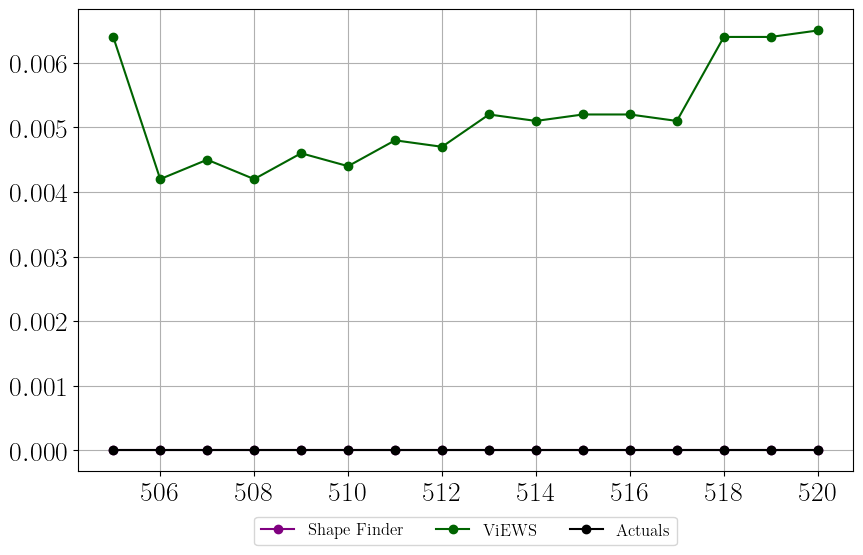

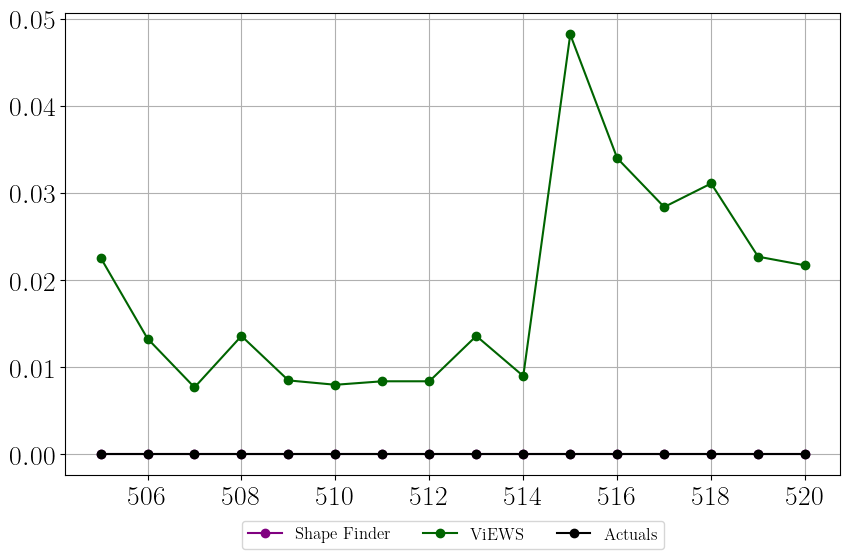

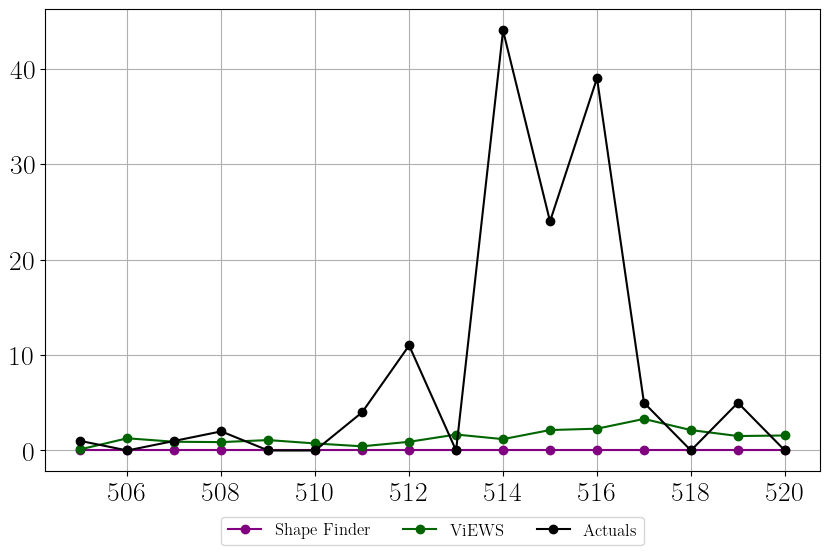

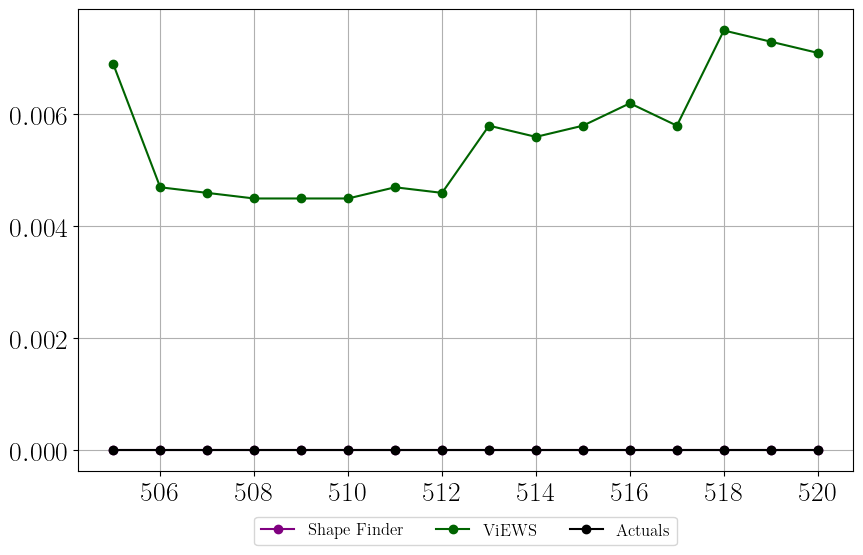

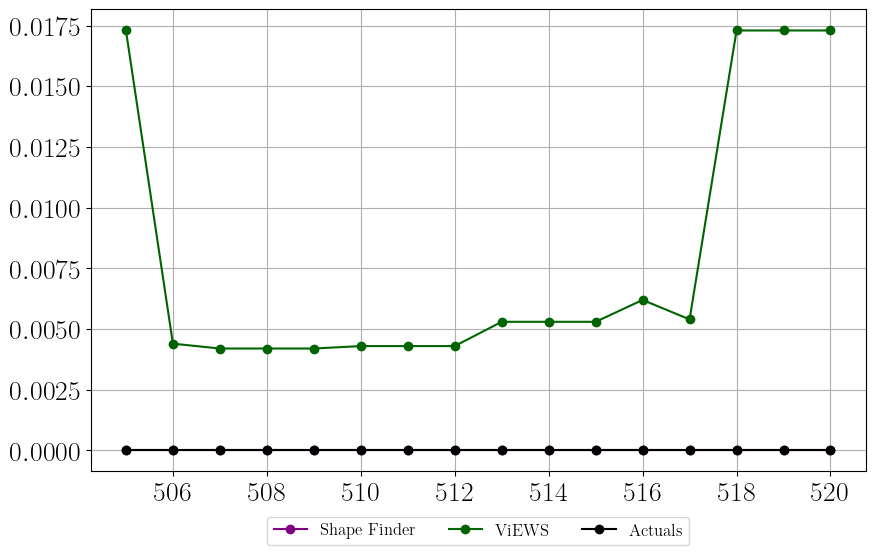

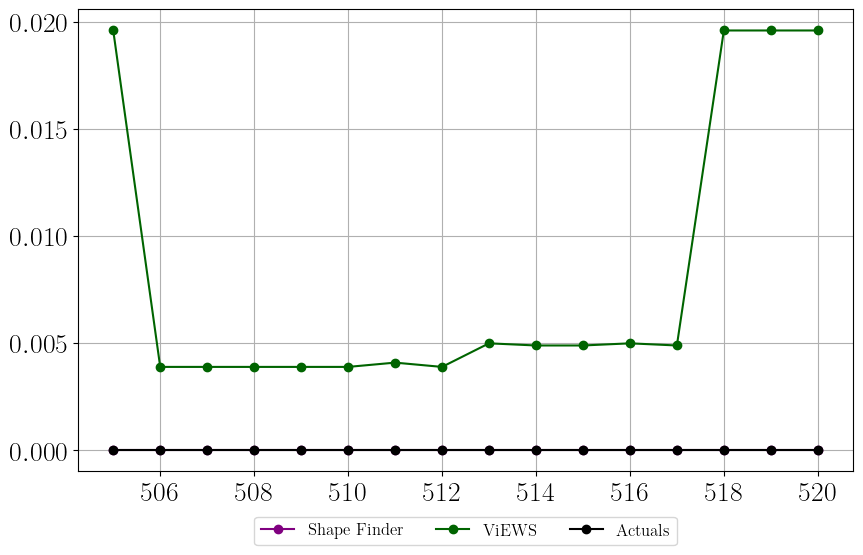

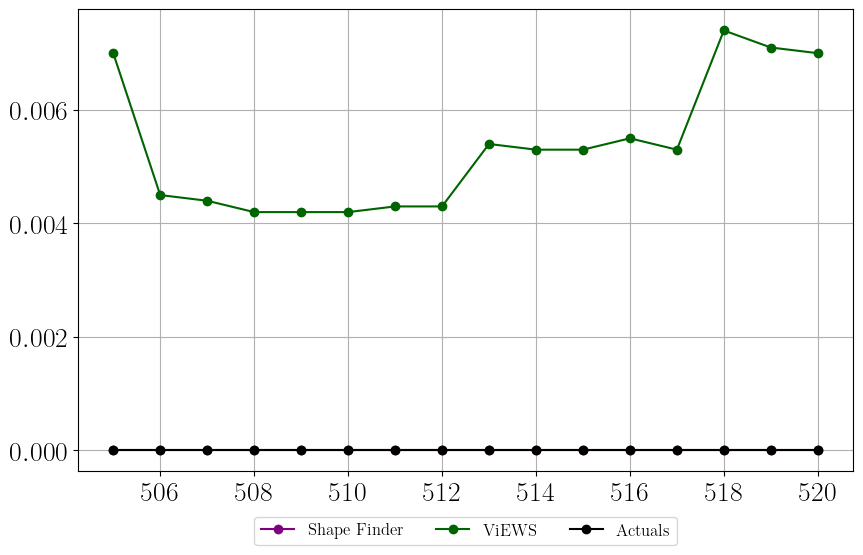

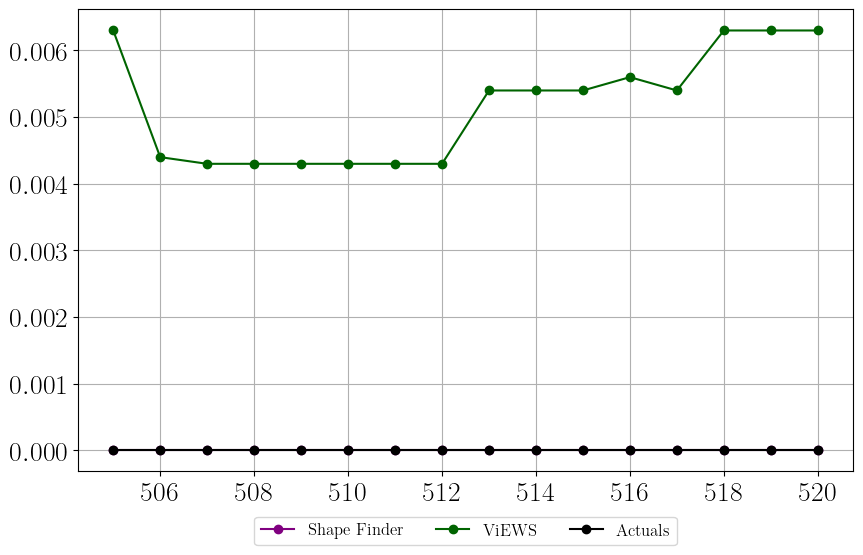

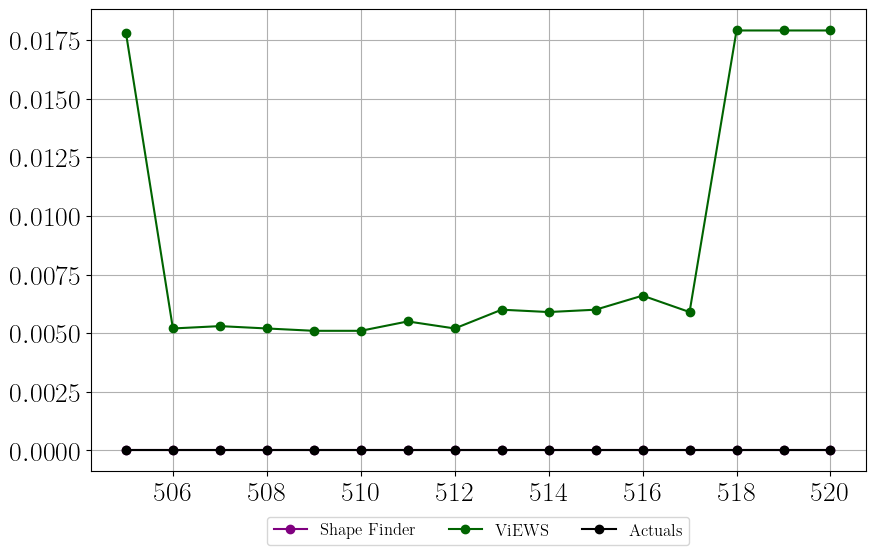

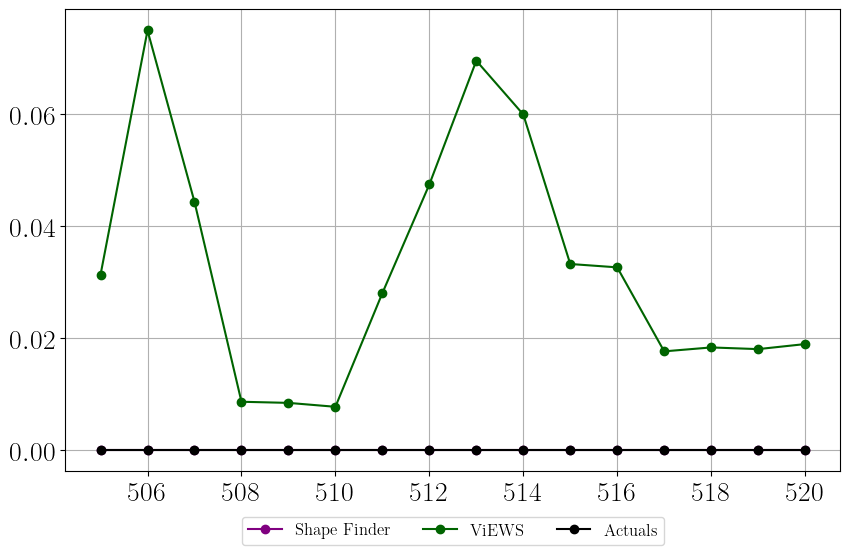

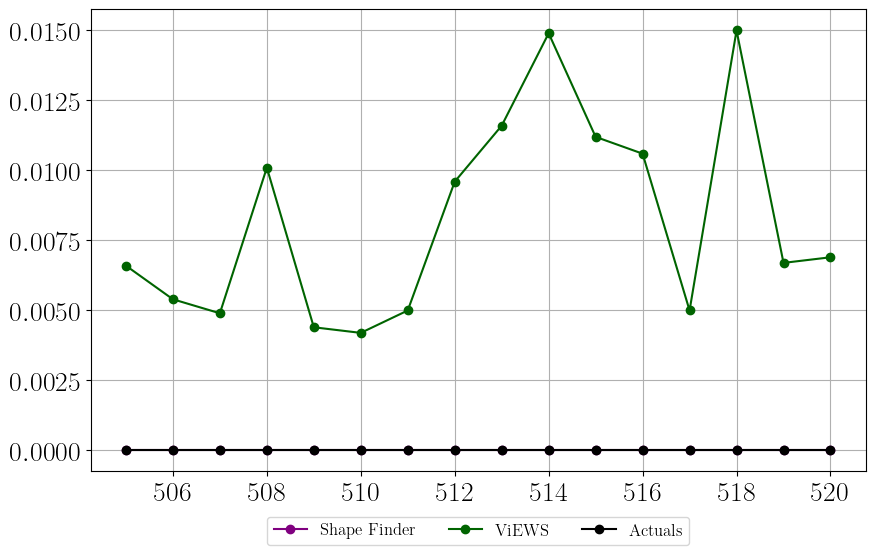

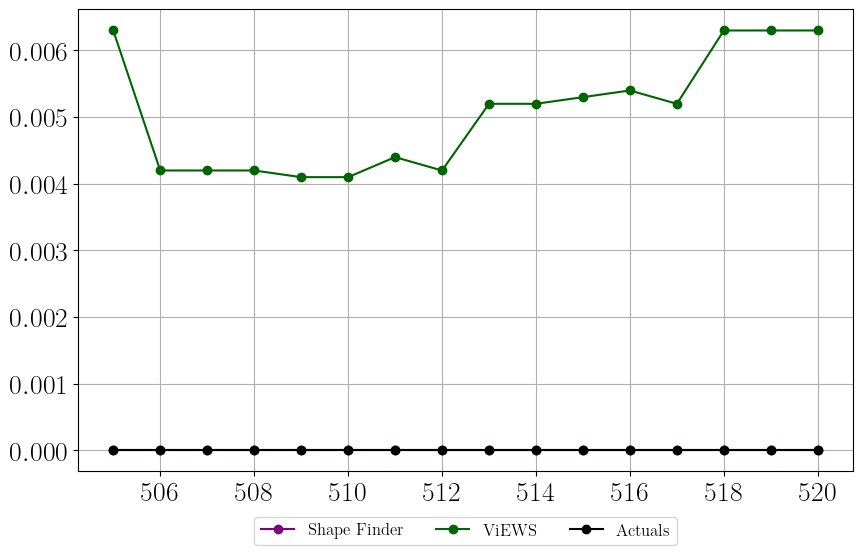

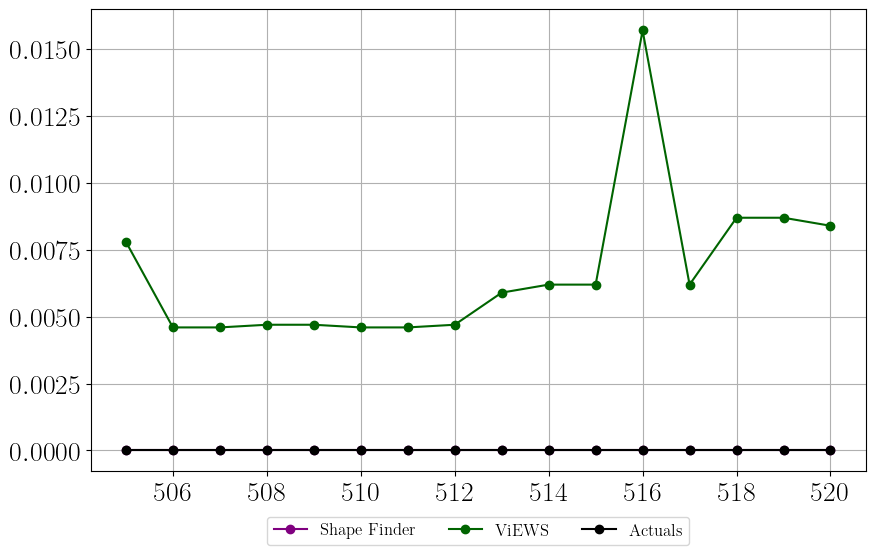

No patterns found to predict. Maybe increase the minimum distance.


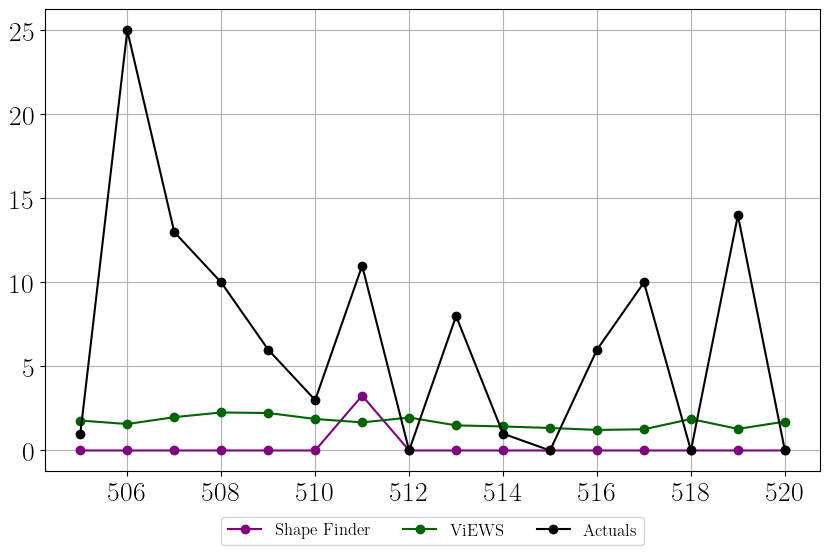

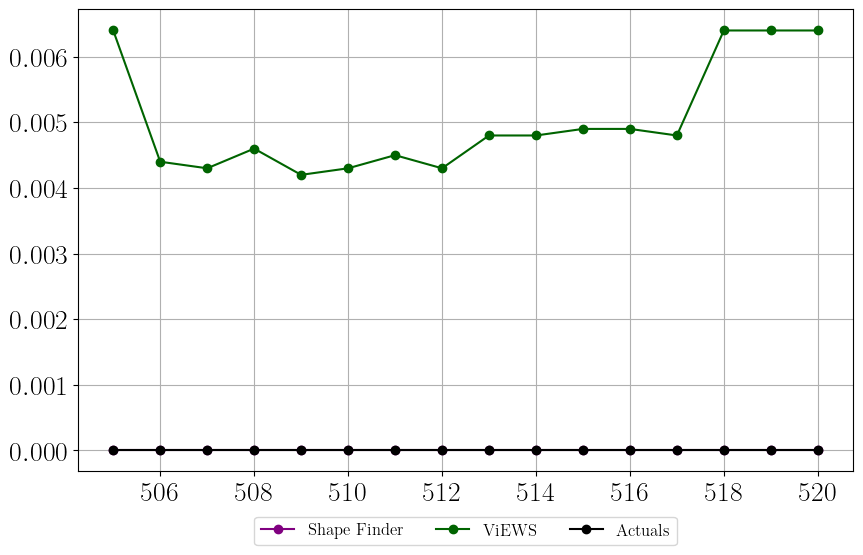

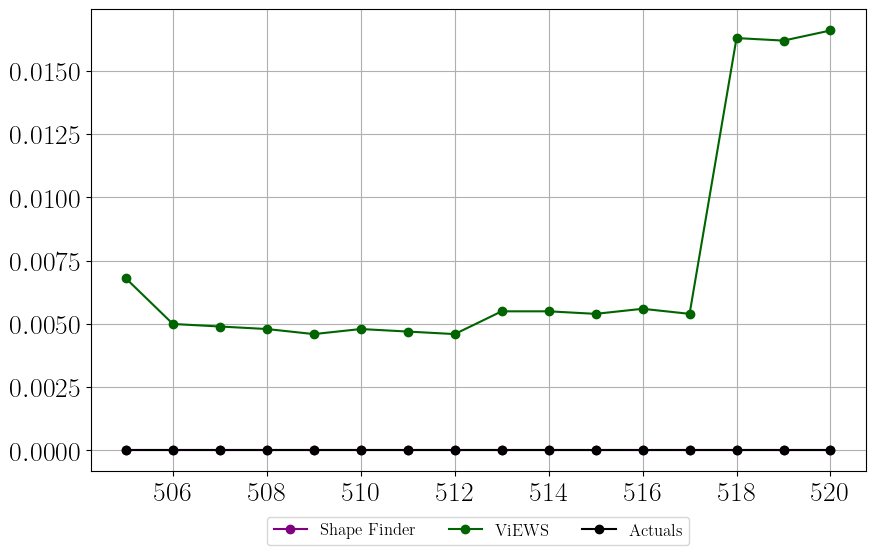

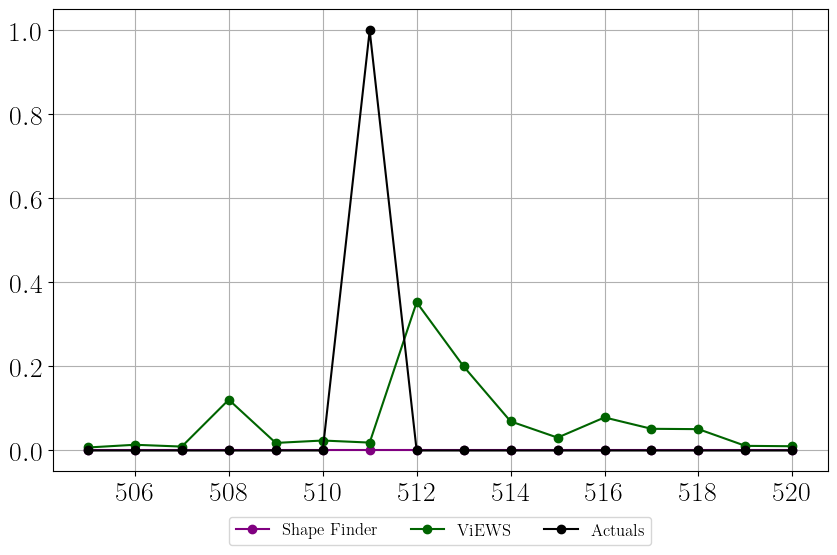

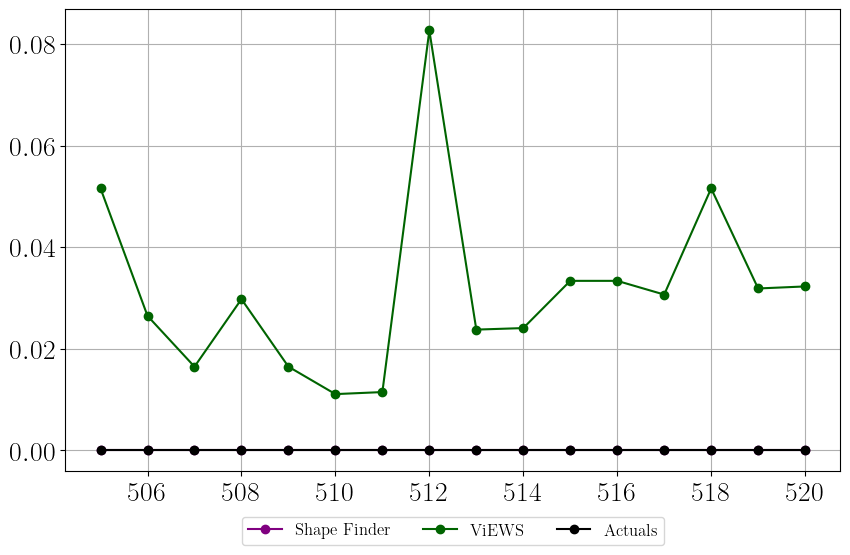

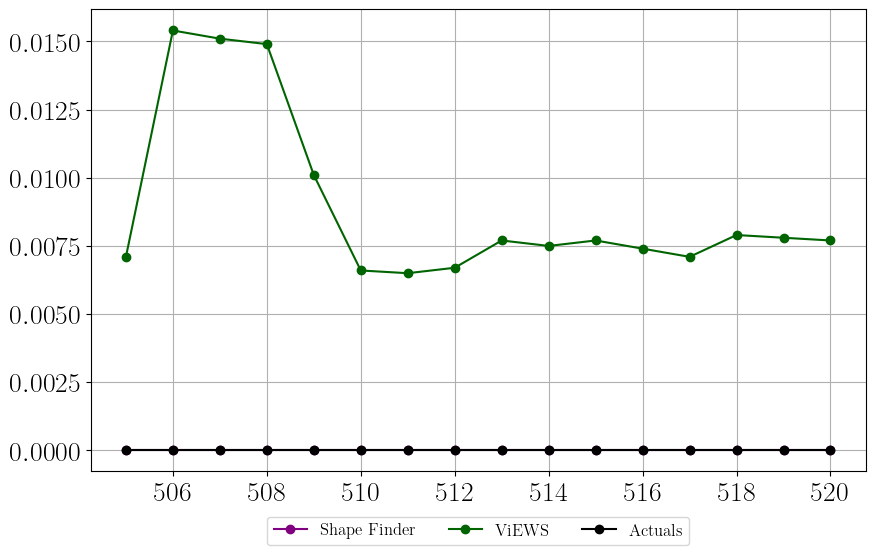

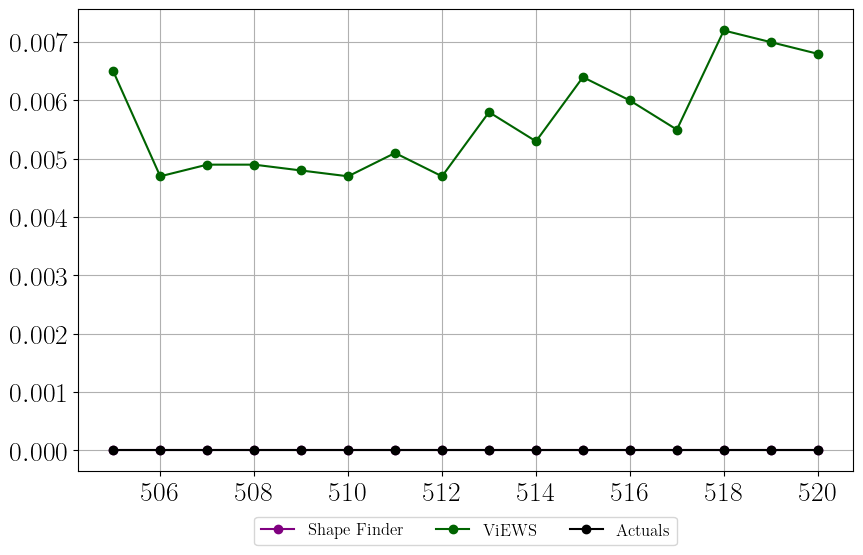

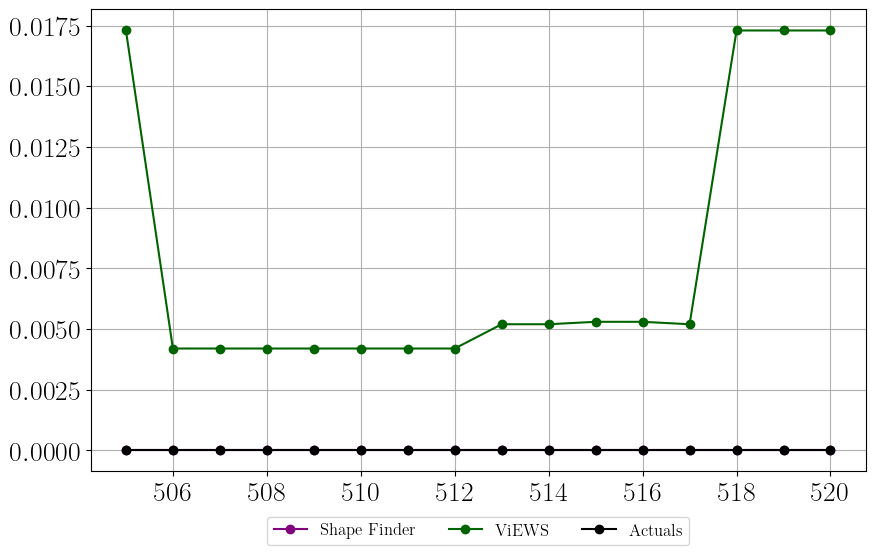

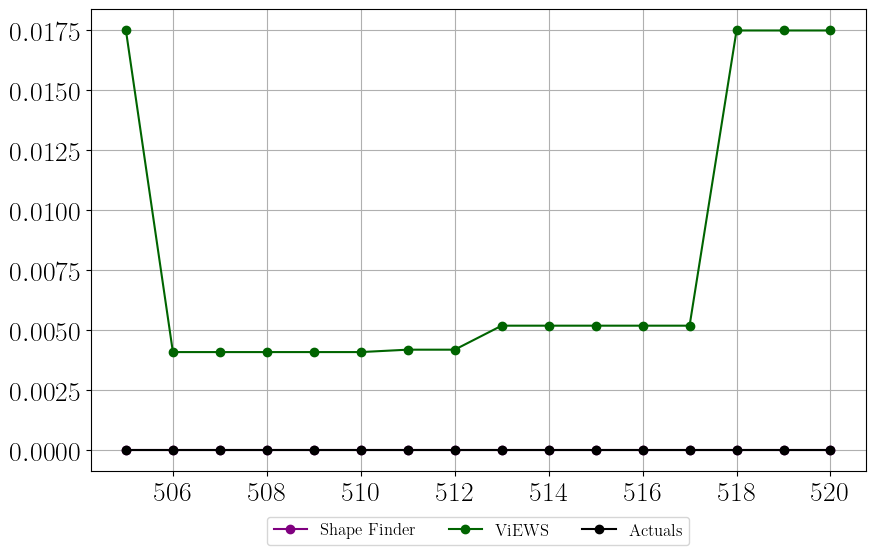

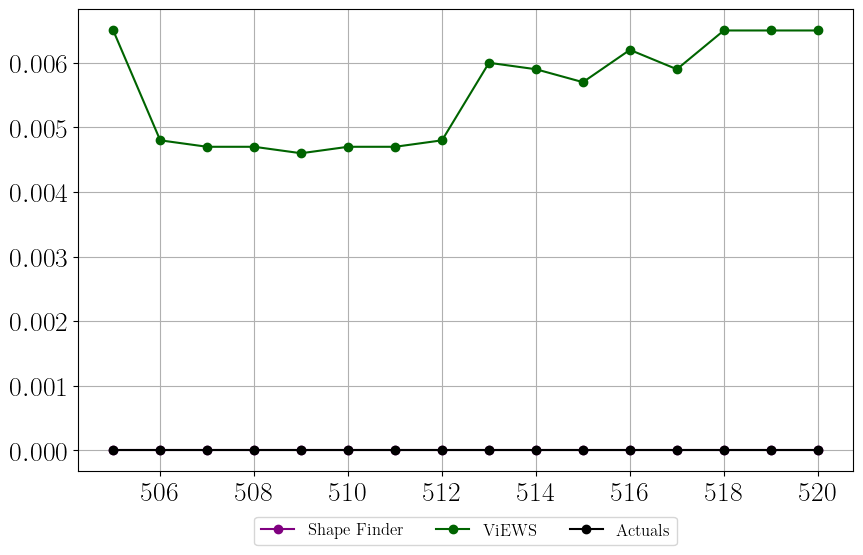

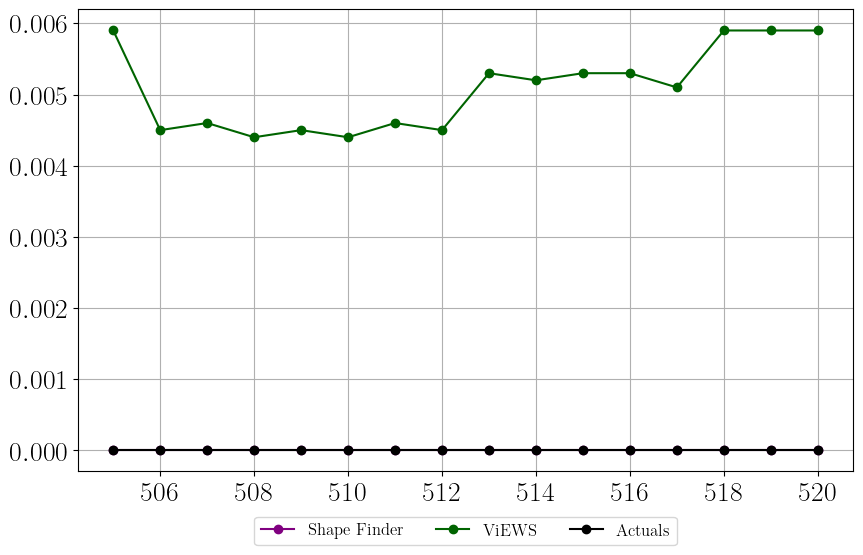

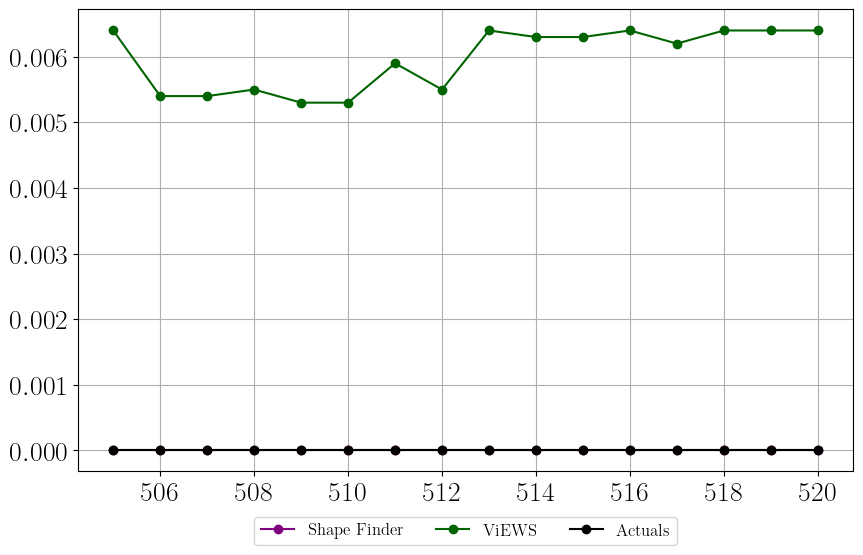

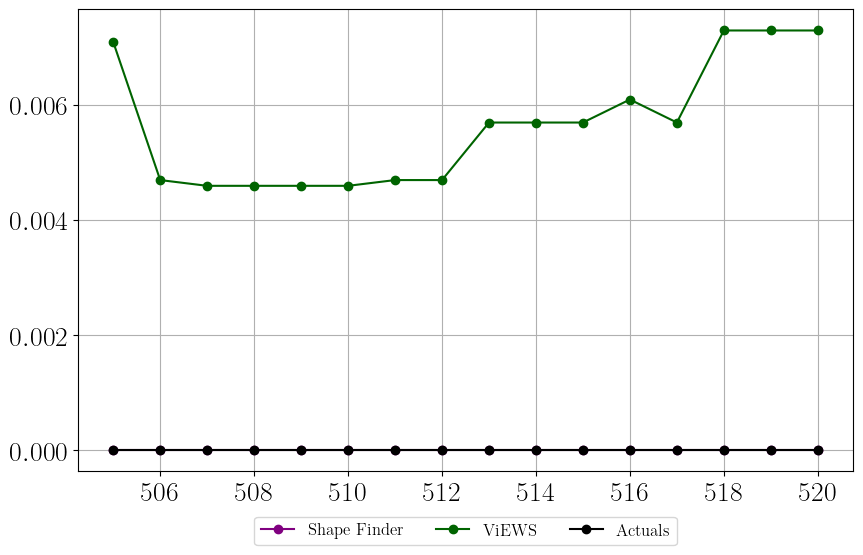

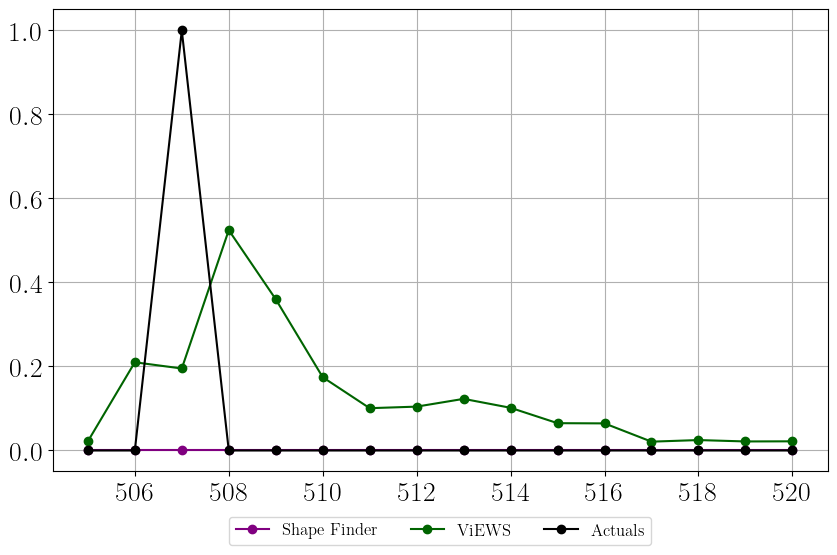

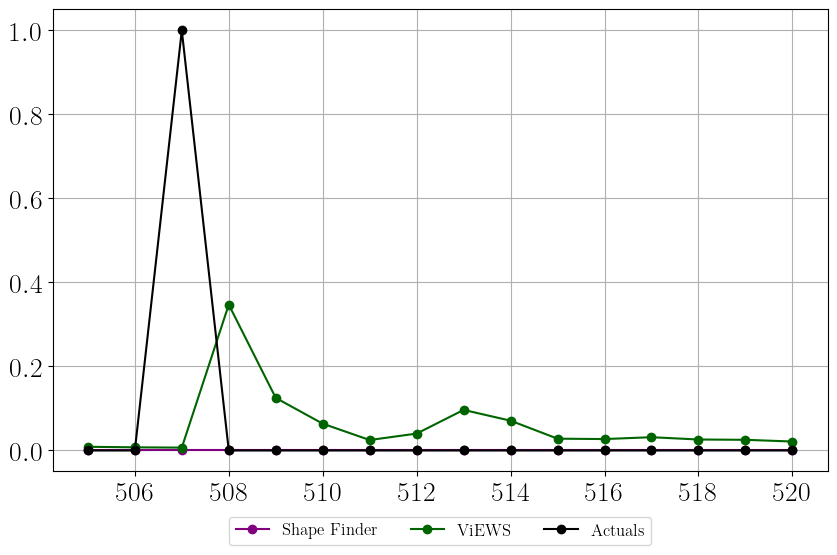

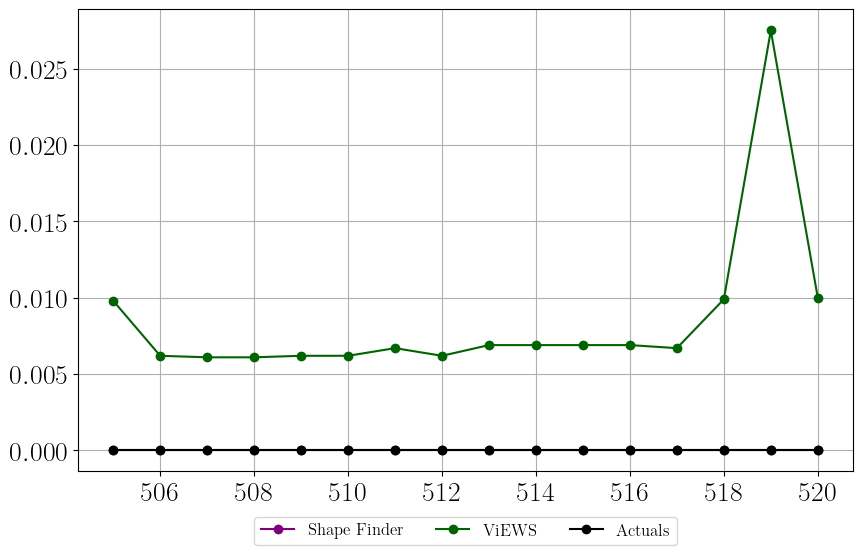

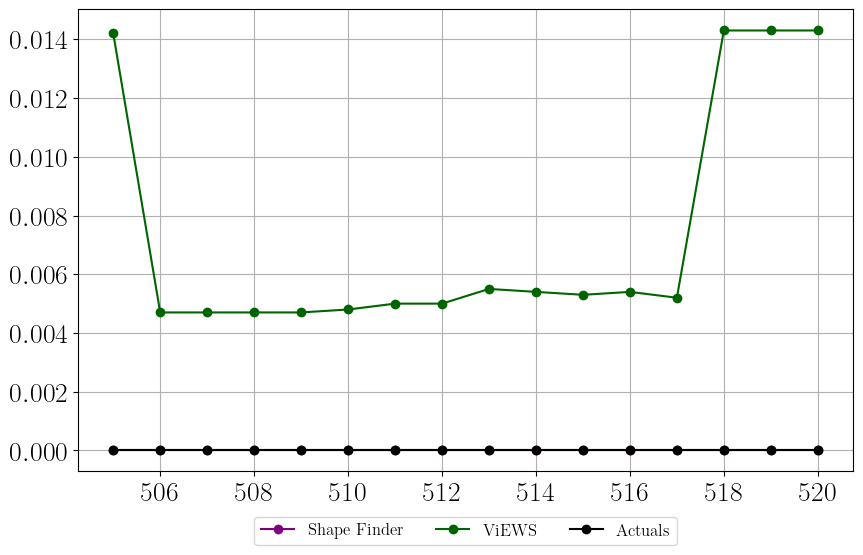

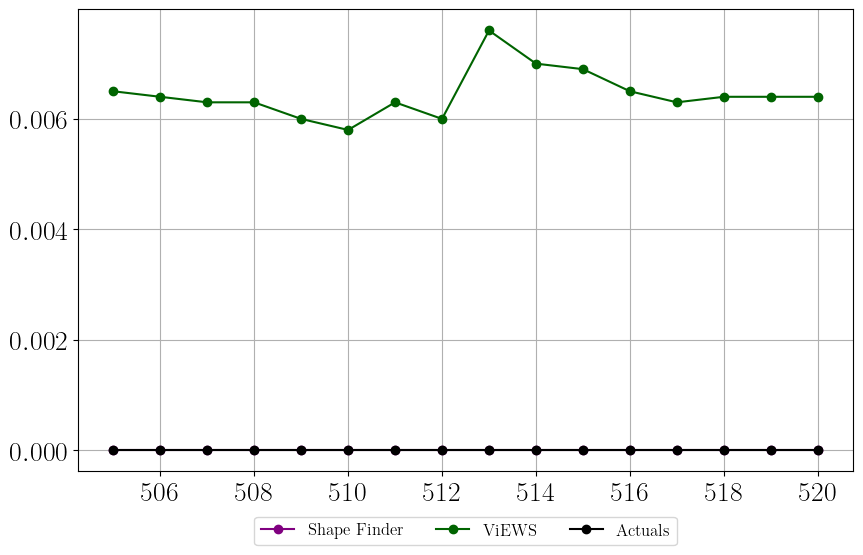

No patterns found to predict. Maybe increase the minimum distance.
No patterns found to predict. Maybe increase the minimum distance.


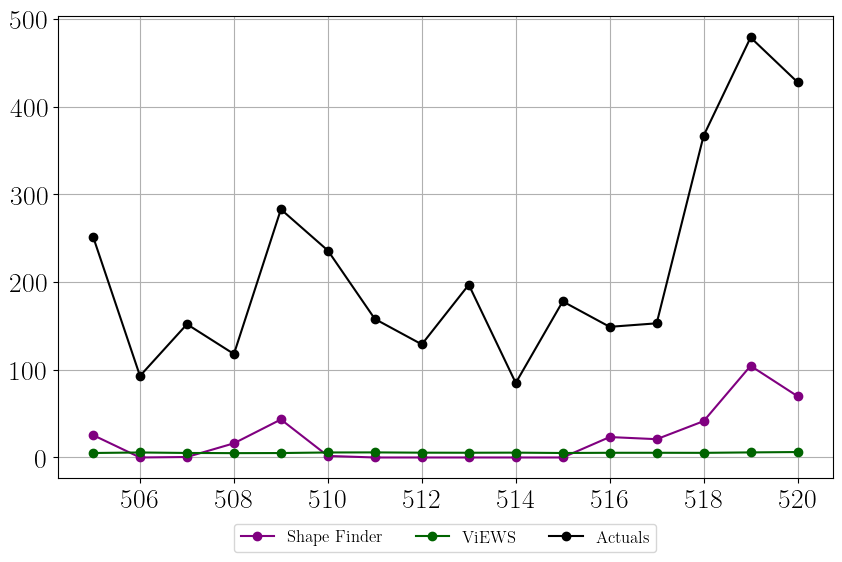

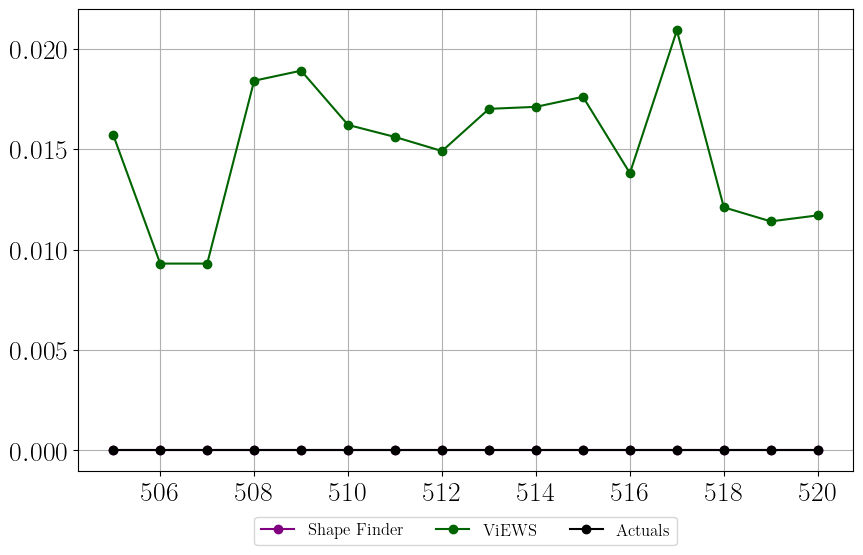

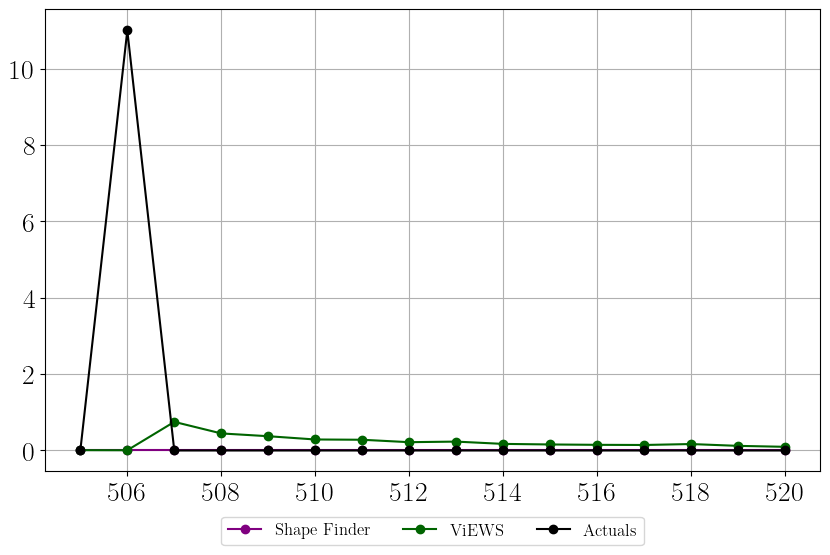

No patterns found to predict. Maybe increase the minimum distance.


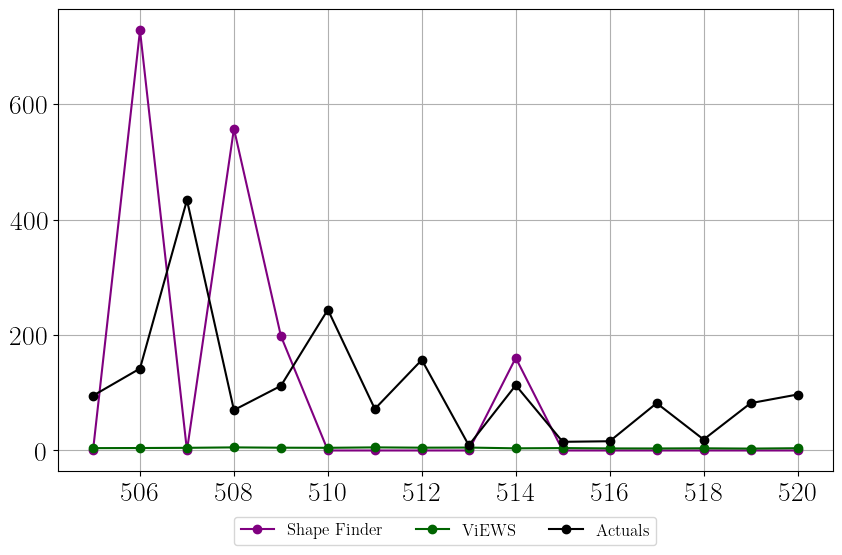

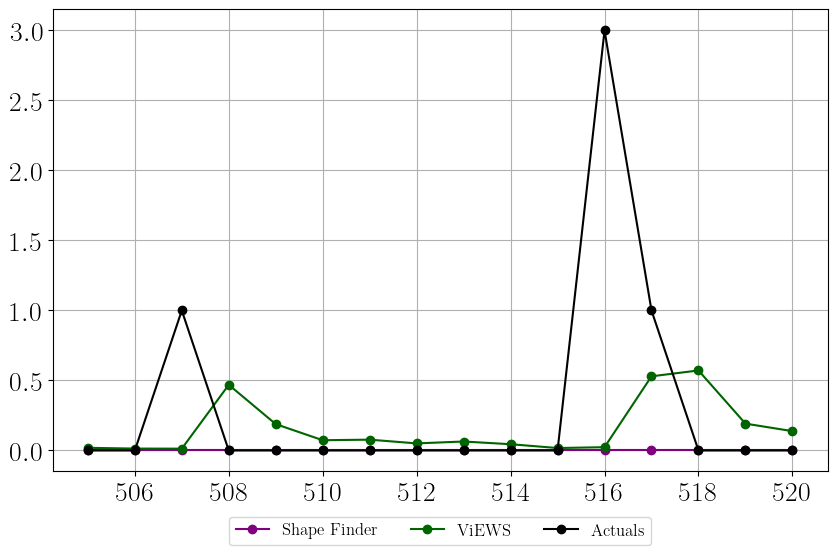

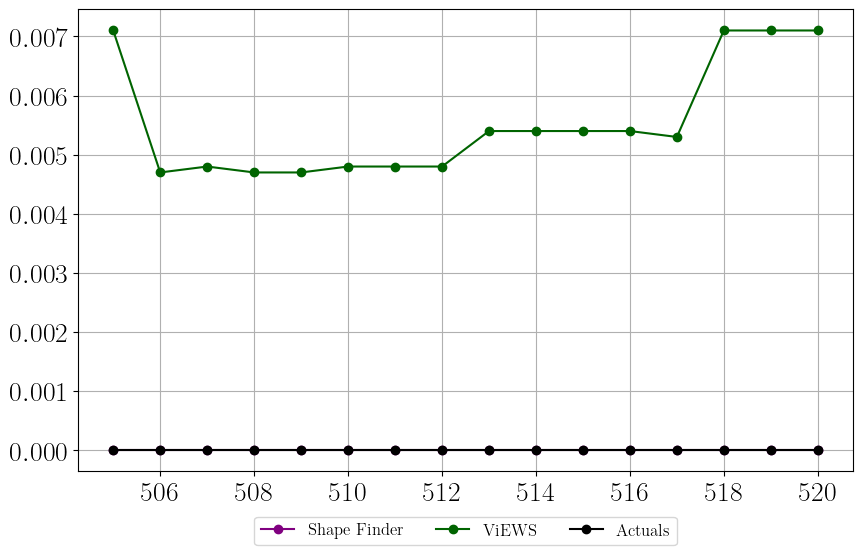

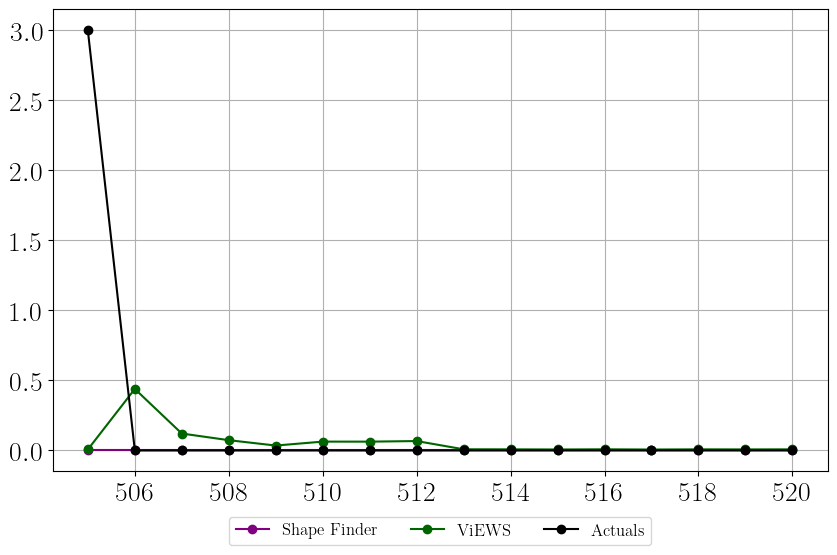

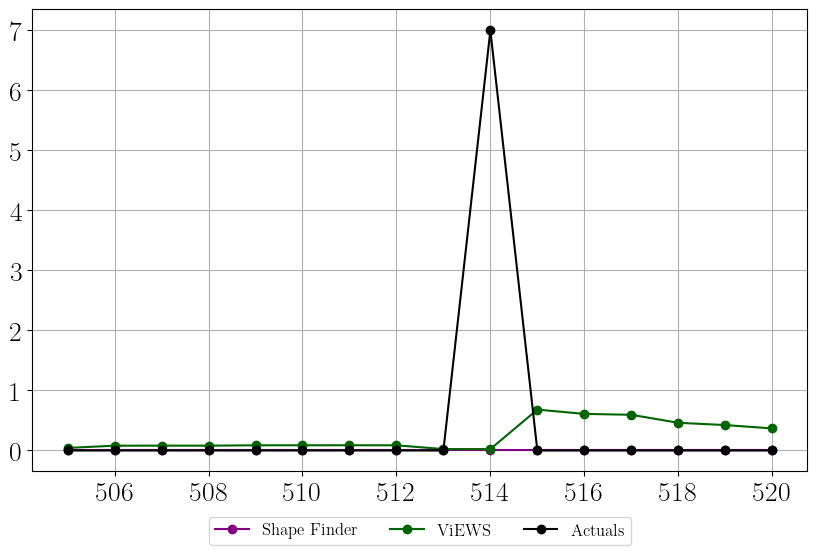

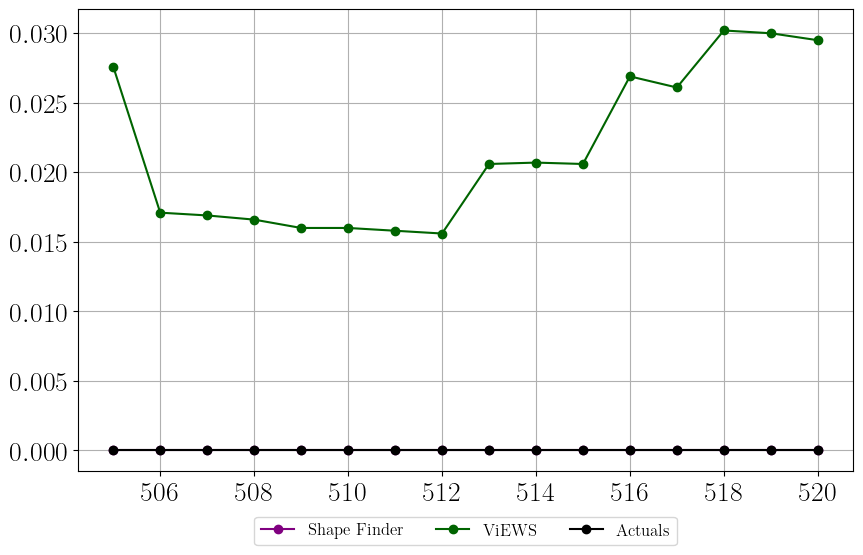

No patterns found to predict. Maybe increase the minimum distance.


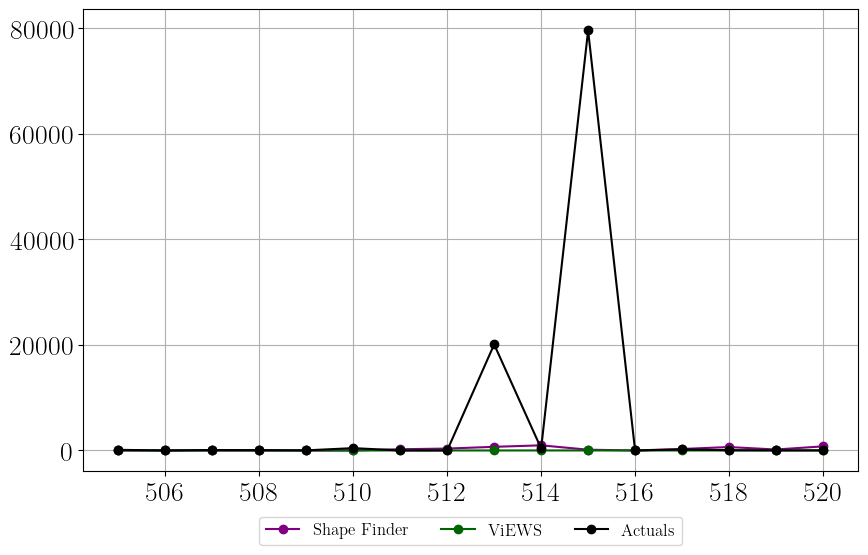

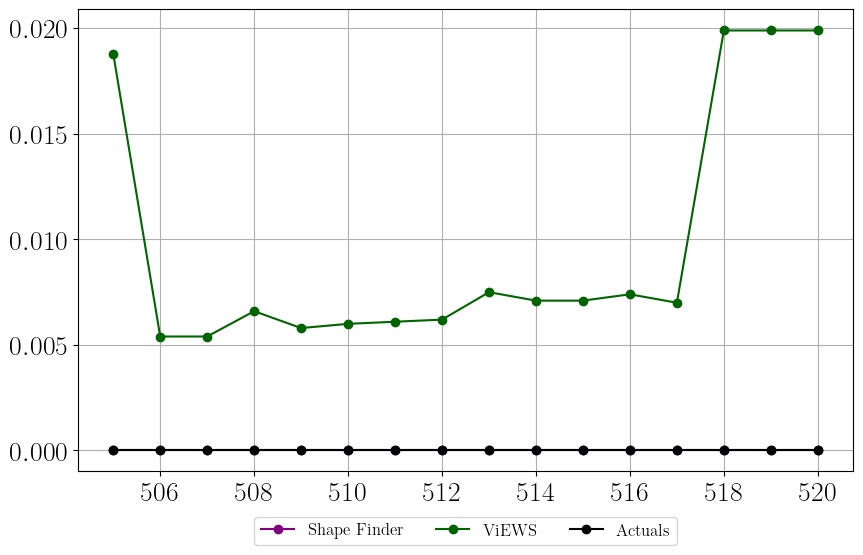

No patterns found to predict. Maybe increase the minimum distance.
No patterns found to predict. Maybe increase the minimum distance.


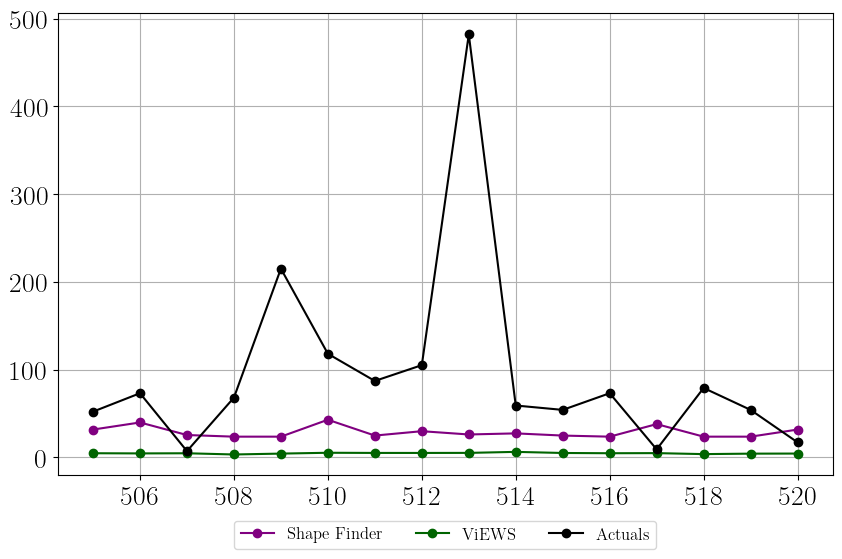

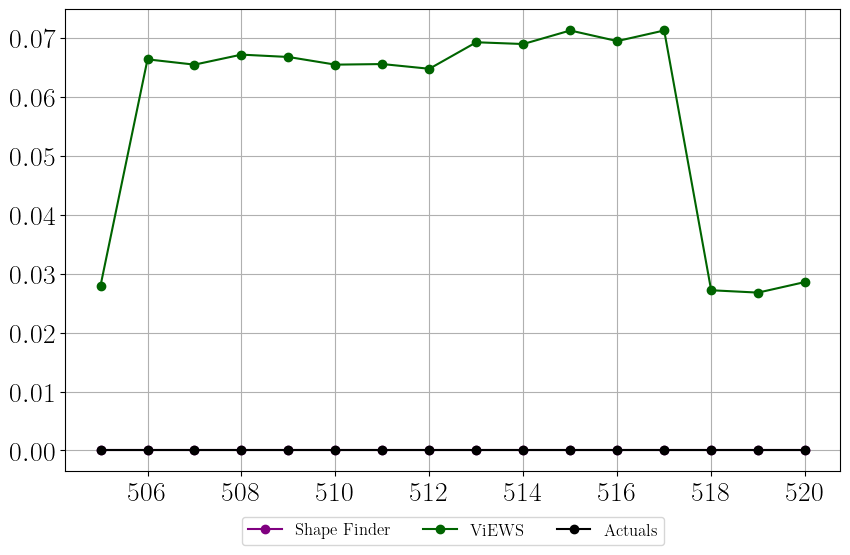

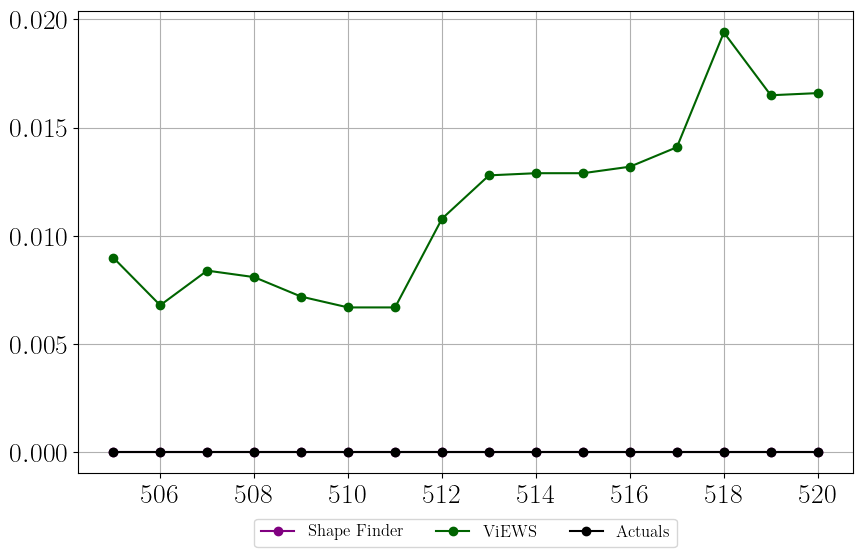

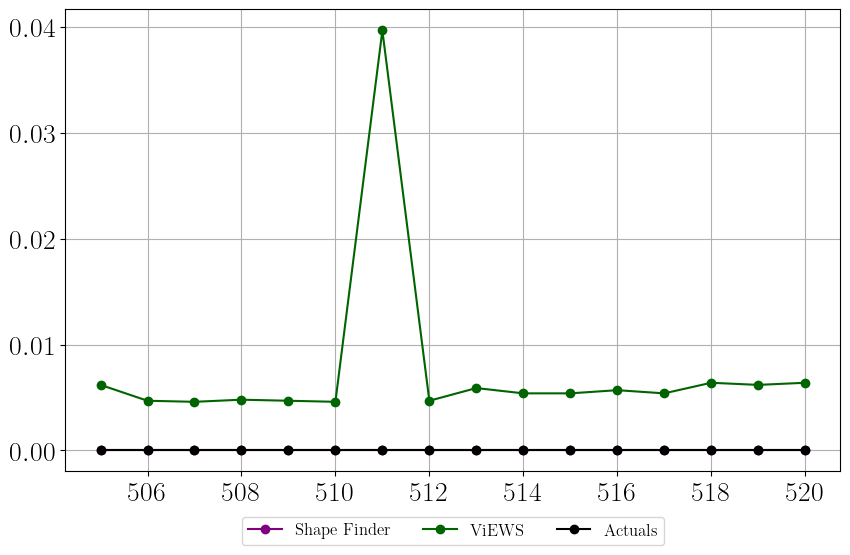

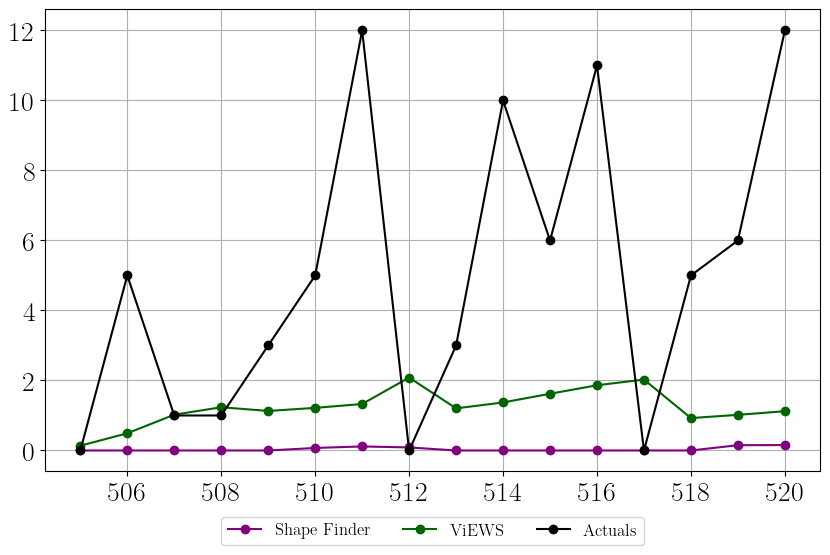

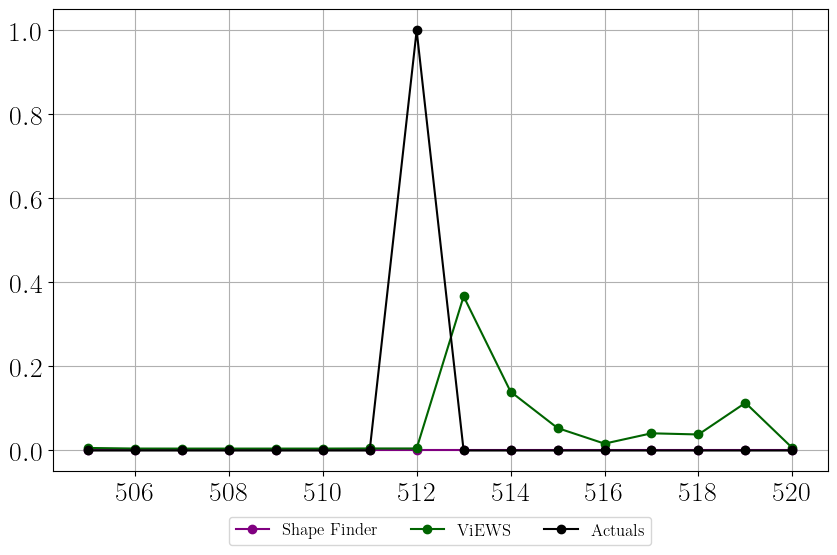

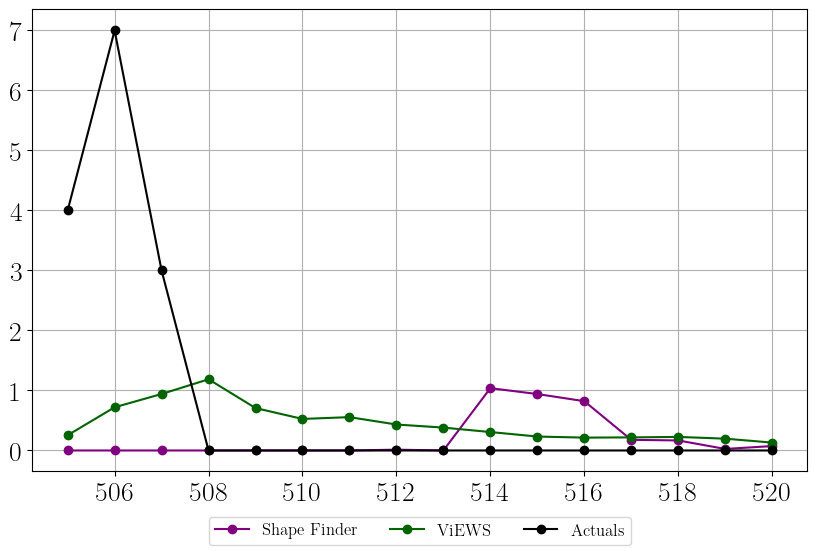

No patterns found to predict. Maybe increase the minimum distance.
No patterns found to predict. Maybe increase the minimum distance.
No patterns found to predict. Maybe increase the minimum distance.


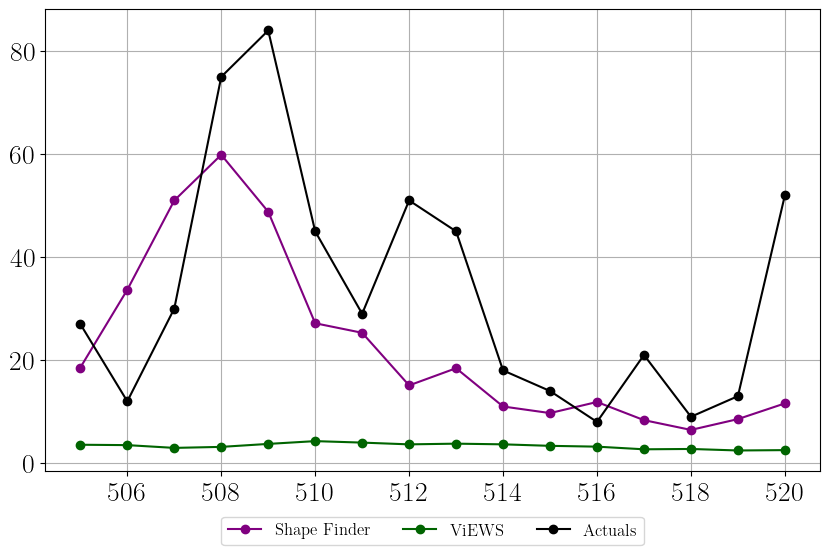

No patterns found to predict. Maybe increase the minimum distance.


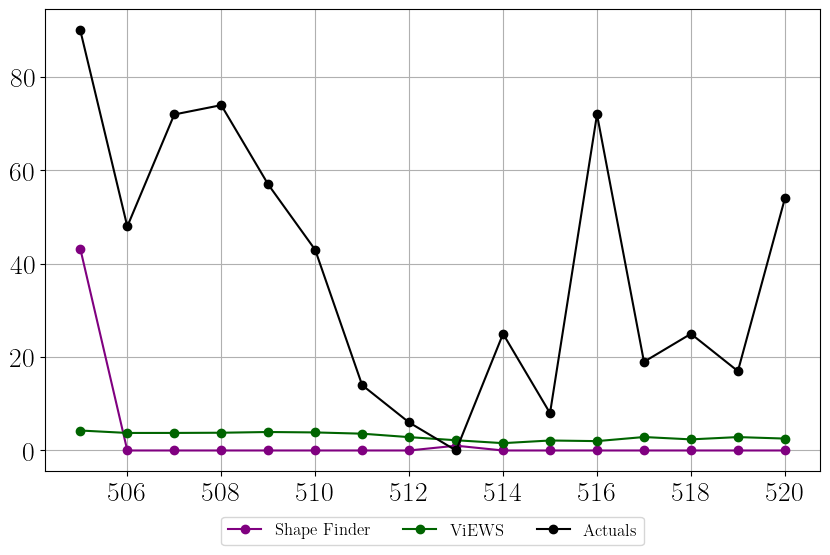

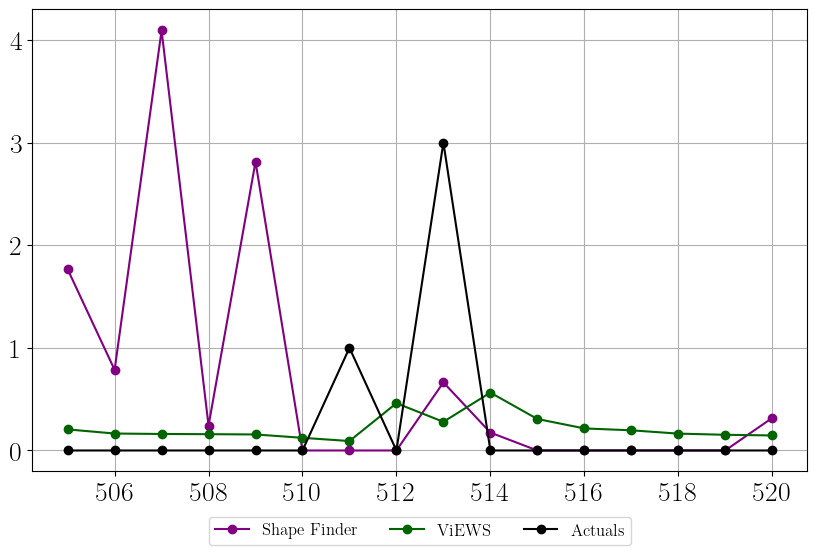

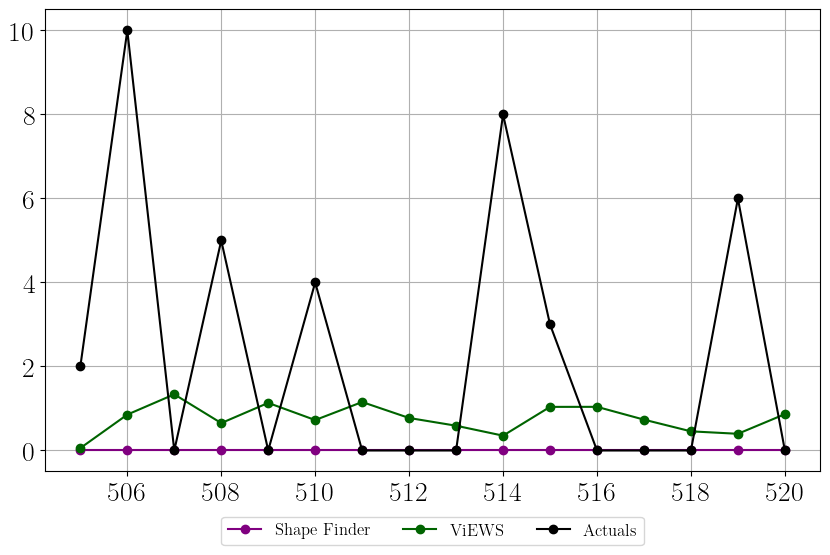

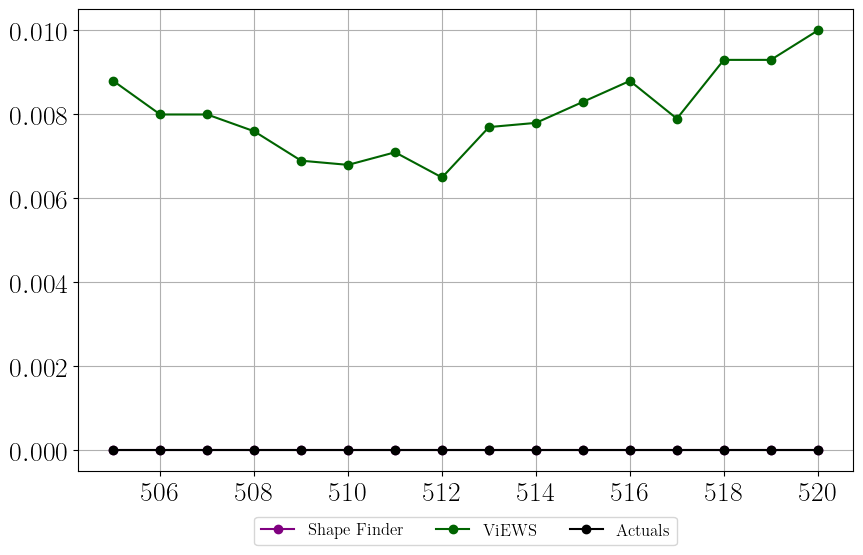

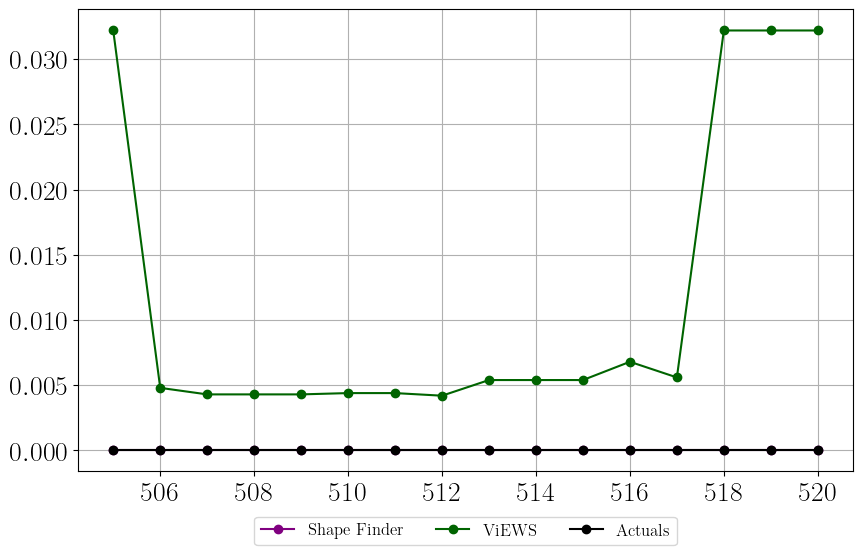

No patterns found to predict. Maybe increase the minimum distance.


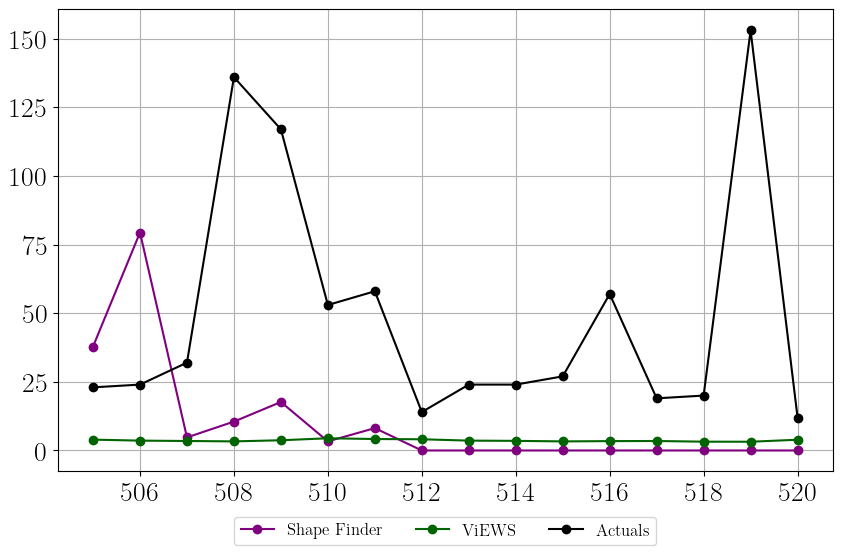

No patterns found to predict. Maybe increase the minimum distance.
No patterns found to predict. Maybe increase the minimum distance.


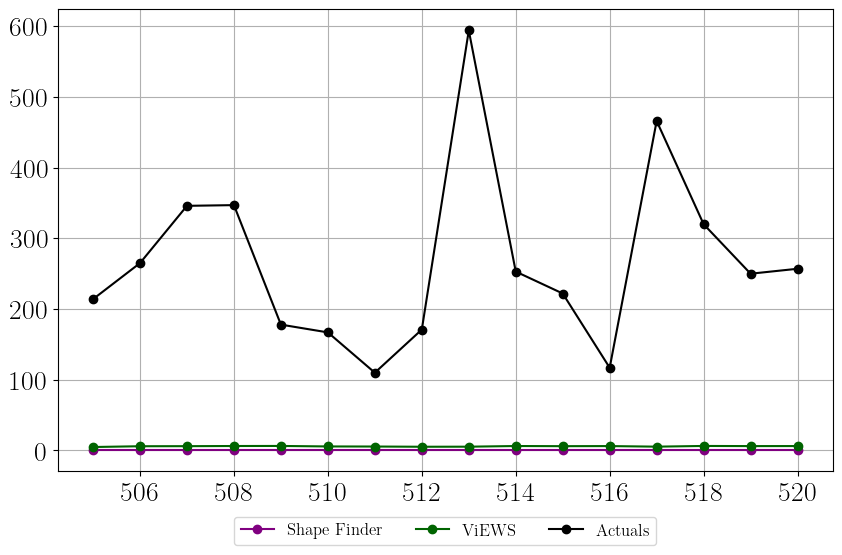

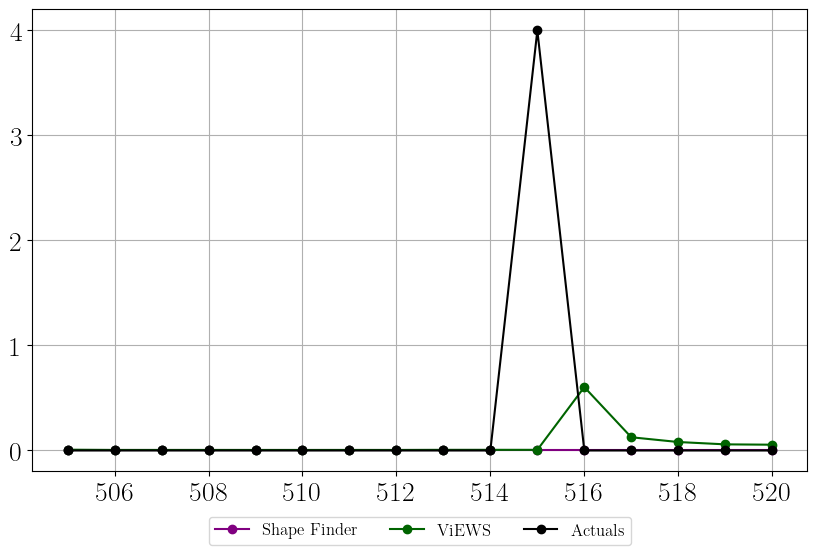

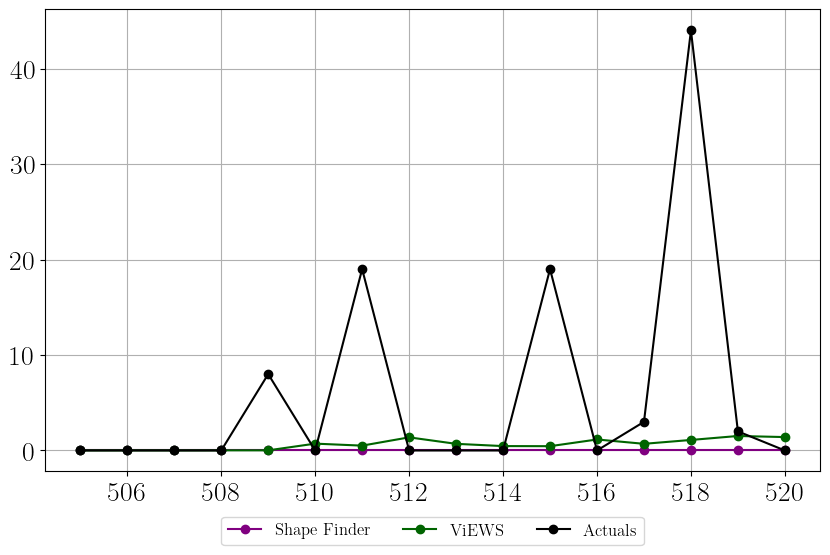

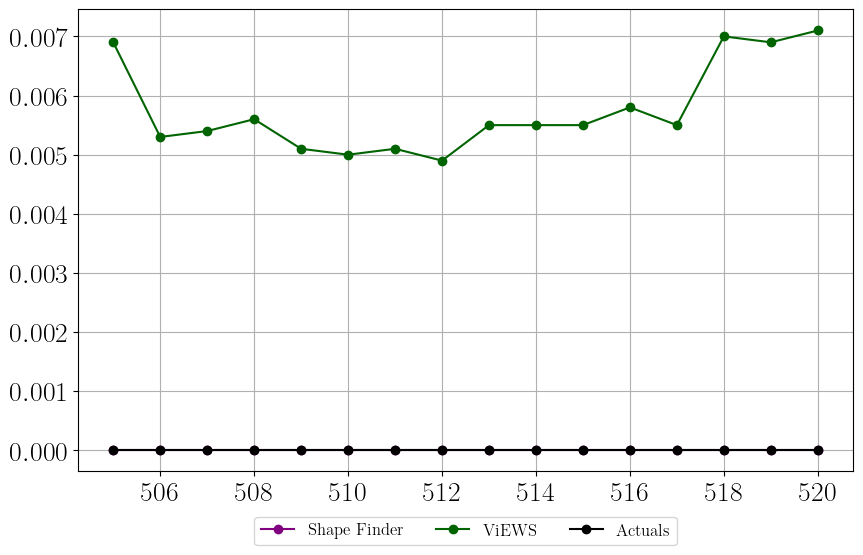

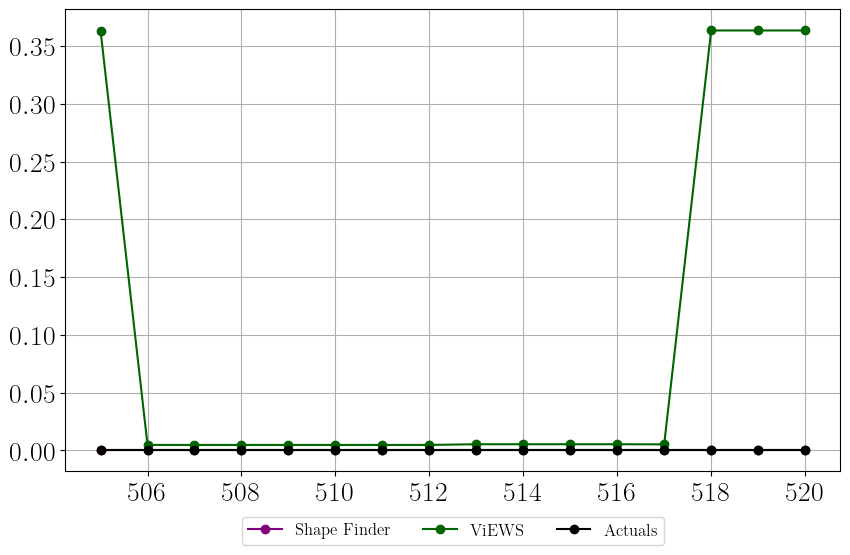

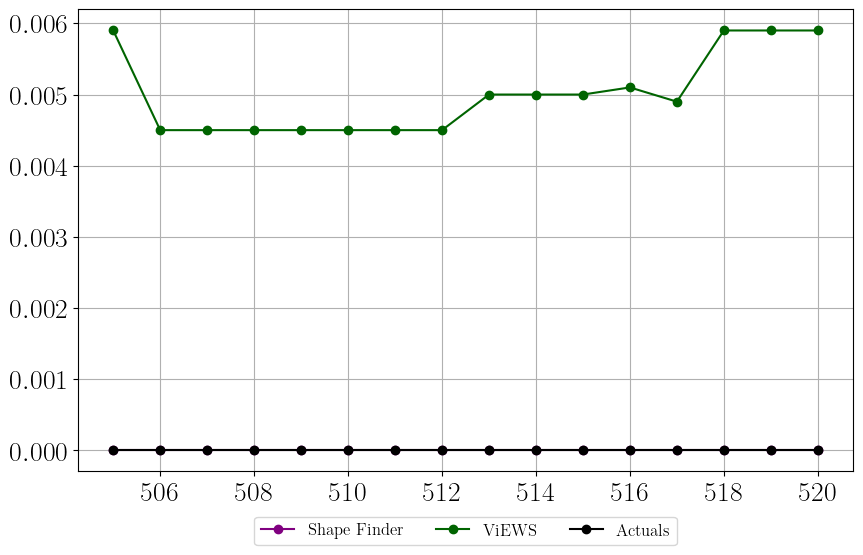

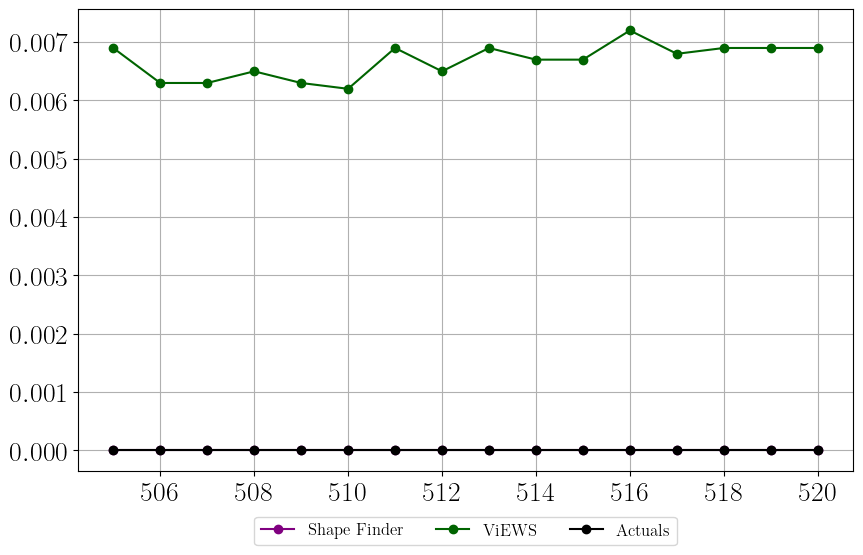

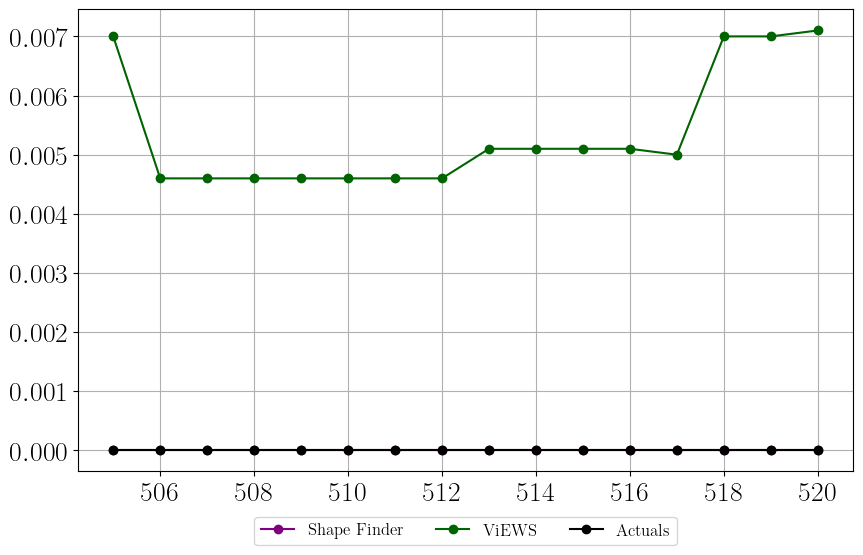

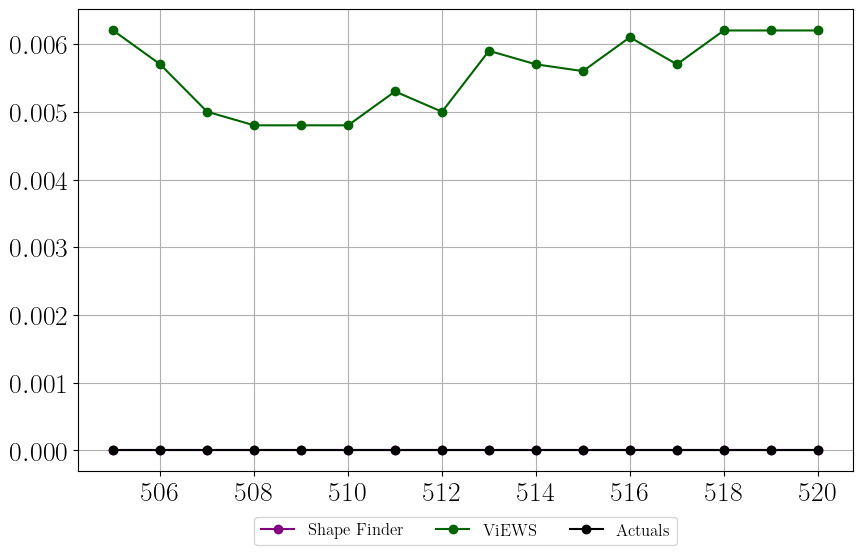

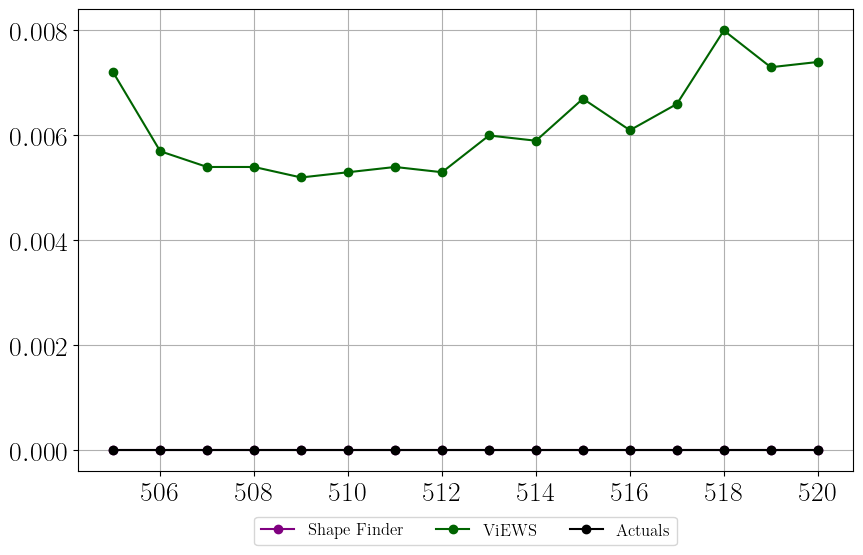

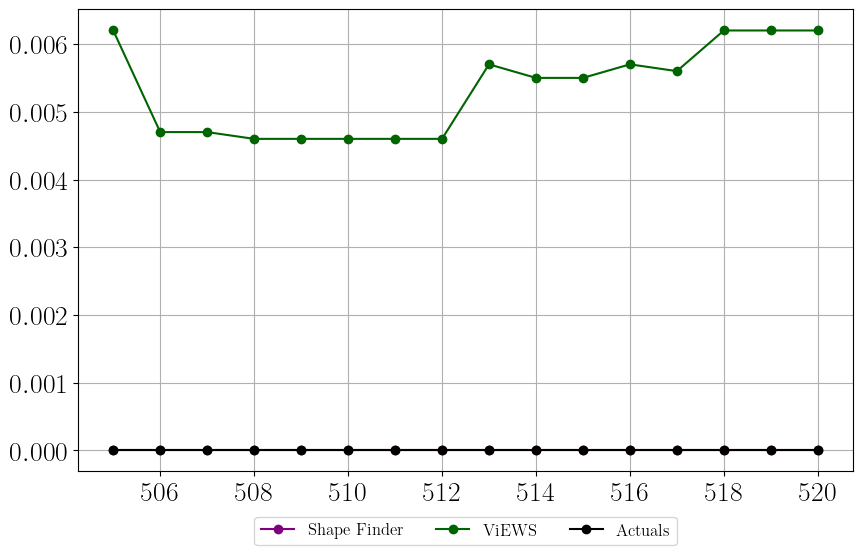

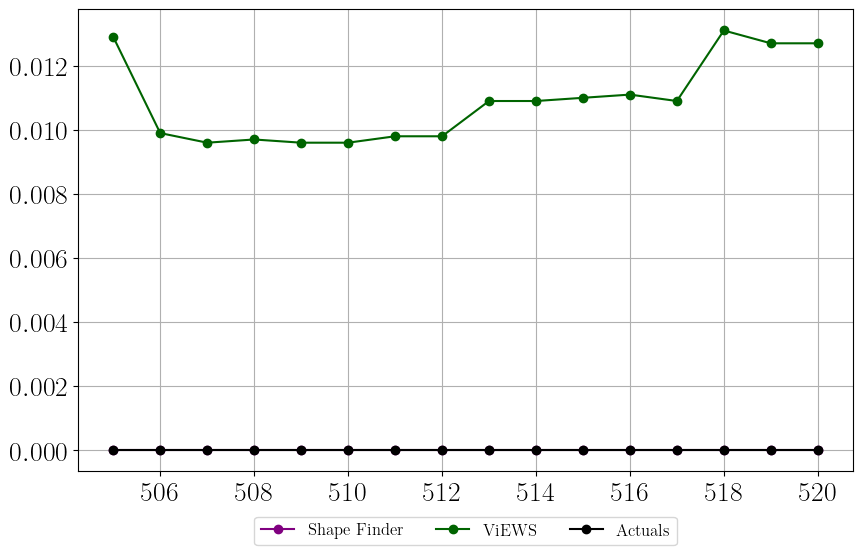

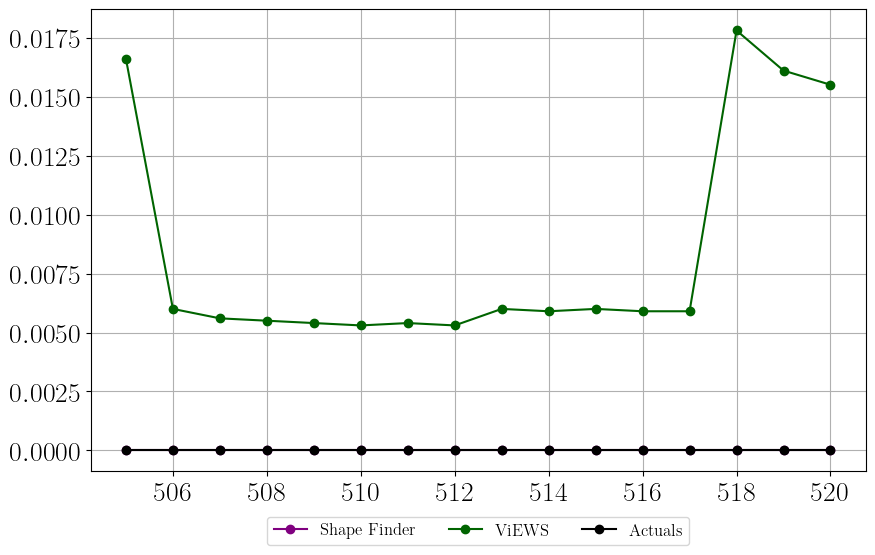

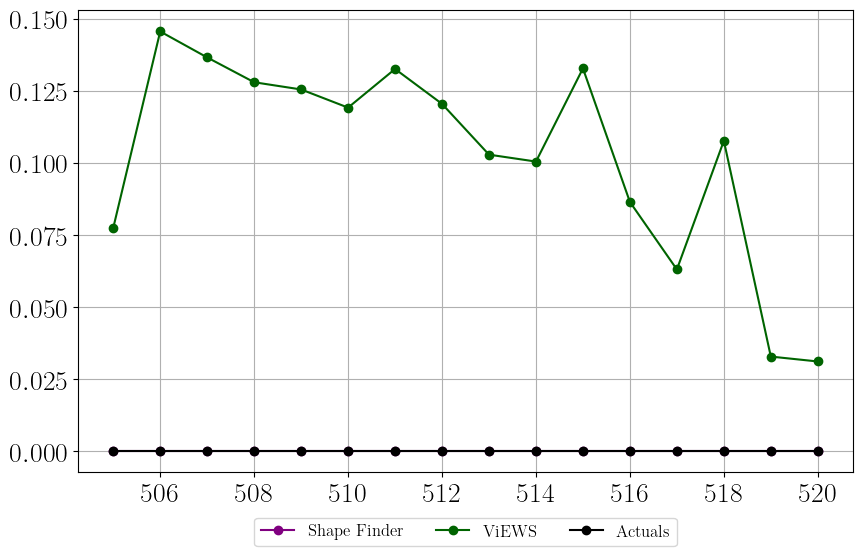

No patterns found to predict. Maybe increase the minimum distance.
No patterns found to predict. Maybe increase the minimum distance.


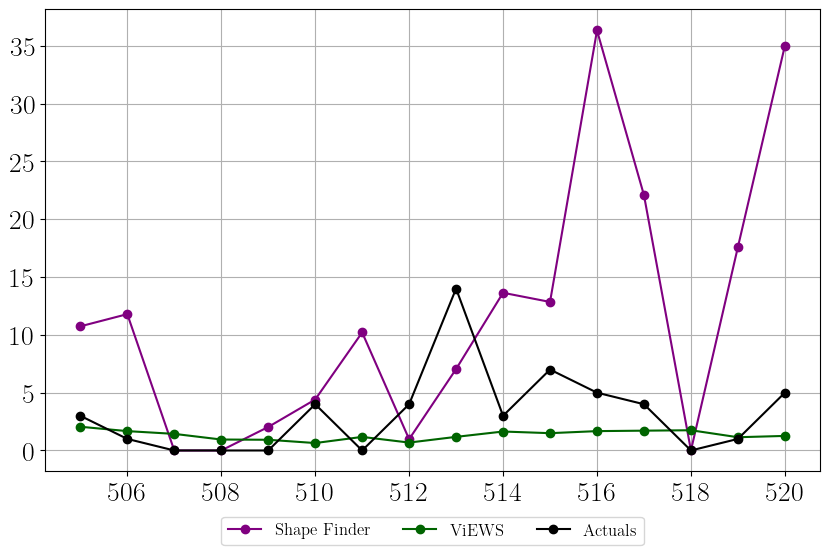

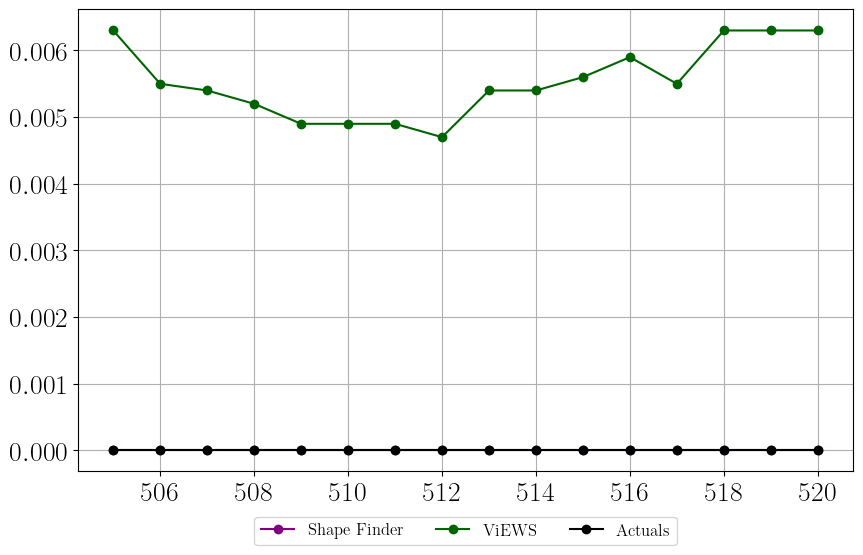

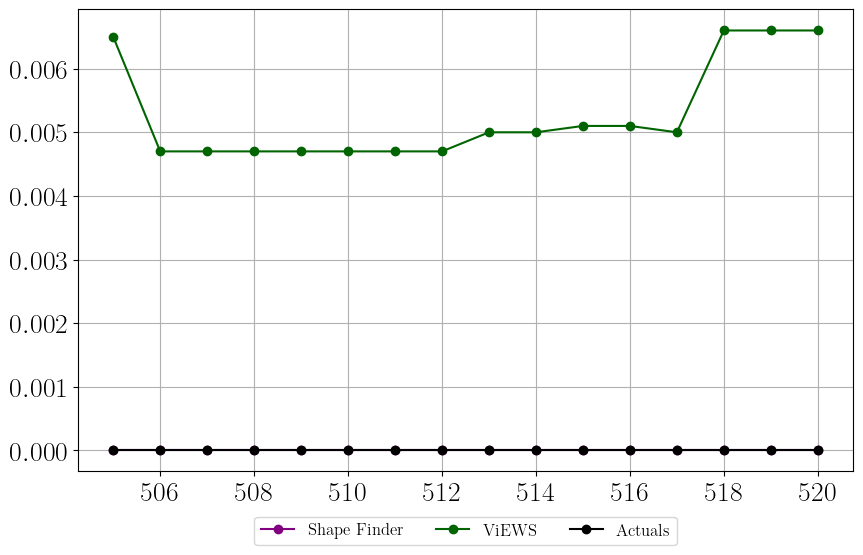

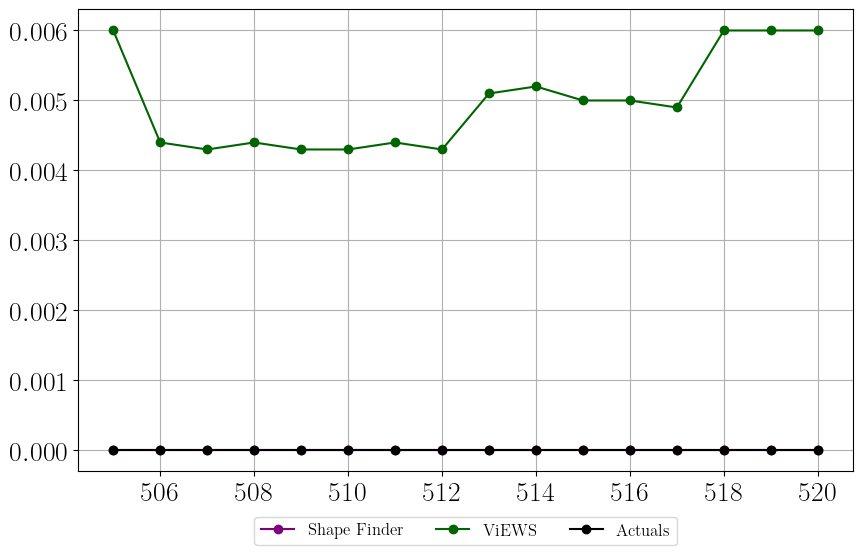

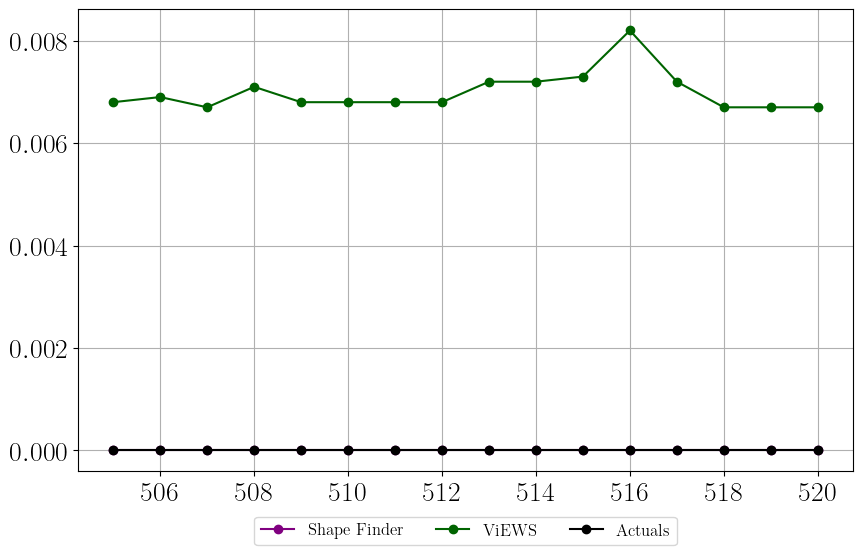

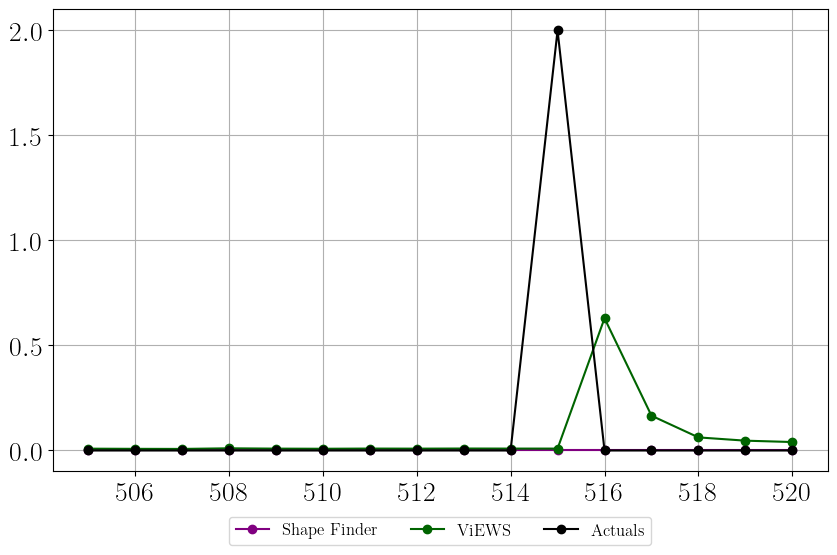

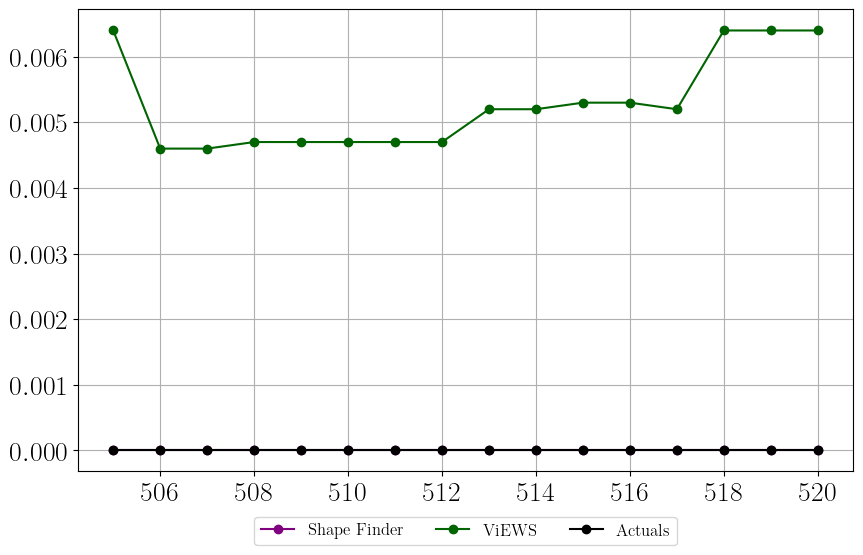

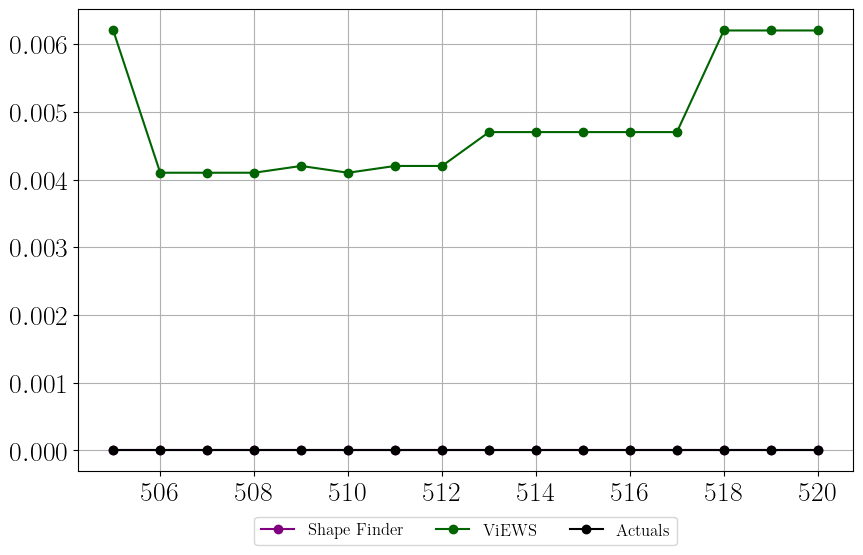

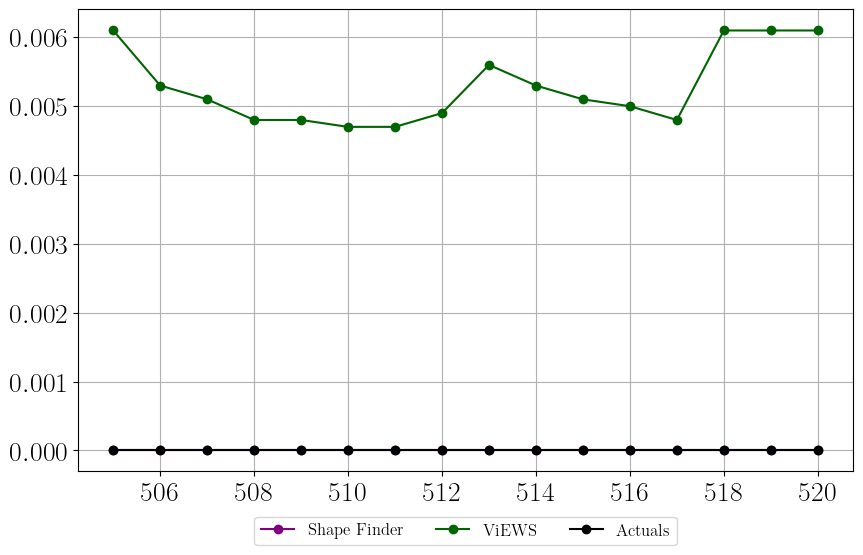

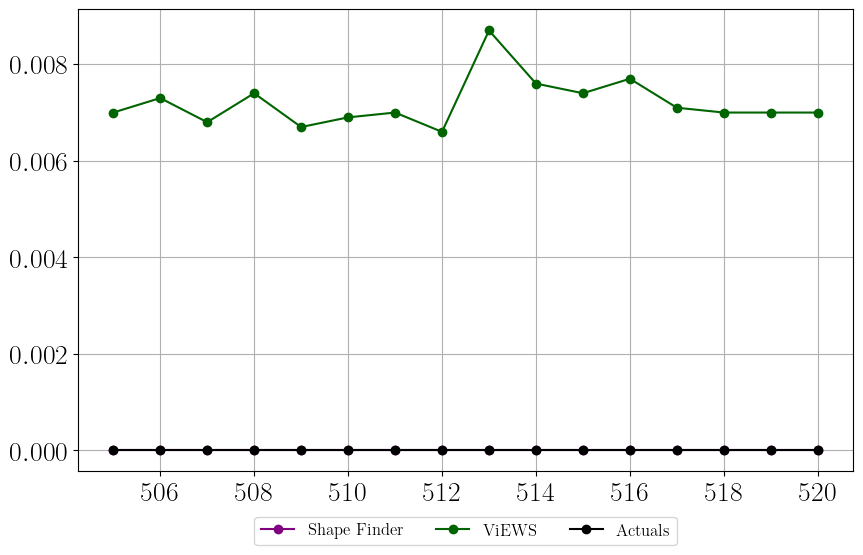

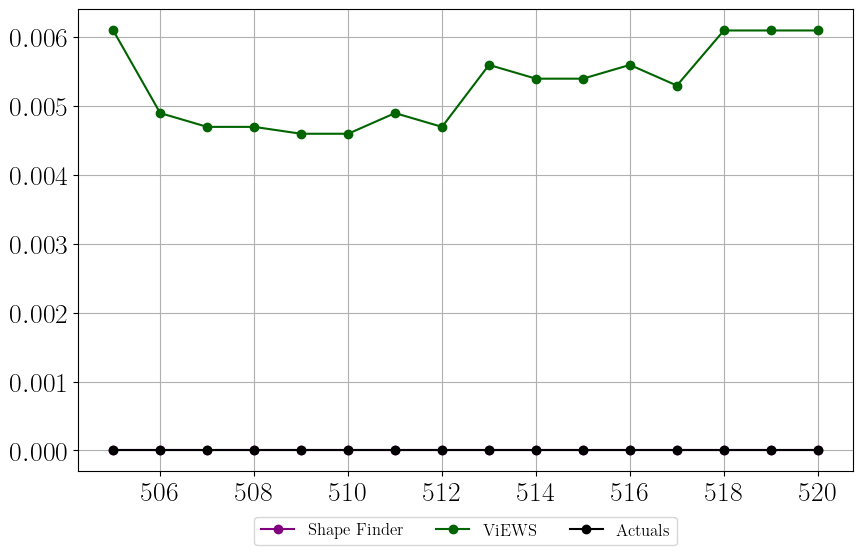

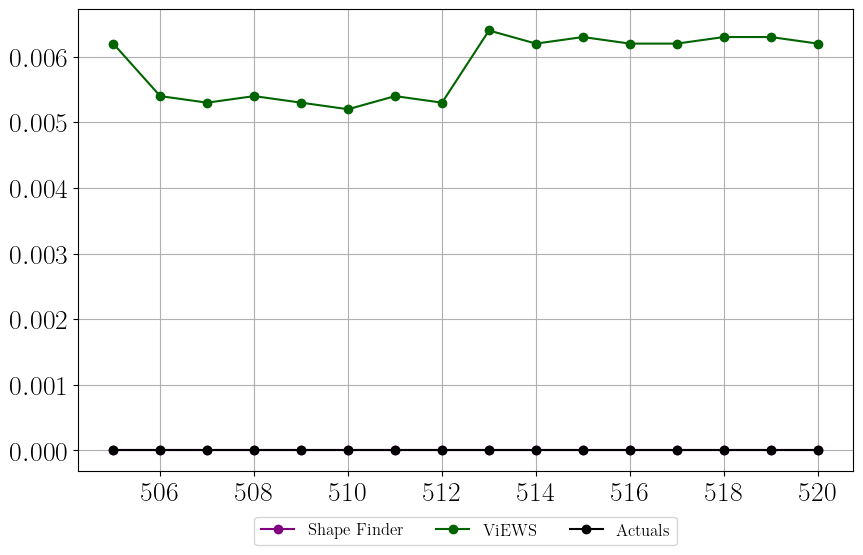

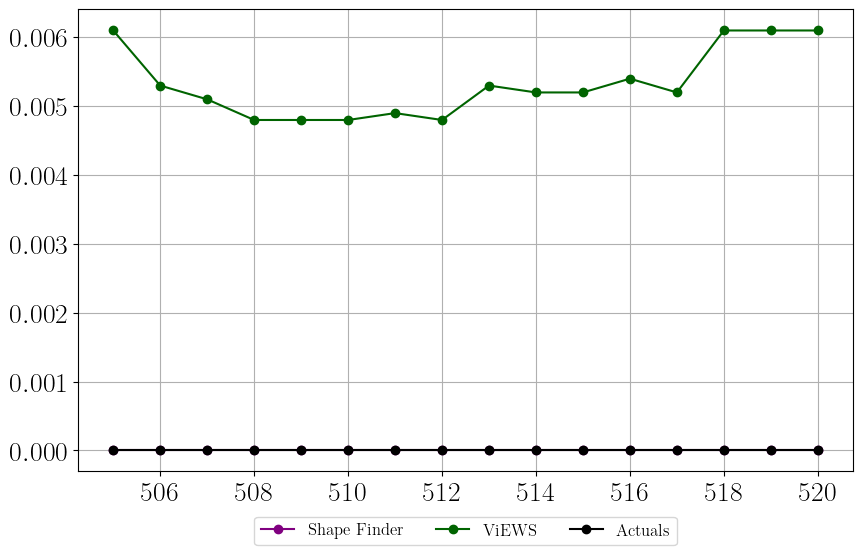

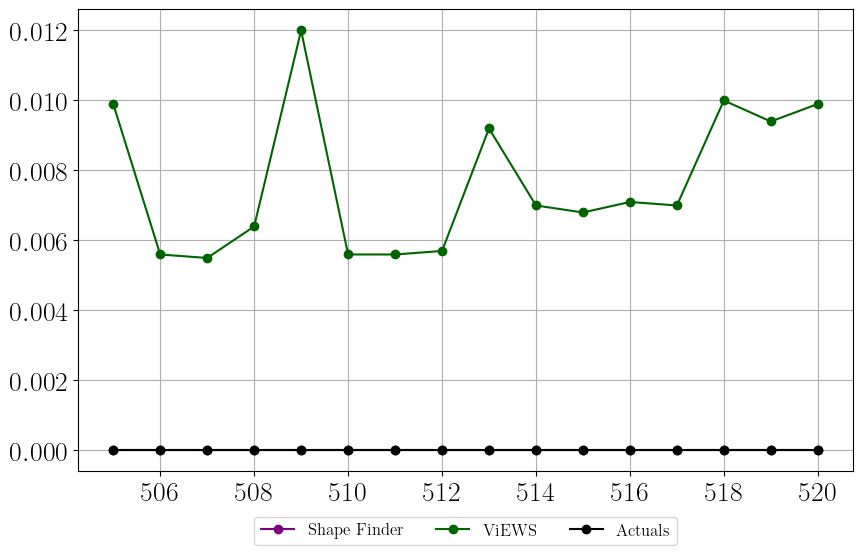

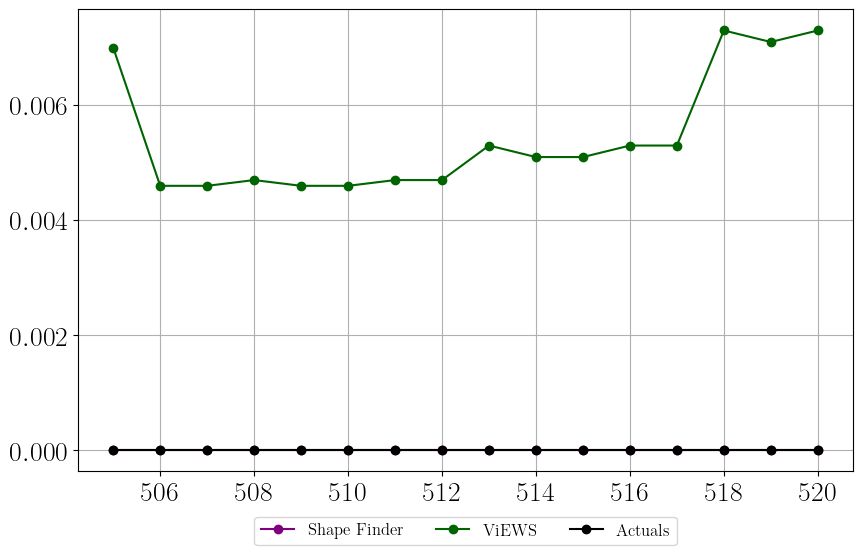

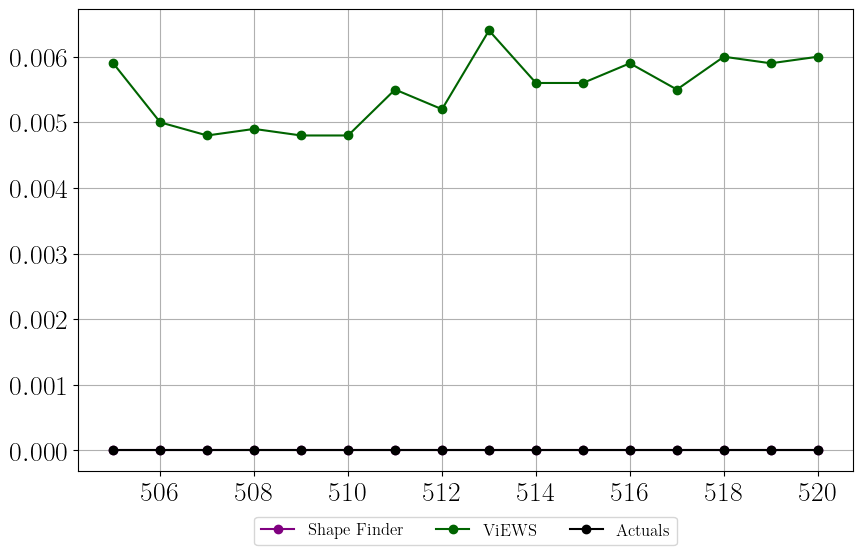

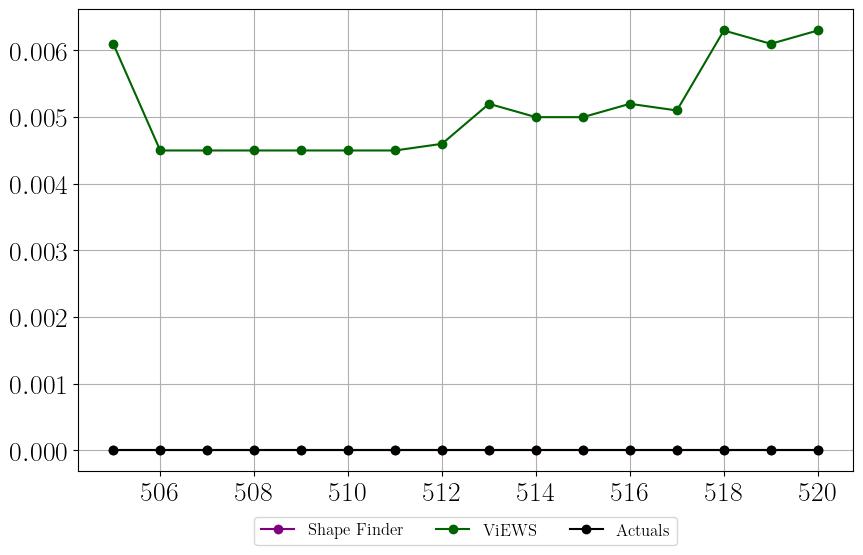

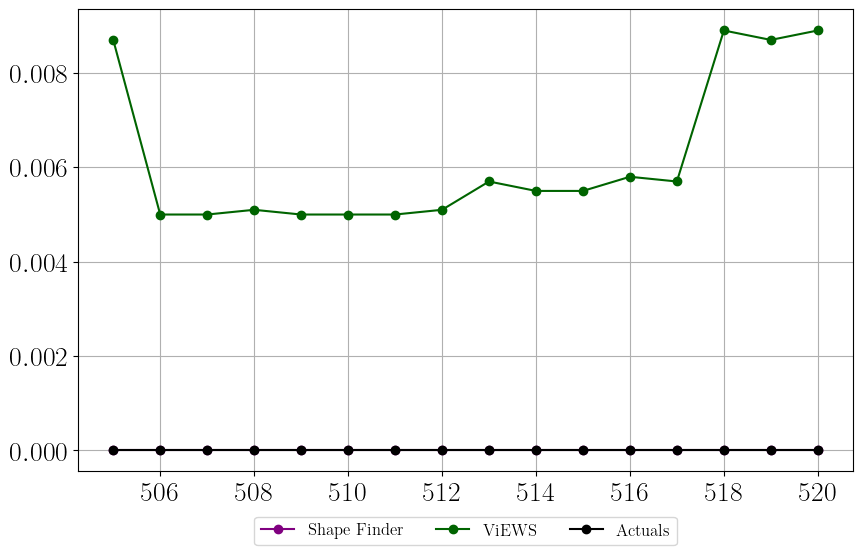

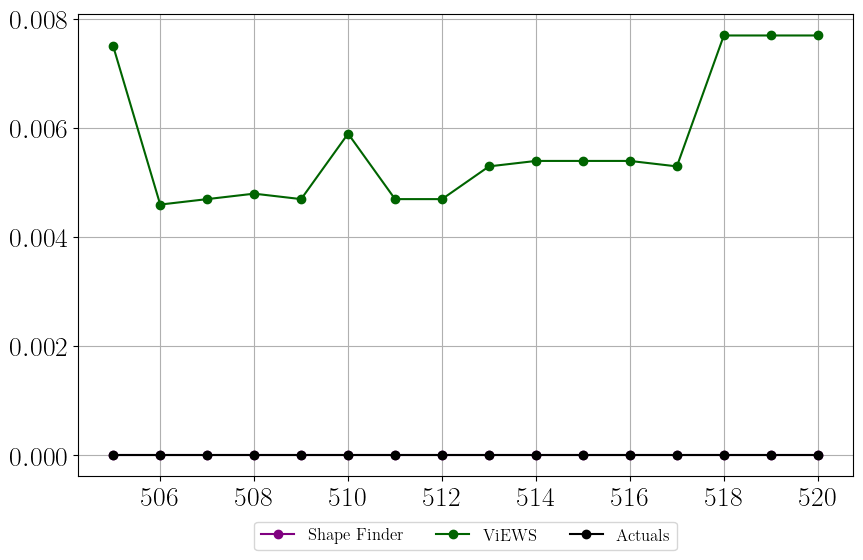

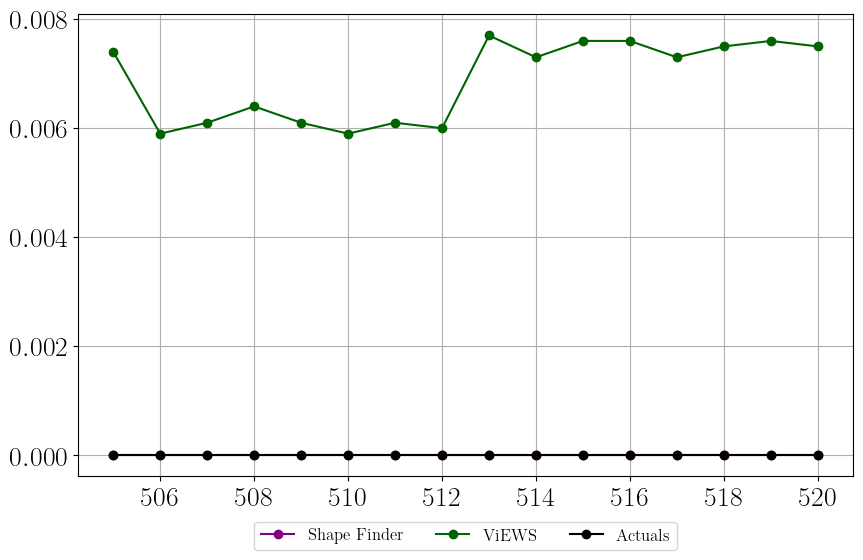

No patterns found to predict. Maybe increase the minimum distance.
No patterns found to predict. Maybe increase the minimum distance.


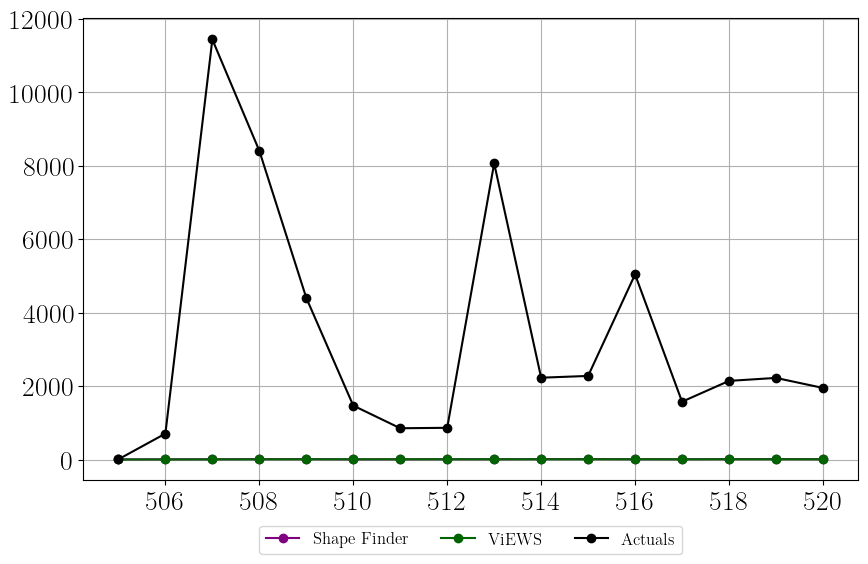

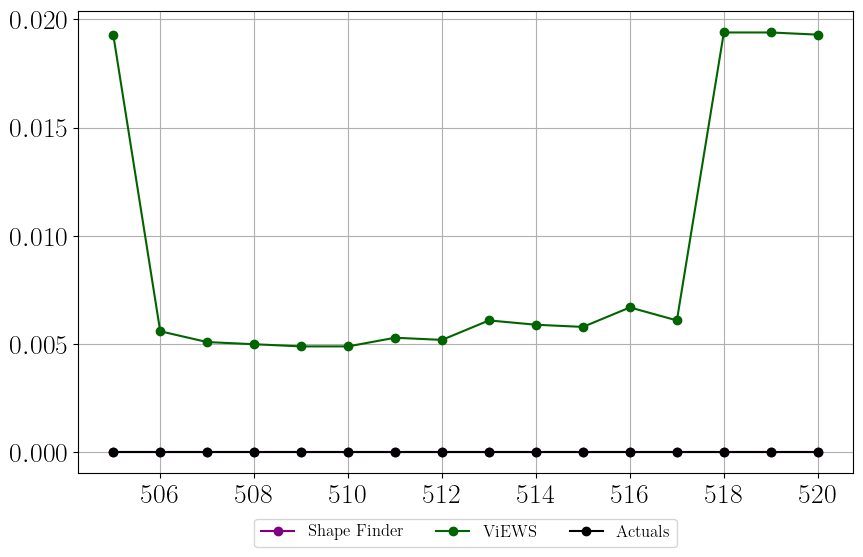

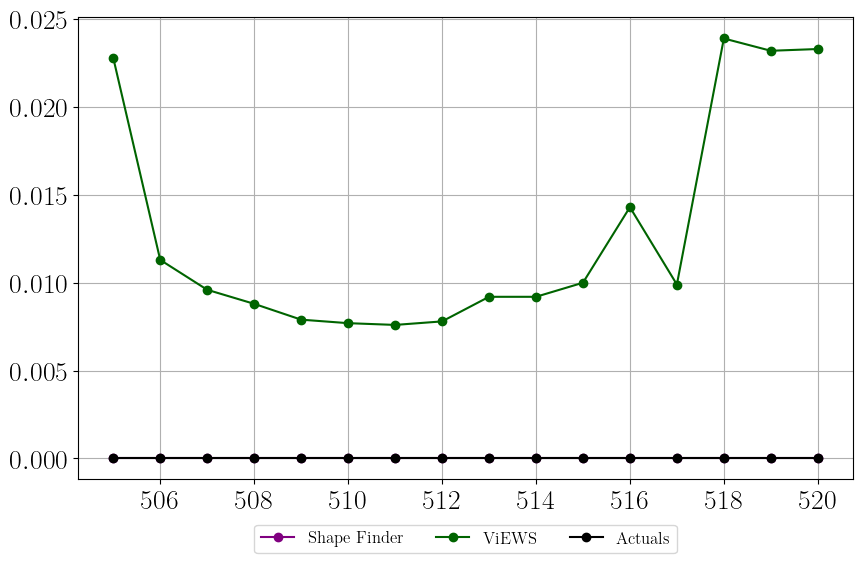

No patterns found to predict. Maybe increase the minimum distance.
No patterns found to predict. Maybe increase the minimum distance.


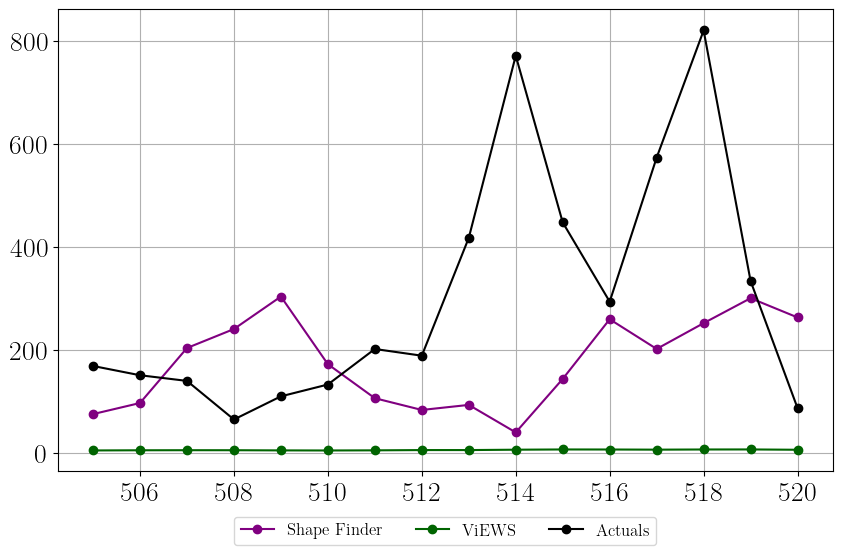

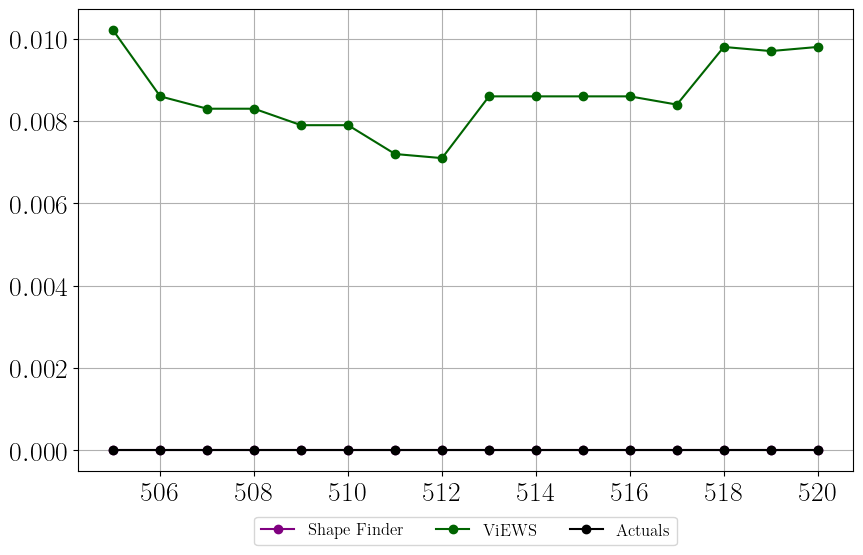

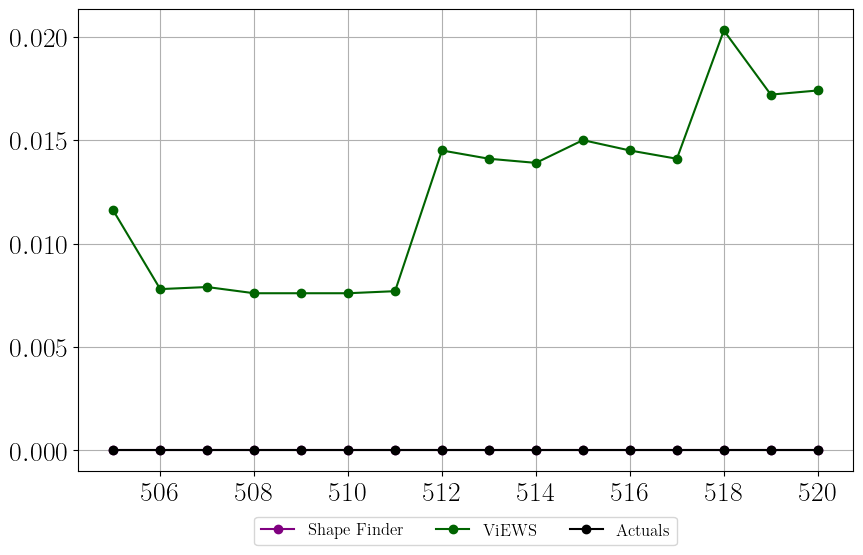

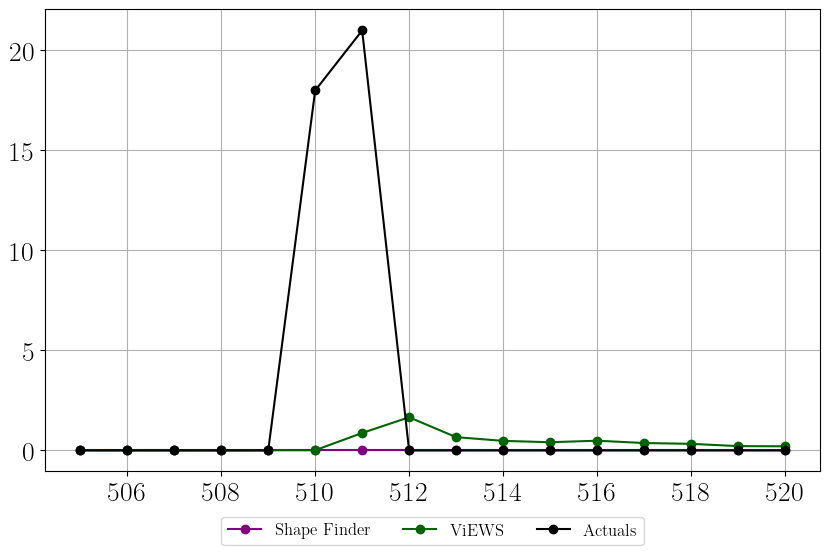

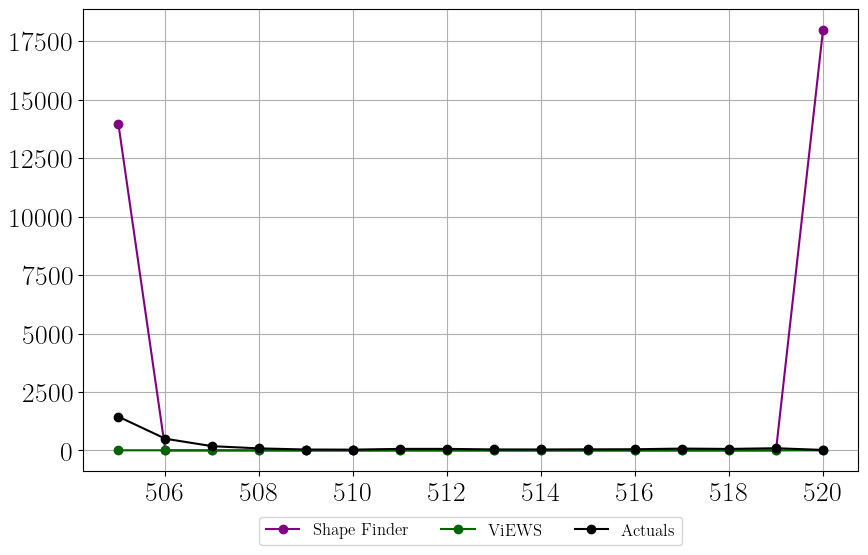

No patterns found to predict. Maybe increase the minimum distance.
No patterns found to predict. Maybe increase the minimum distance.


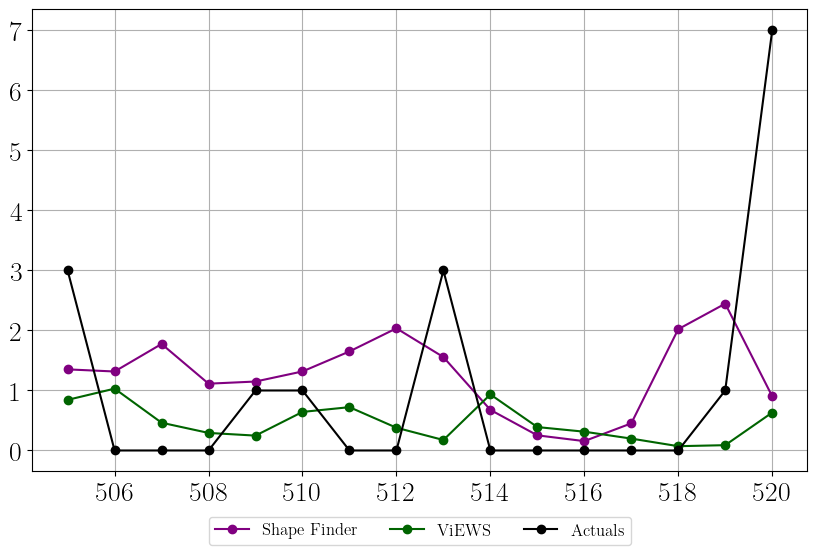

No patterns found to predict. Maybe increase the minimum distance.


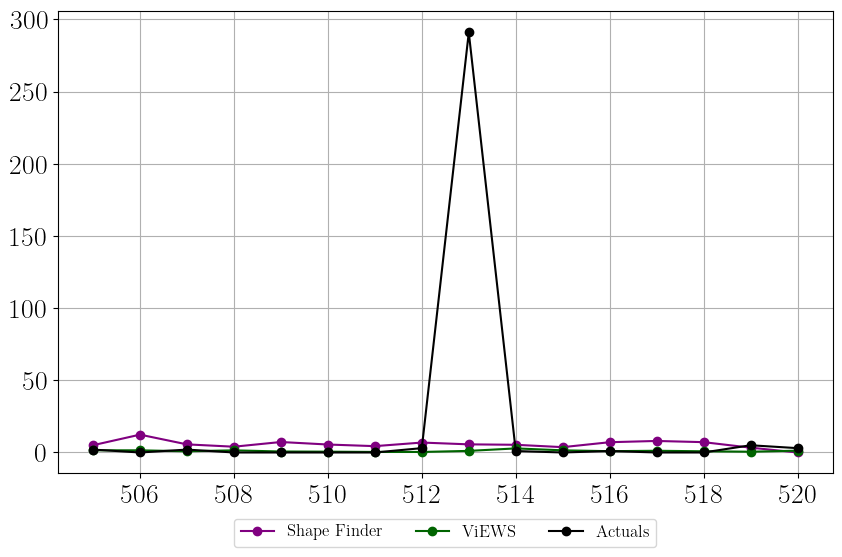

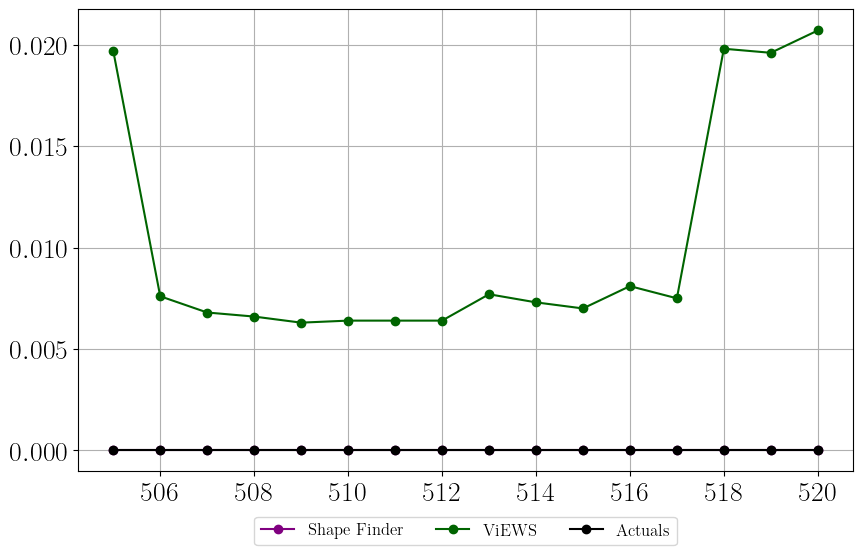

No patterns found to predict. Maybe increase the minimum distance.


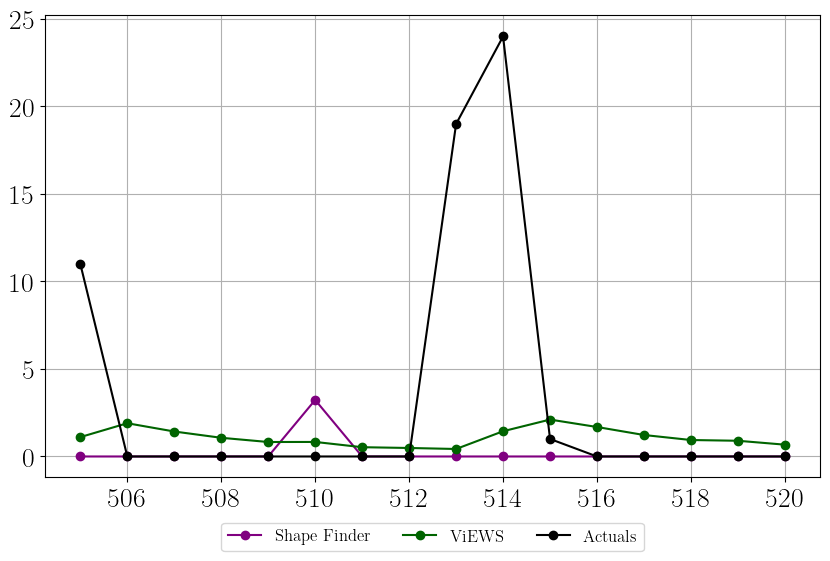

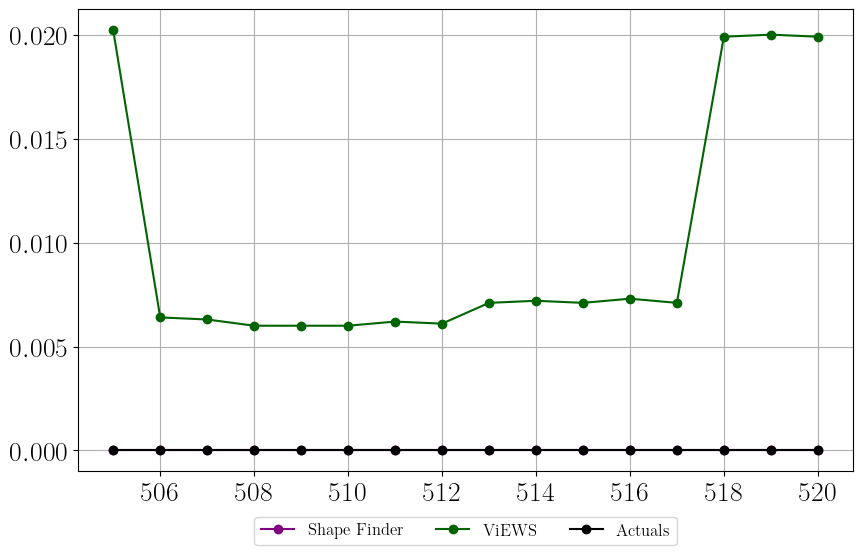

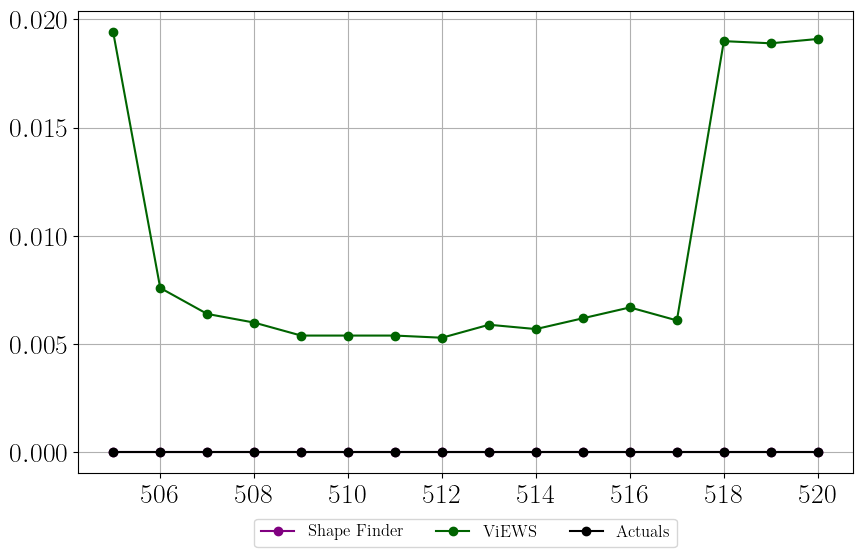

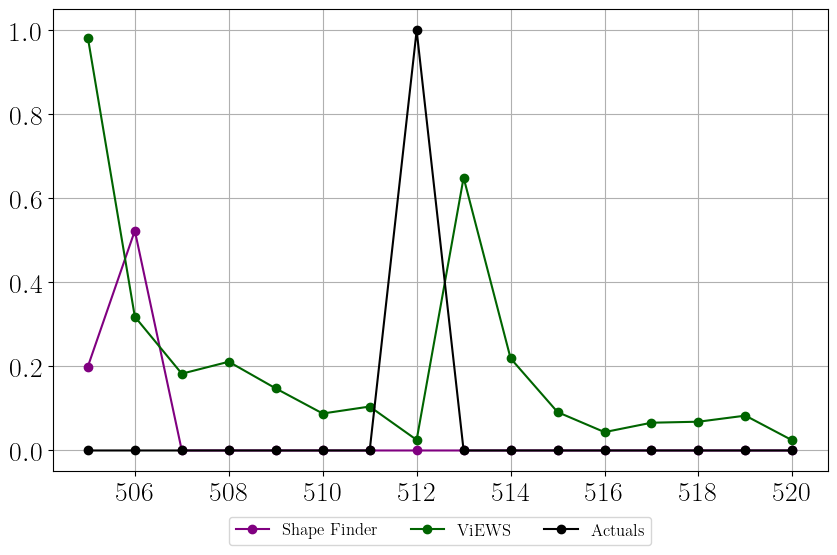

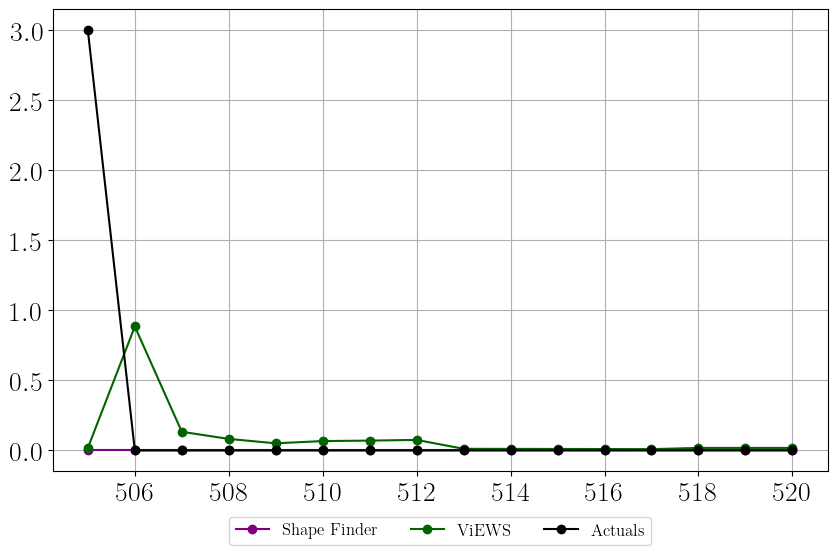

No patterns found to predict. Maybe increase the minimum distance.


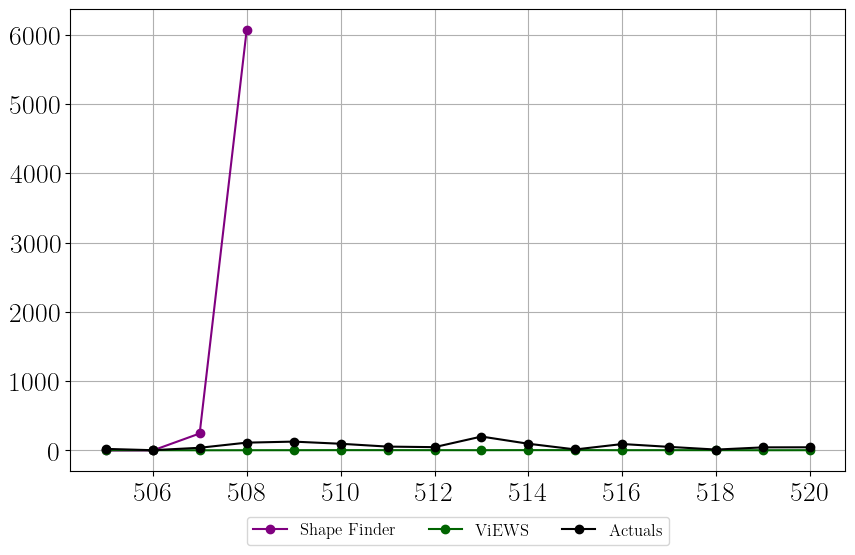

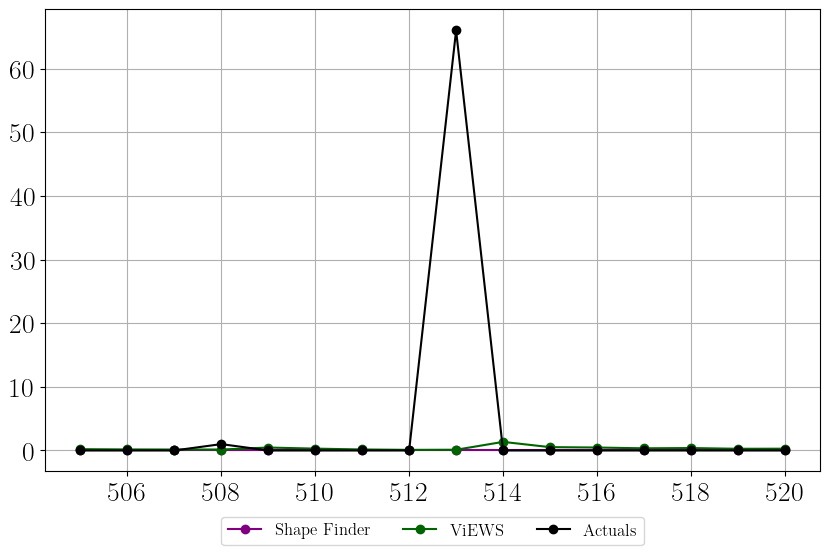

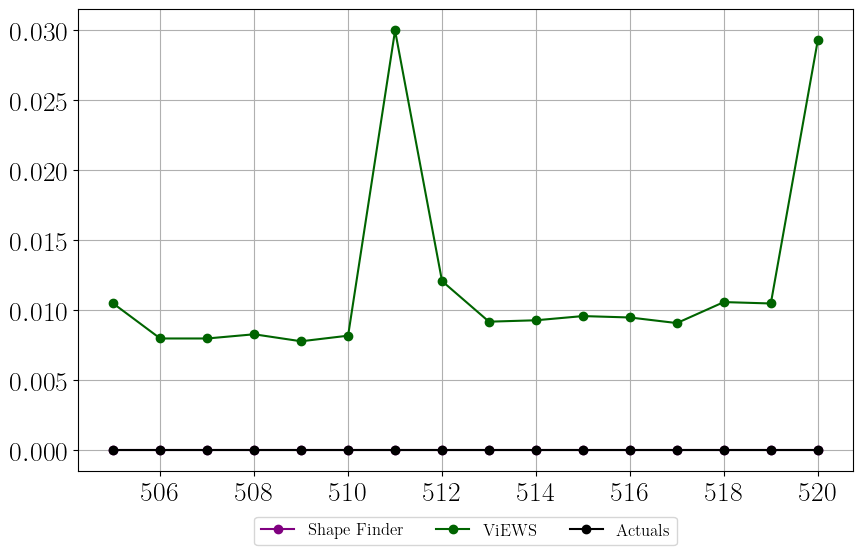

No patterns found to predict. Maybe increase the minimum distance.
No patterns found to predict. Maybe increase the minimum distance.
No patterns found to predict. Maybe increase the minimum distance.


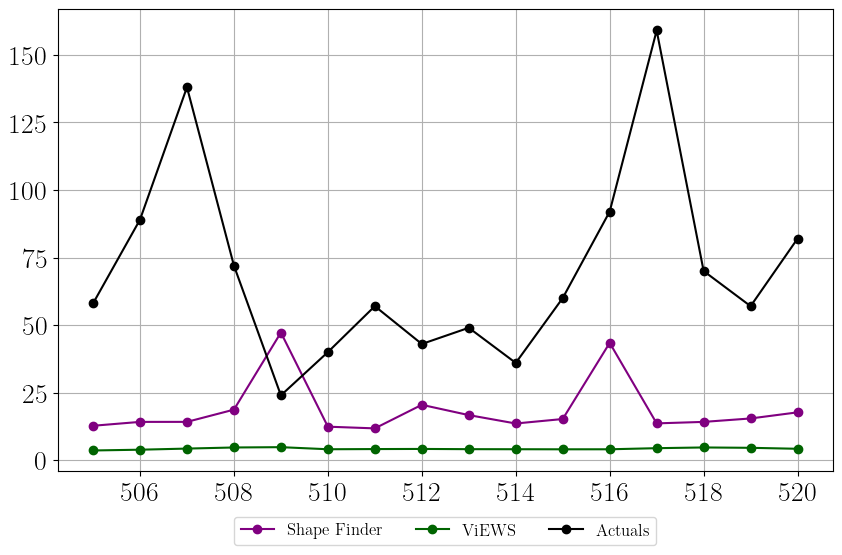

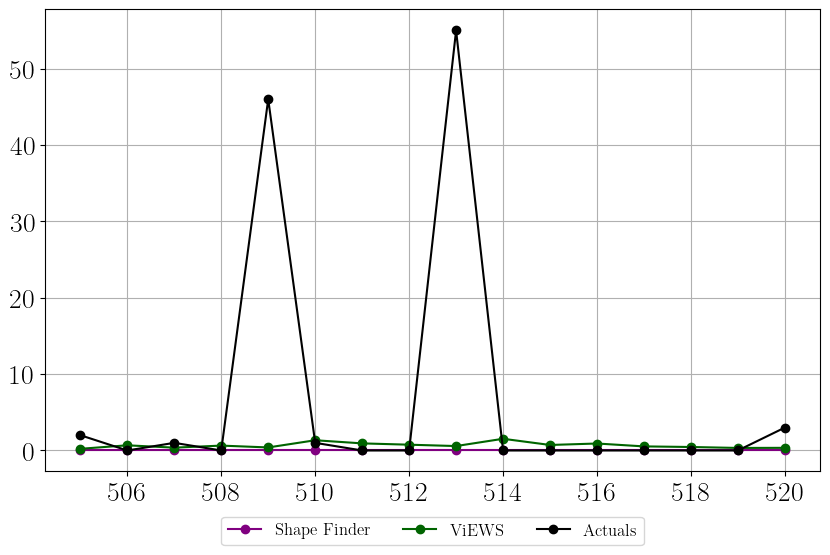

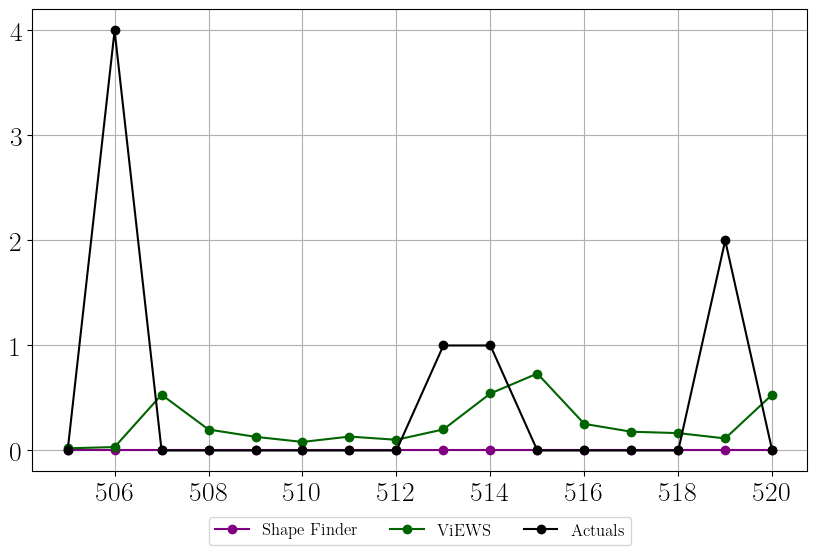

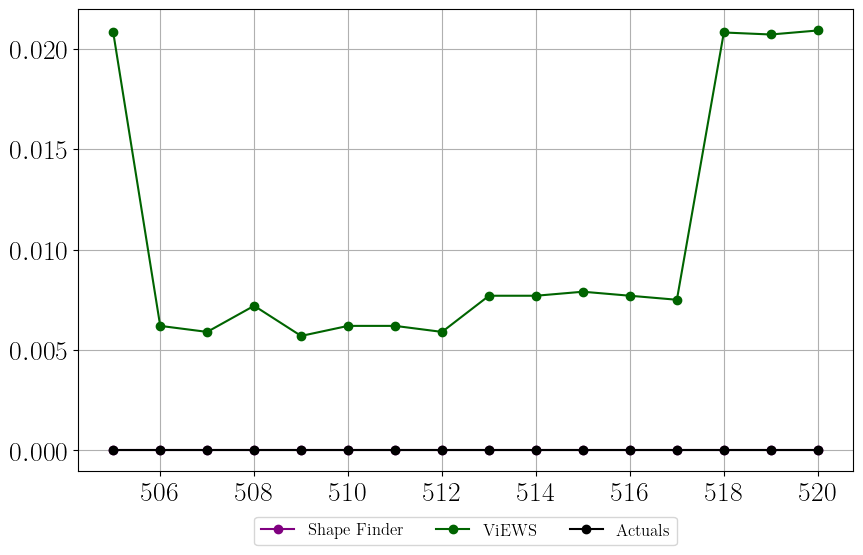

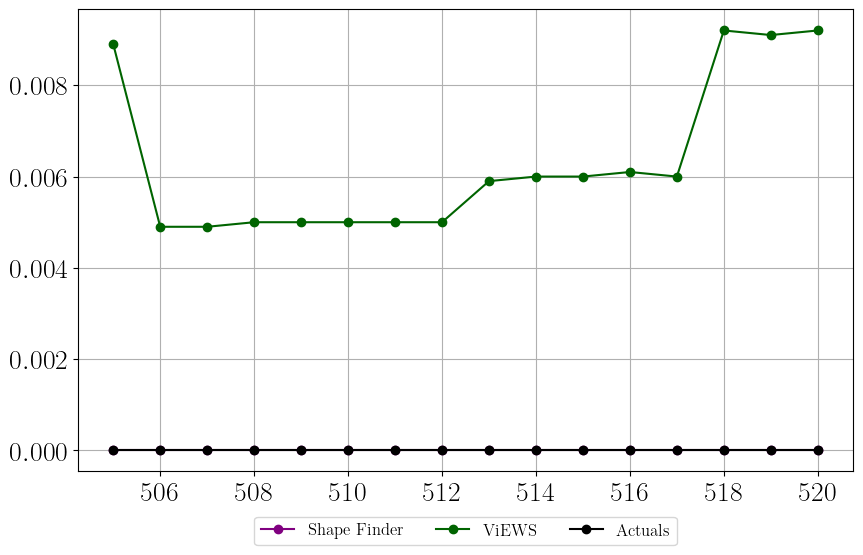

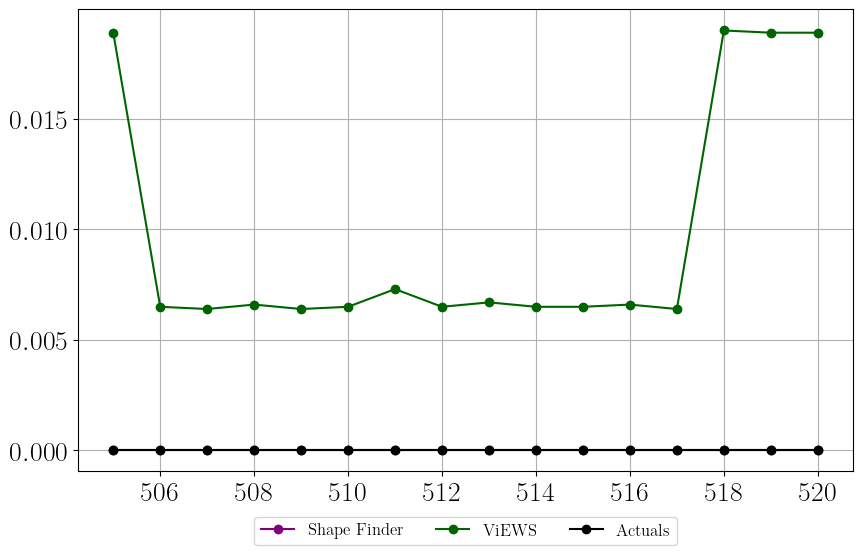

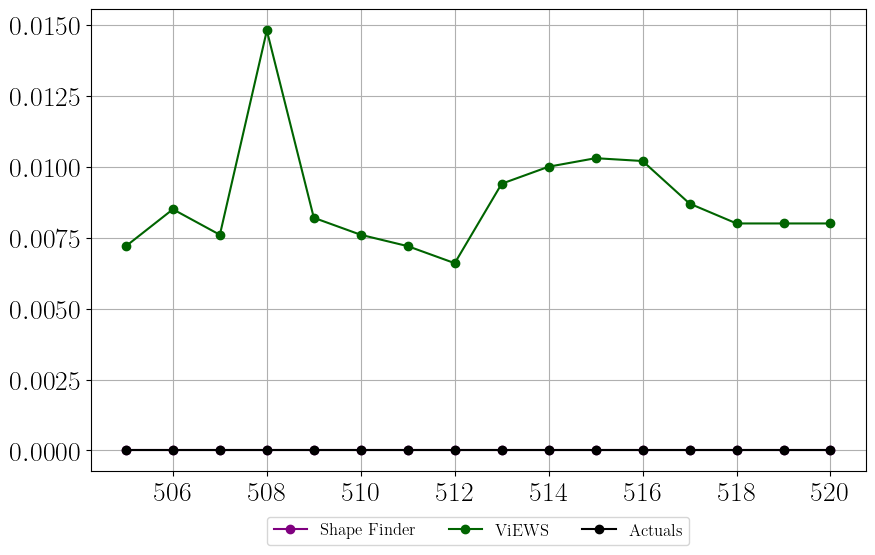

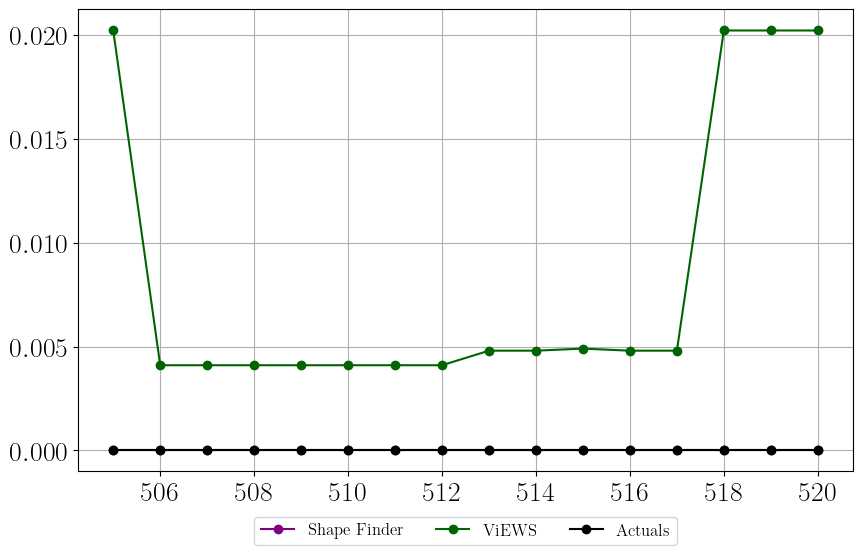

No patterns found to predict. Maybe increase the minimum distance.
No patterns found to predict. Maybe increase the minimum distance.


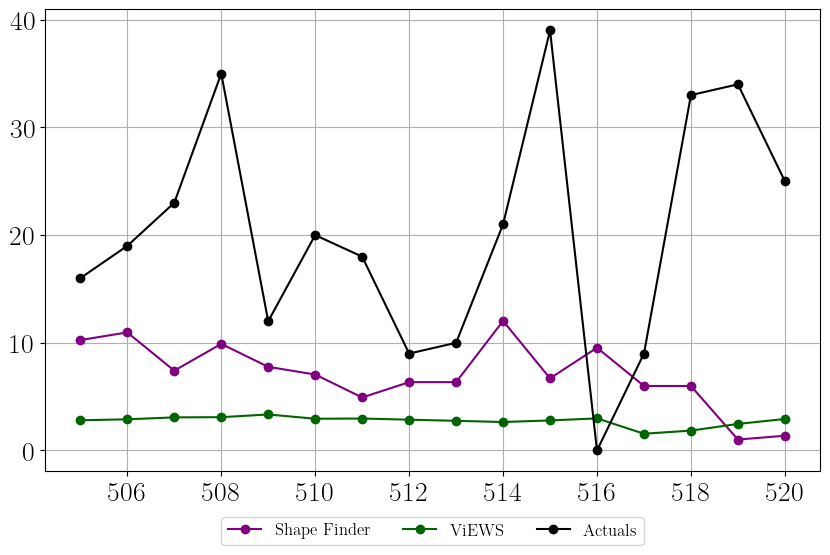

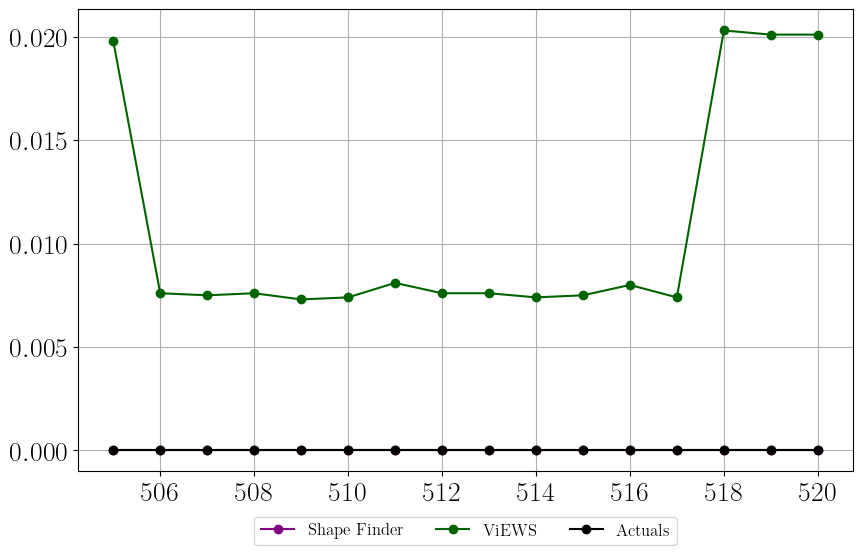

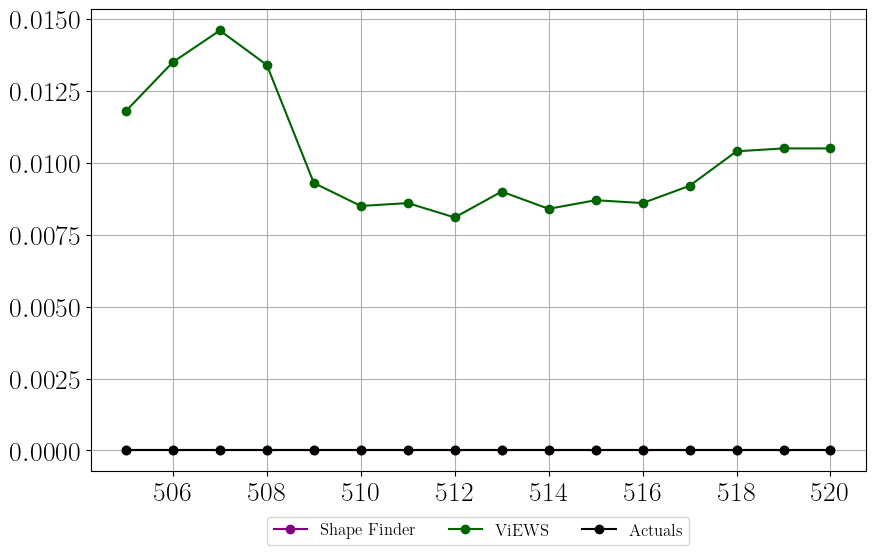

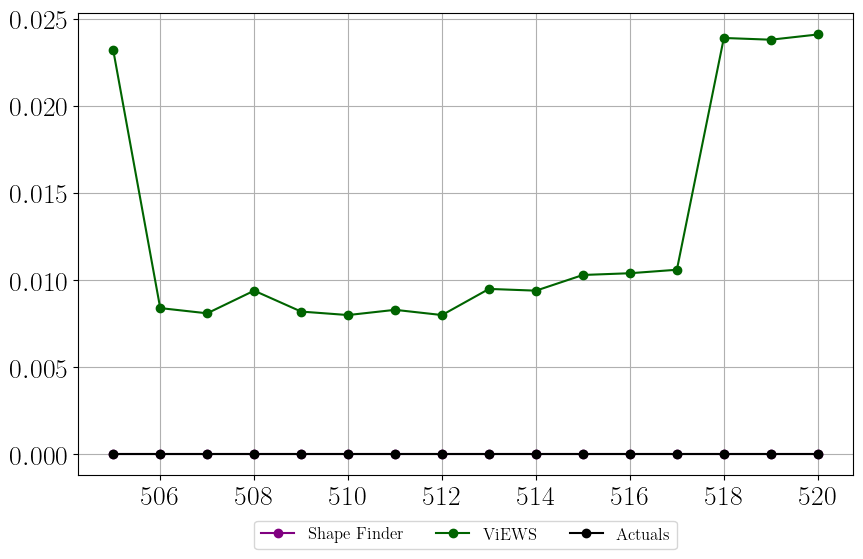

No patterns found to predict. Maybe increase the minimum distance.
No patterns found to predict. Maybe increase the minimum distance.
No patterns found to predict. Maybe increase the minimum distance.


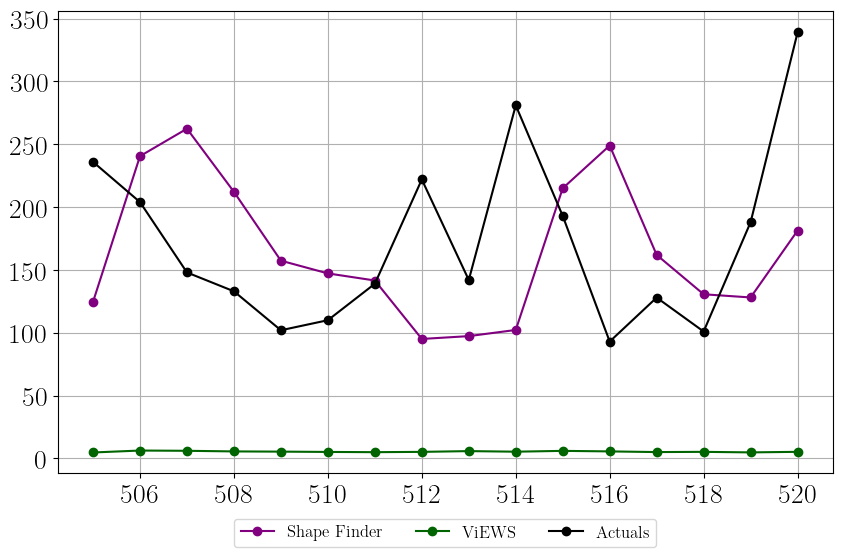

No patterns found to predict. Maybe increase the minimum distance.
No patterns found to predict. Maybe increase the minimum distance.
No patterns found to predict. Maybe increase the minimum distance.


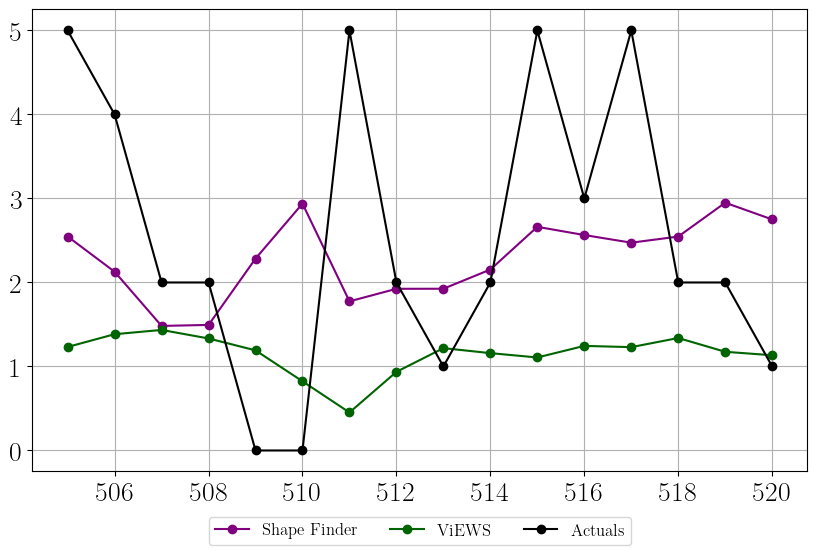

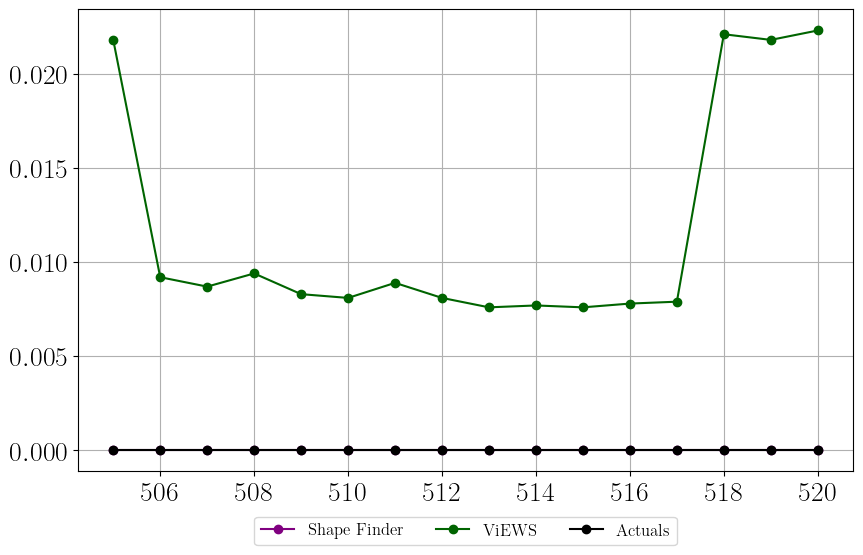

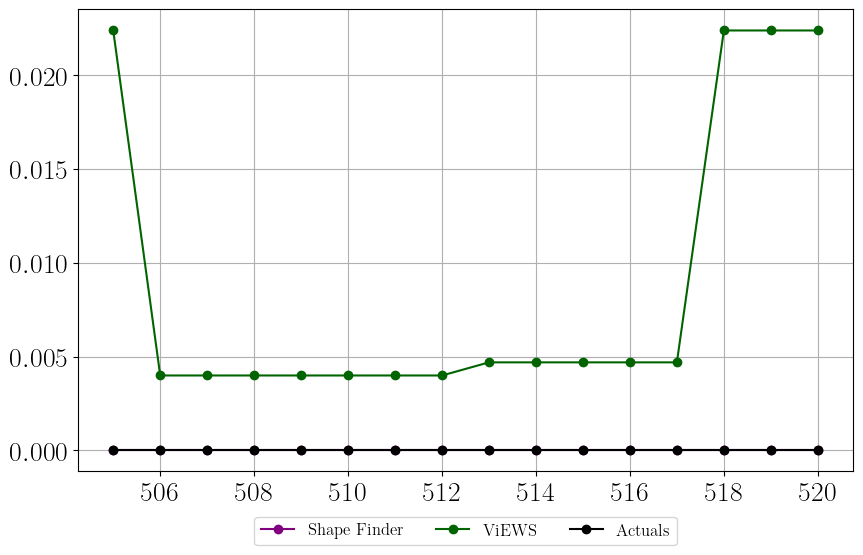

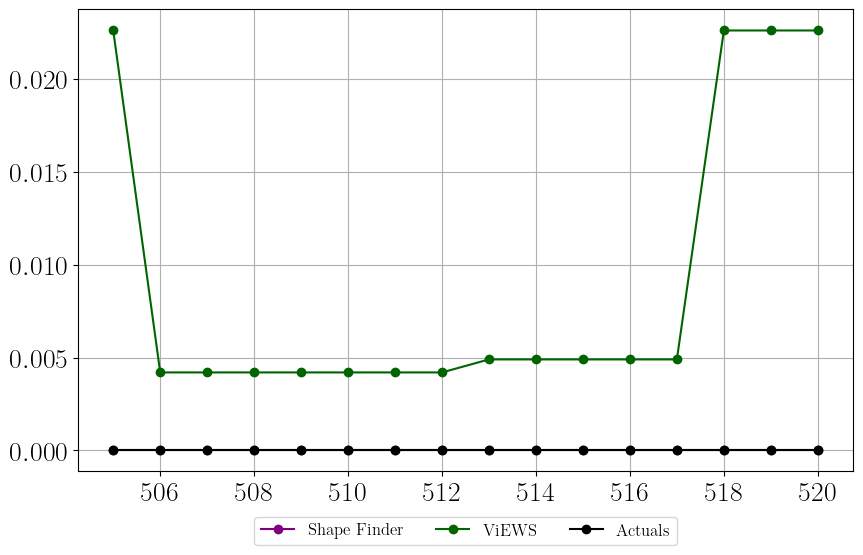

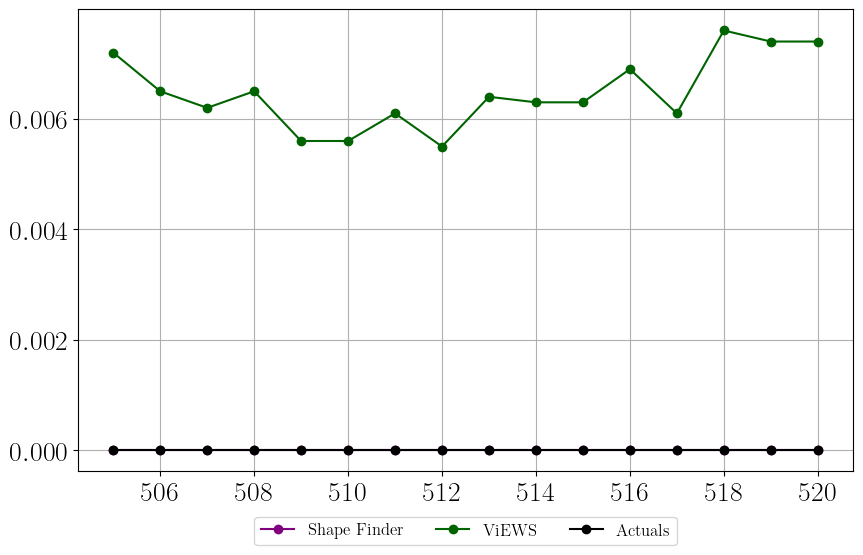

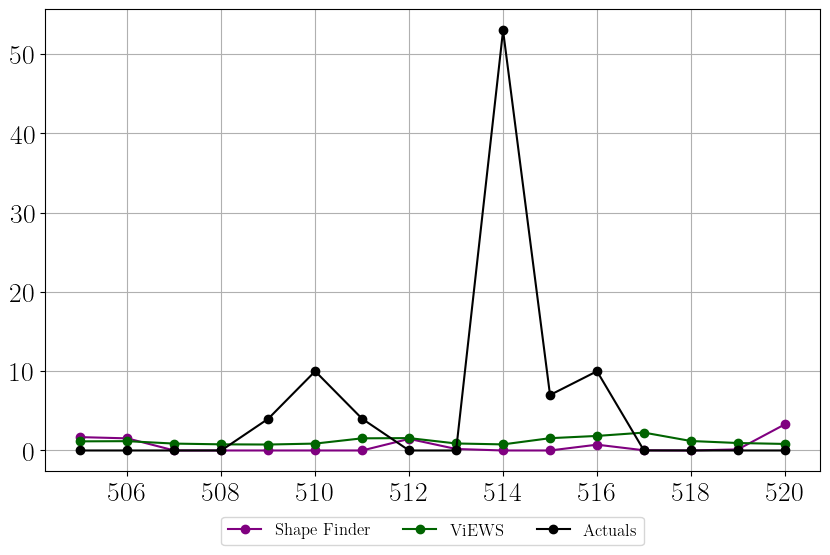

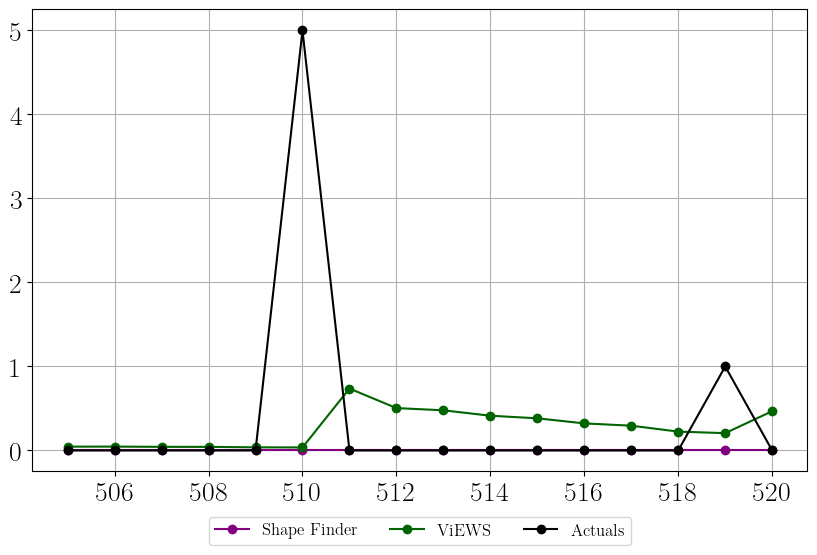

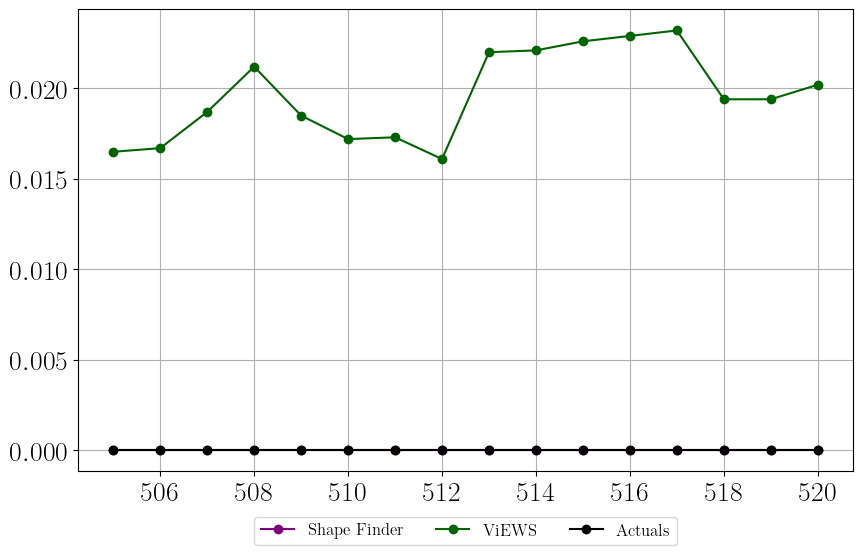

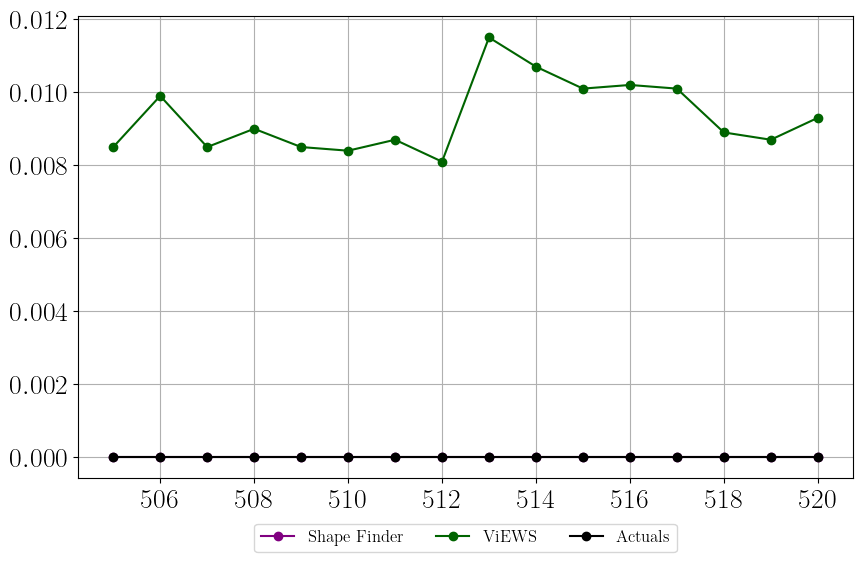

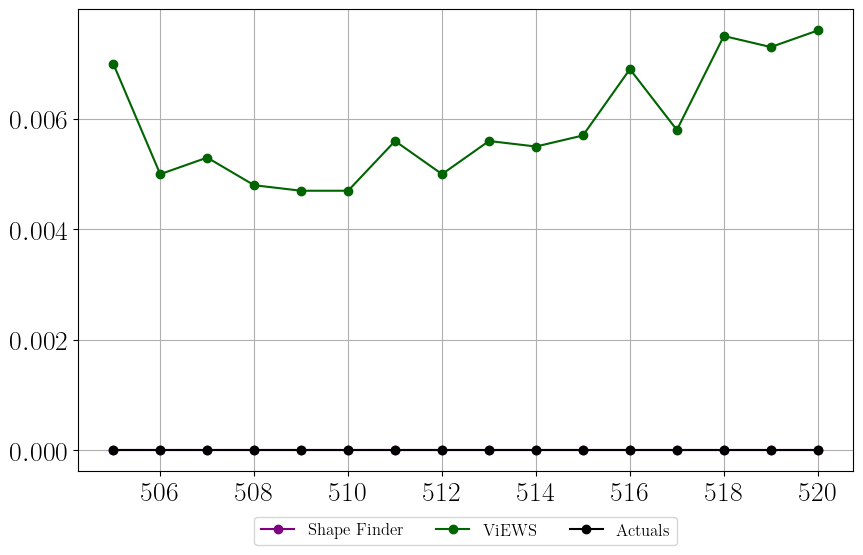

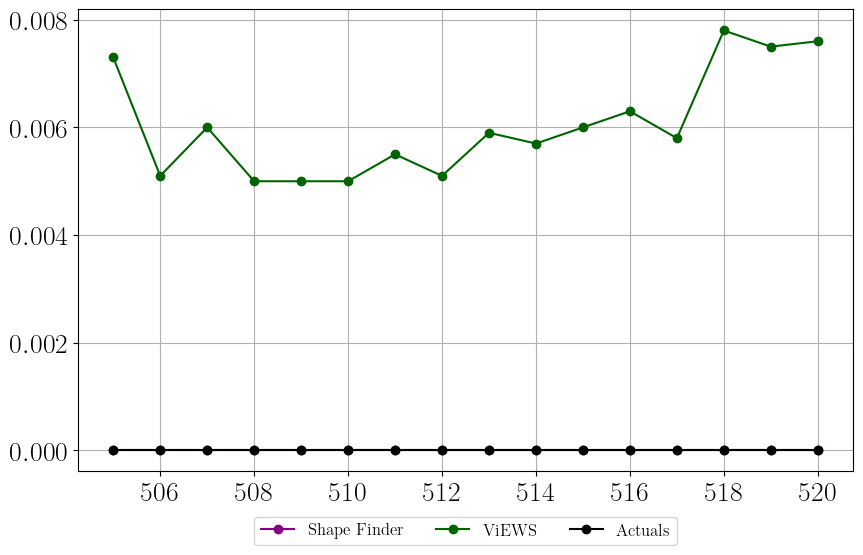

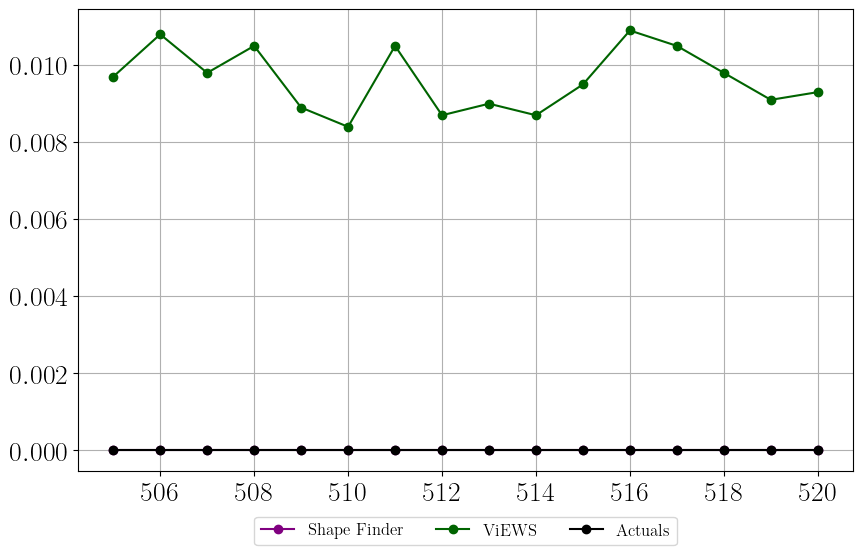

No patterns found to predict. Maybe increase the minimum distance.


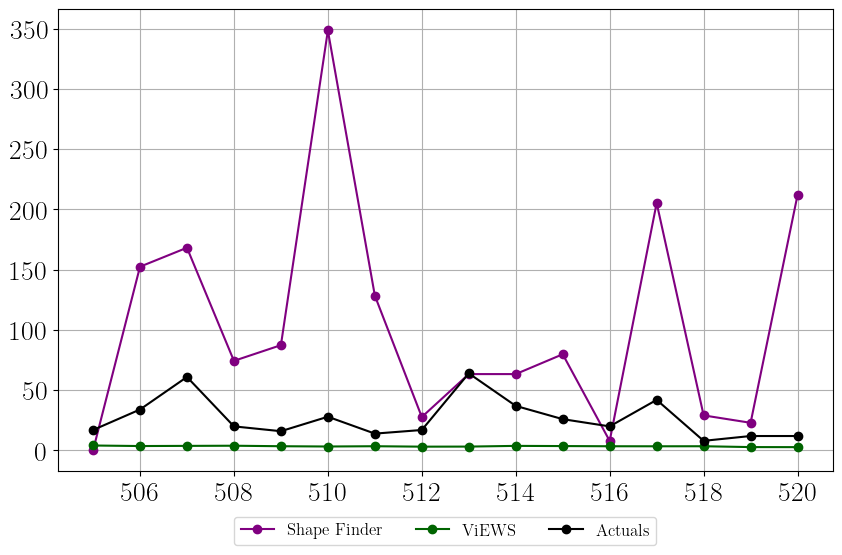

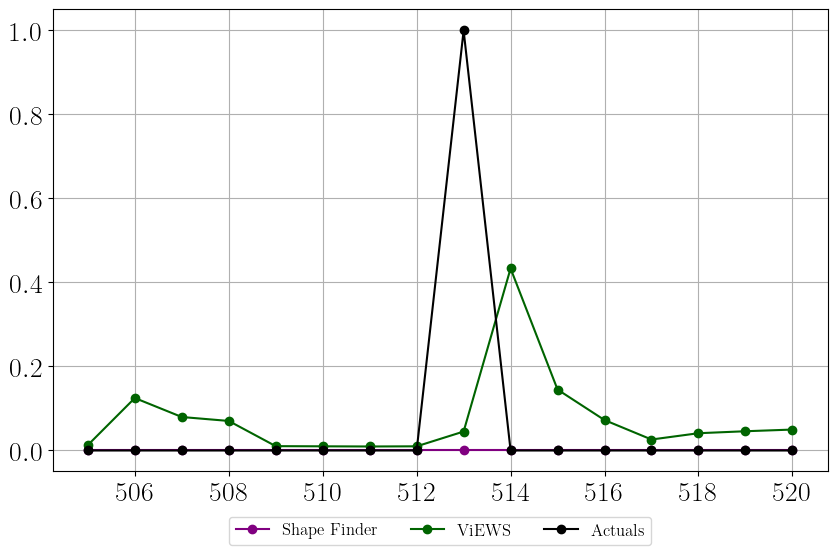

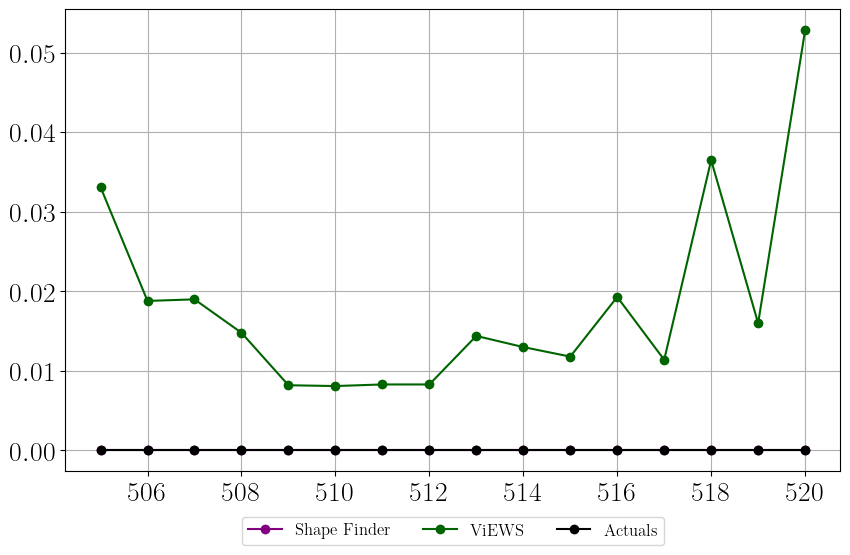

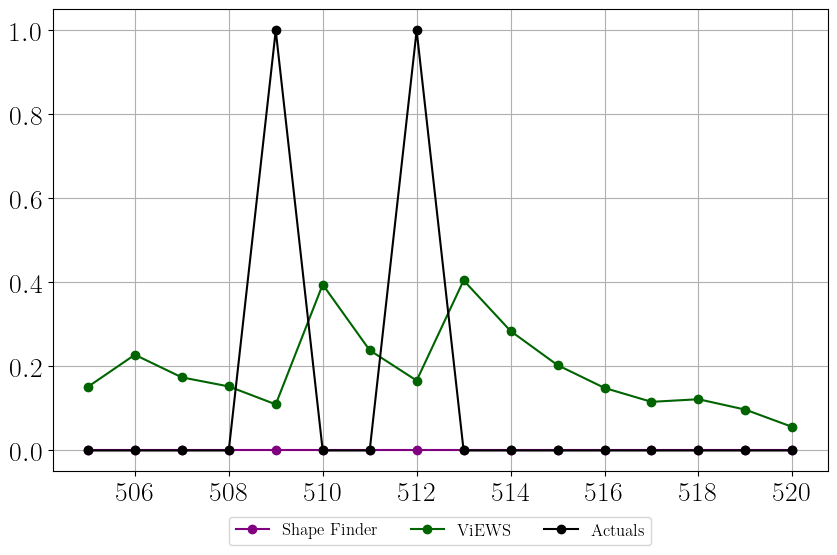

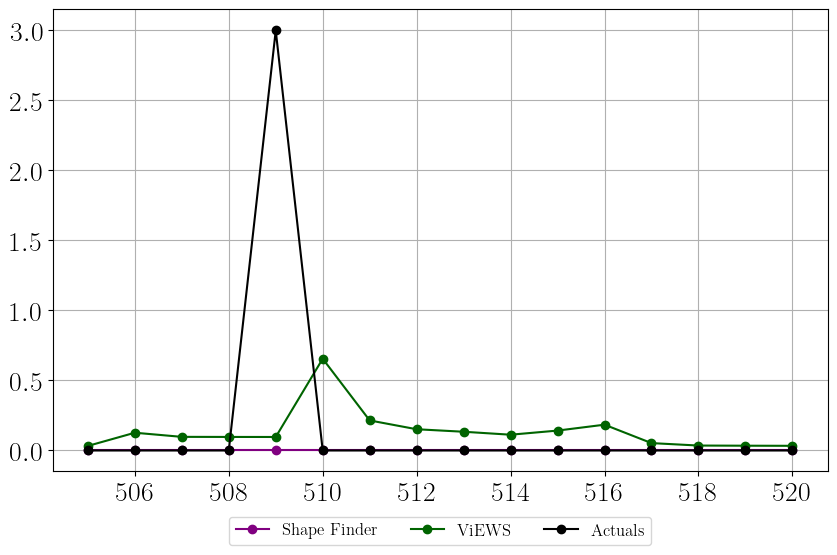

No patterns found to predict. Maybe increase the minimum distance.
No patterns found to predict. Maybe increase the minimum distance.


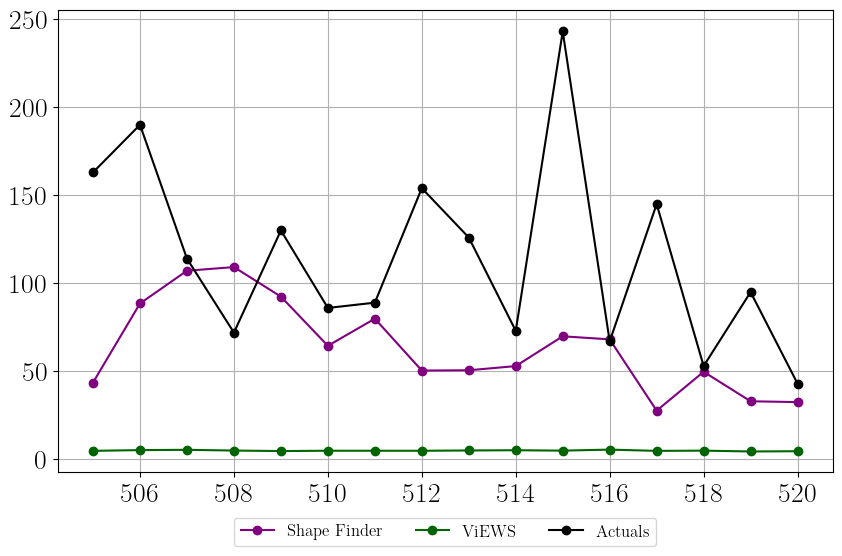

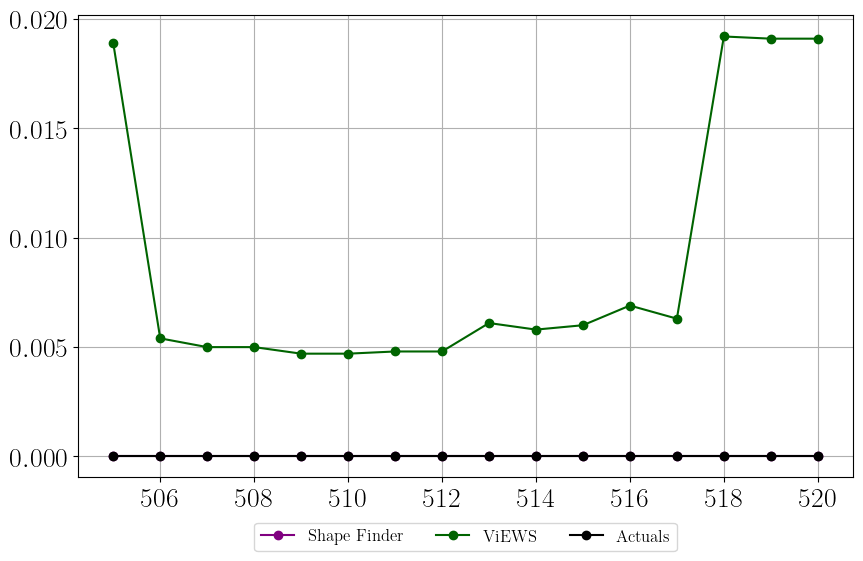

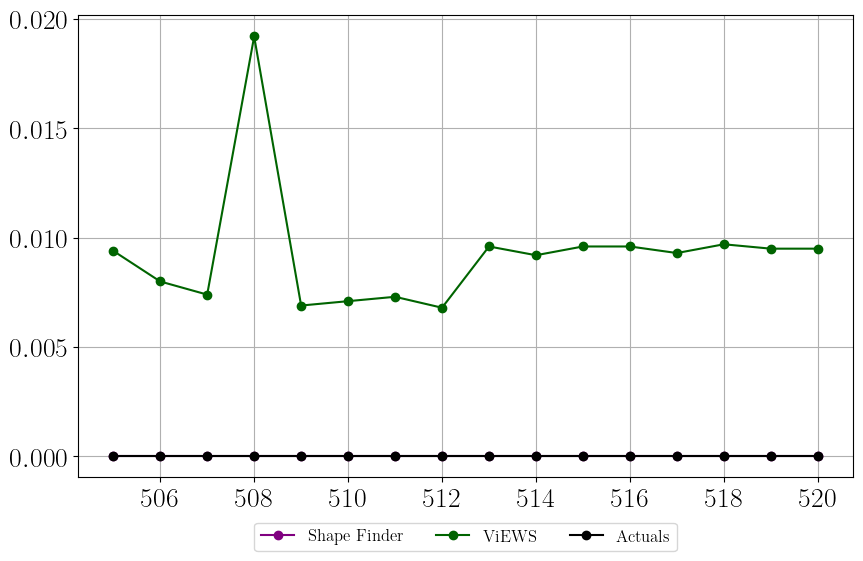

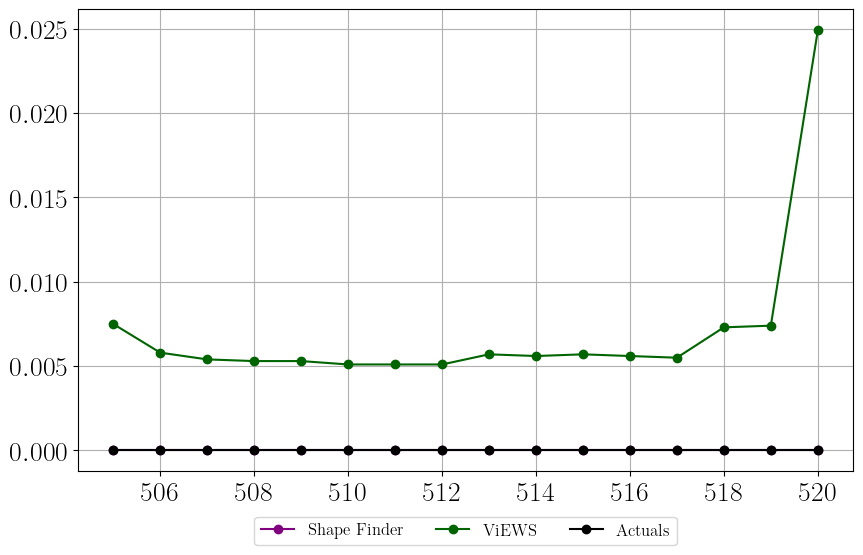

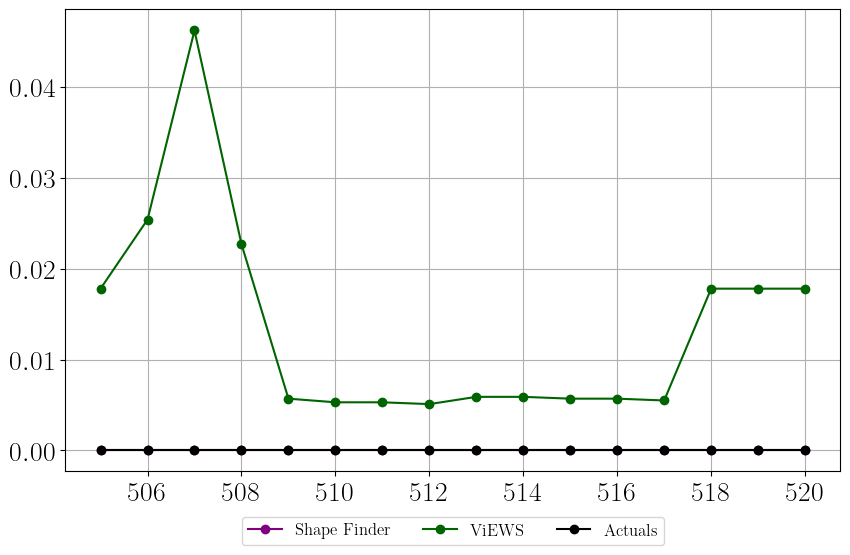

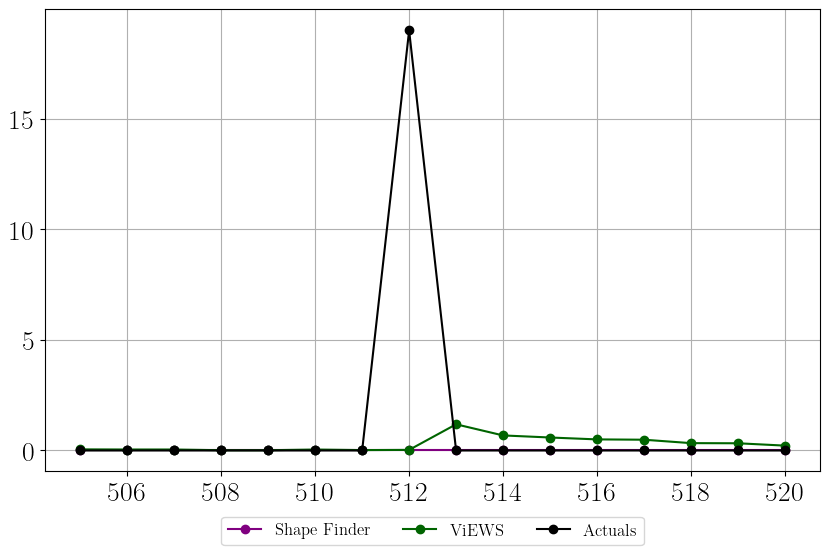

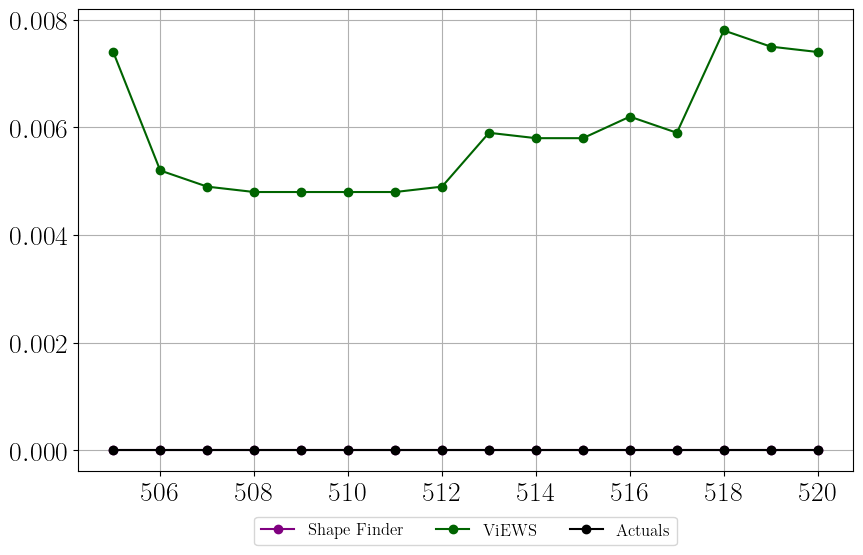

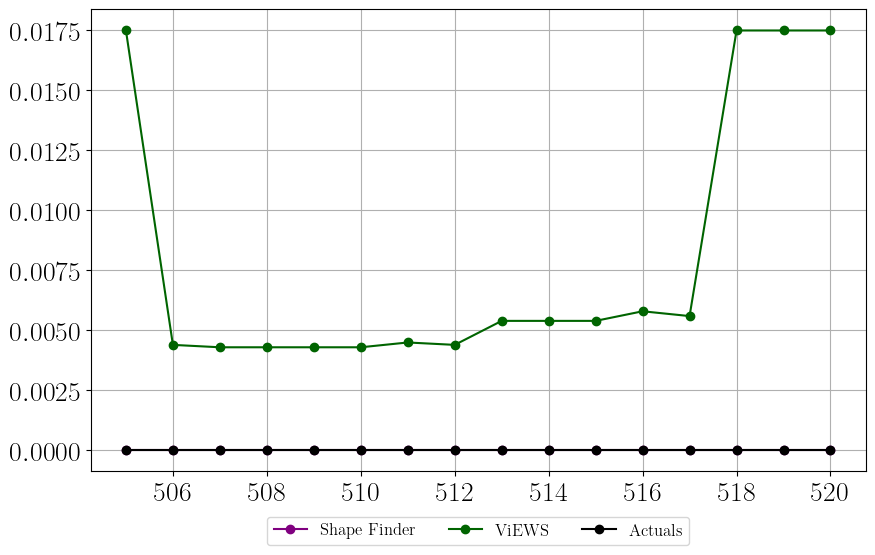

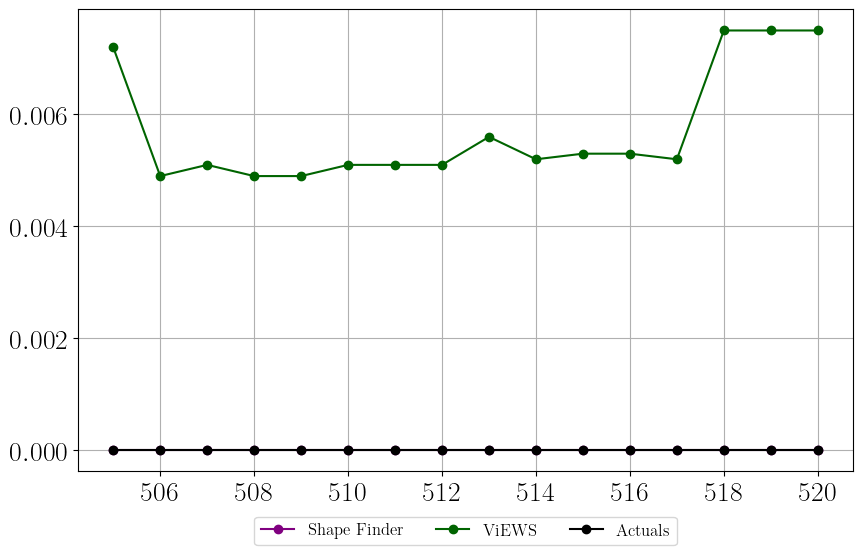

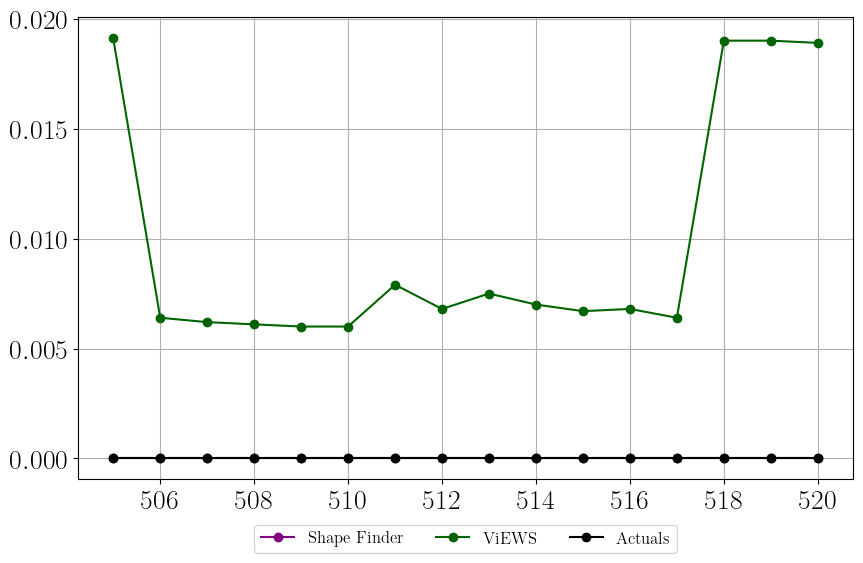

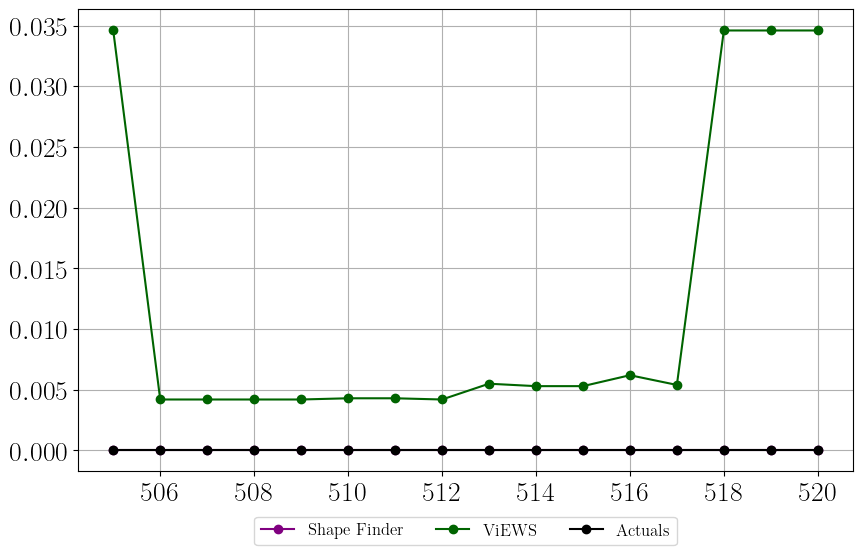

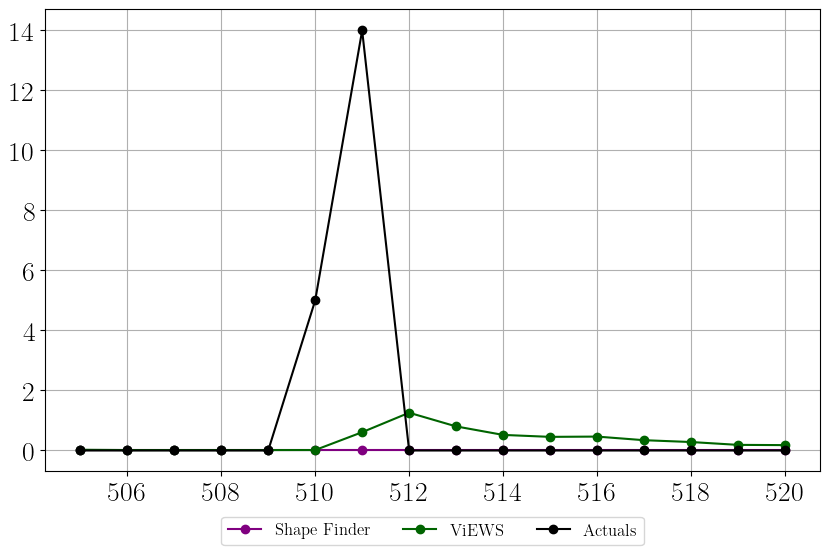

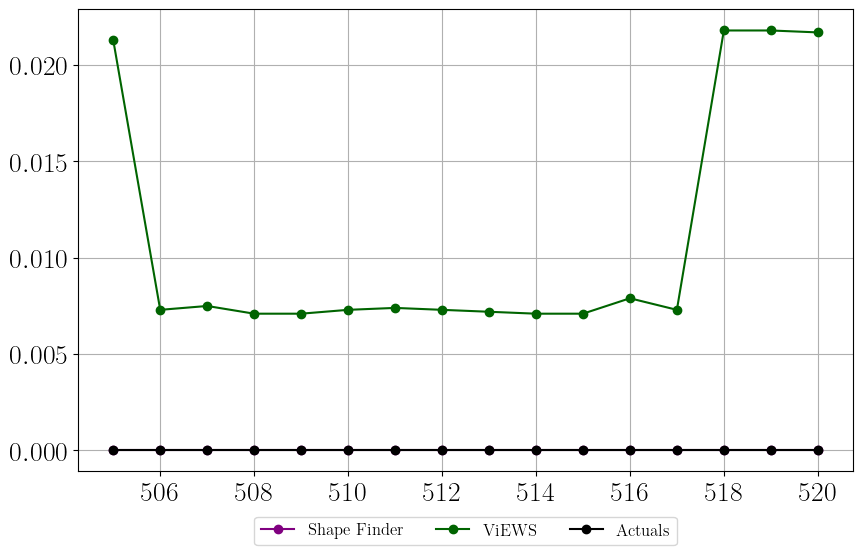

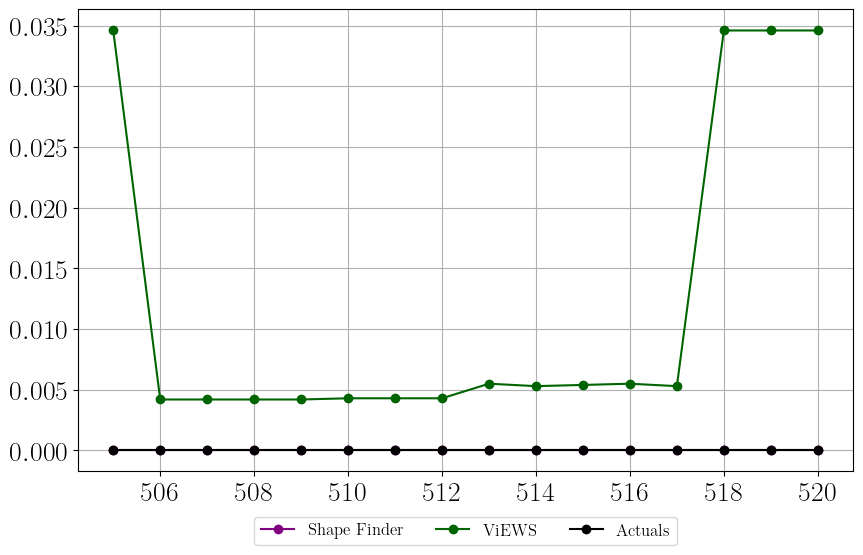

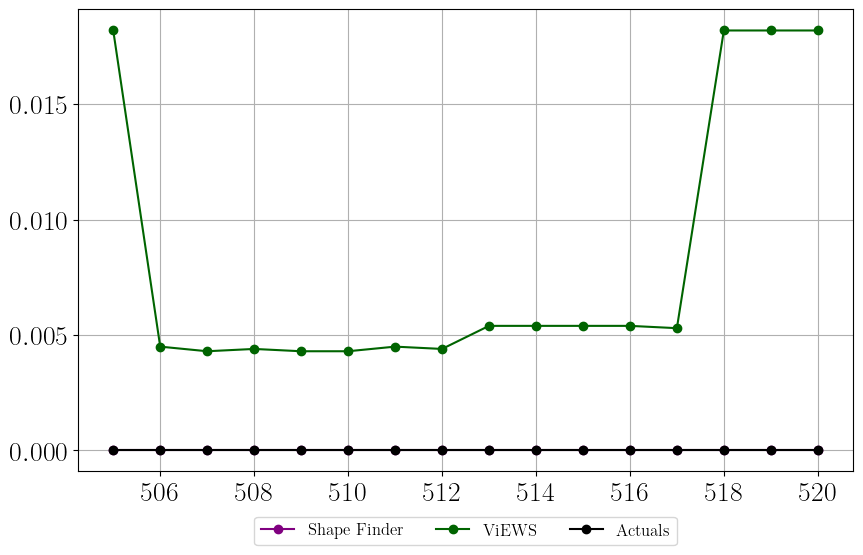

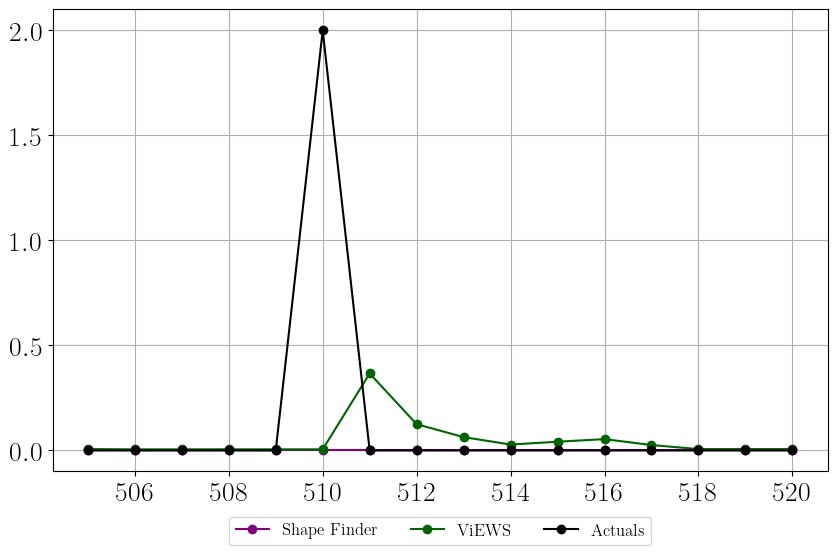

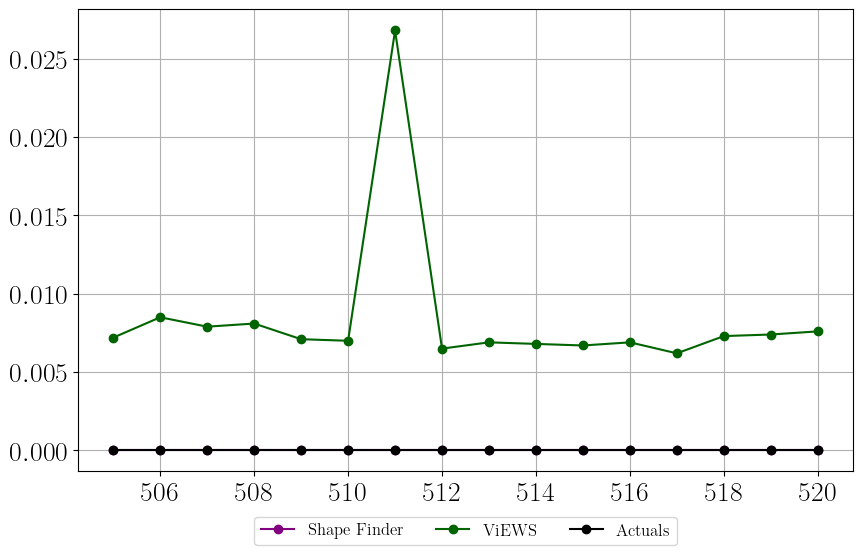

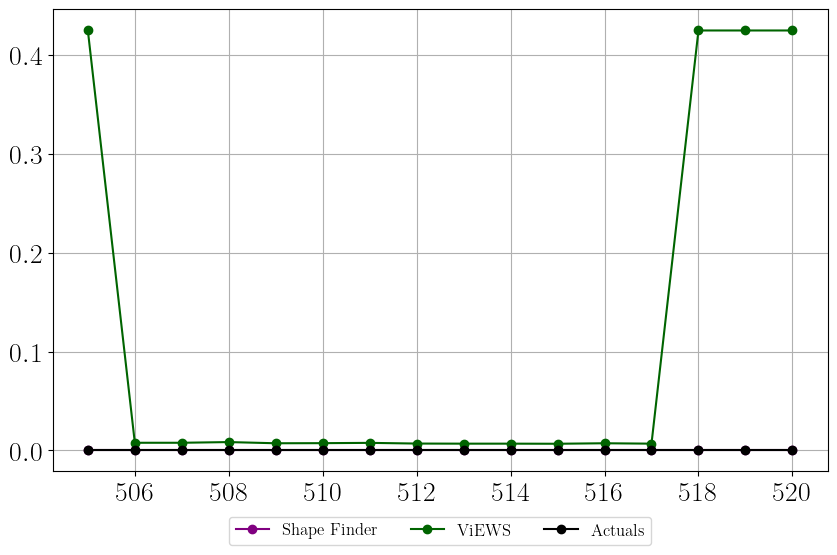

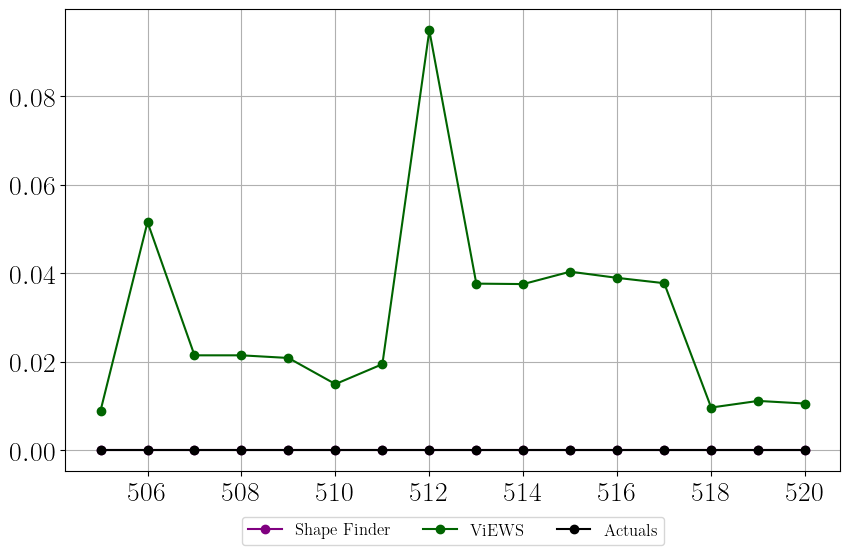

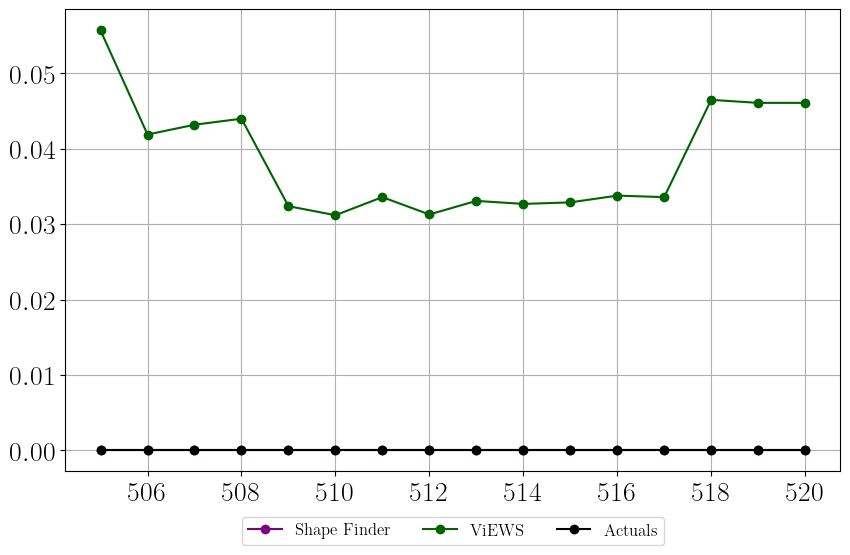

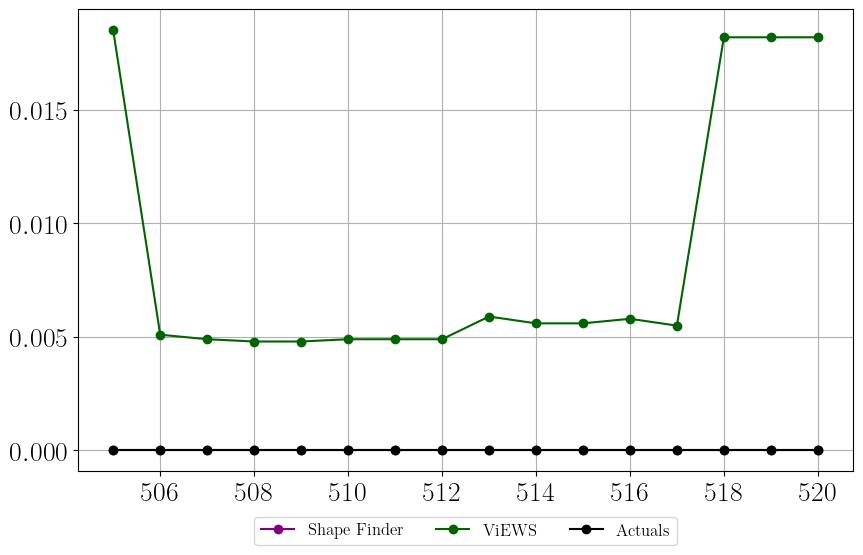

No patterns found to predict. Maybe increase the minimum distance.
No patterns found to predict. Maybe increase the minimum distance.


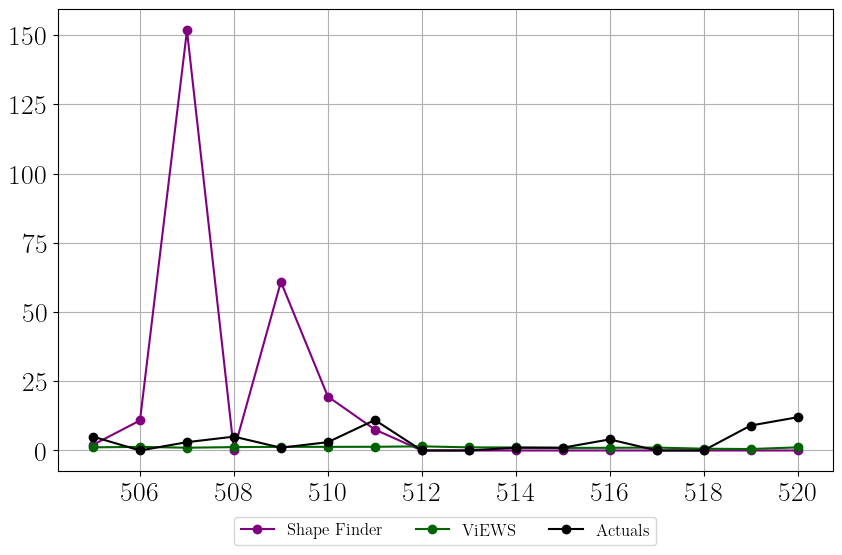

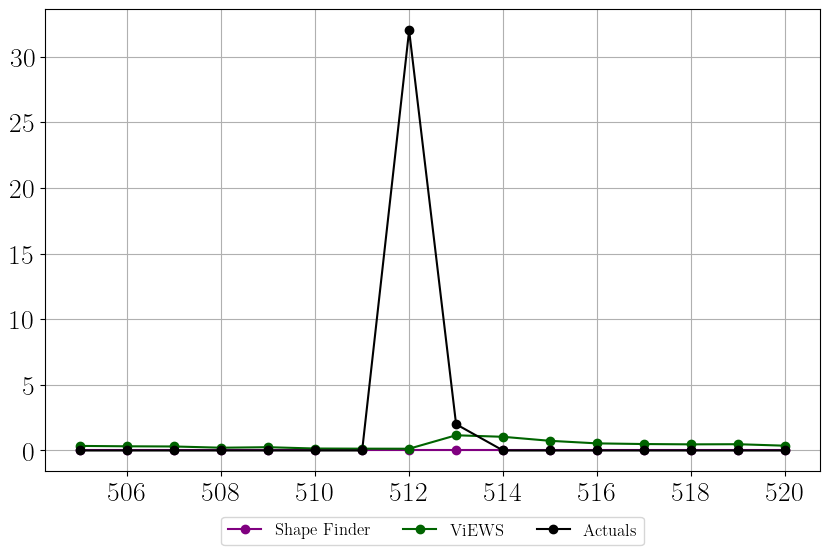

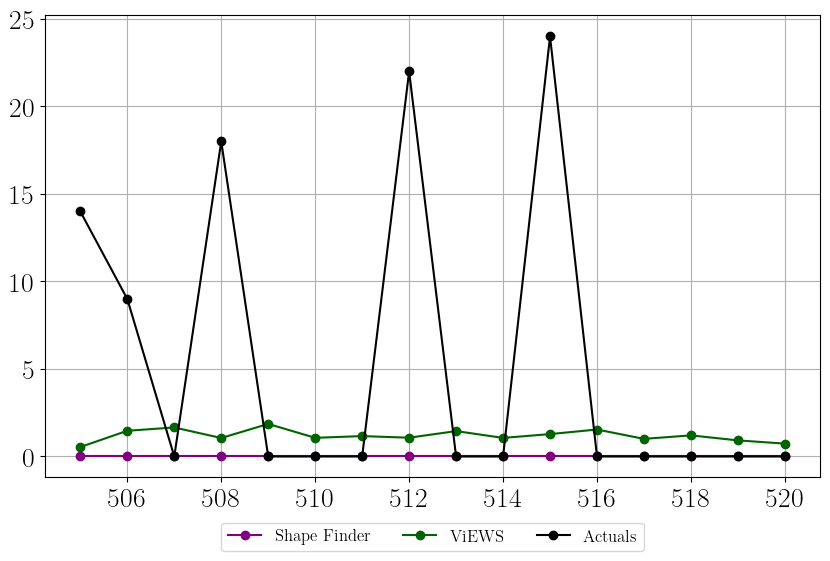

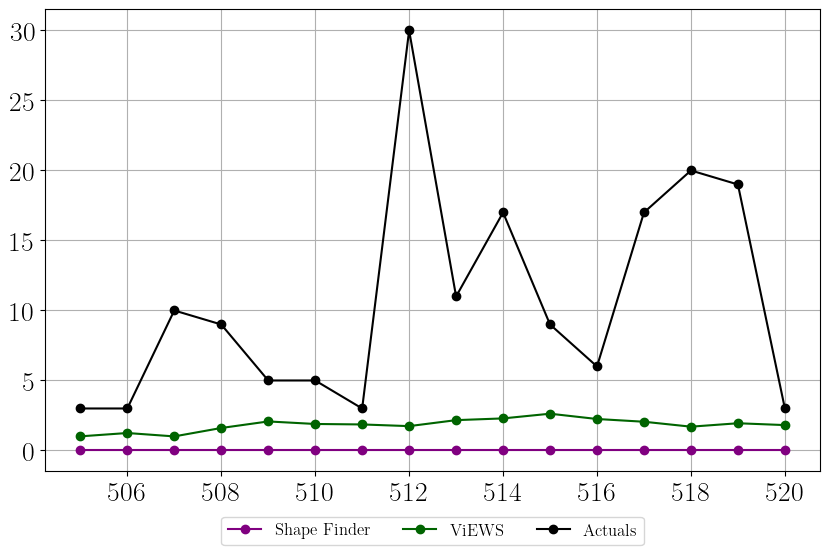

No patterns found to predict. Maybe increase the minimum distance.
No patterns found to predict. Maybe increase the minimum distance.


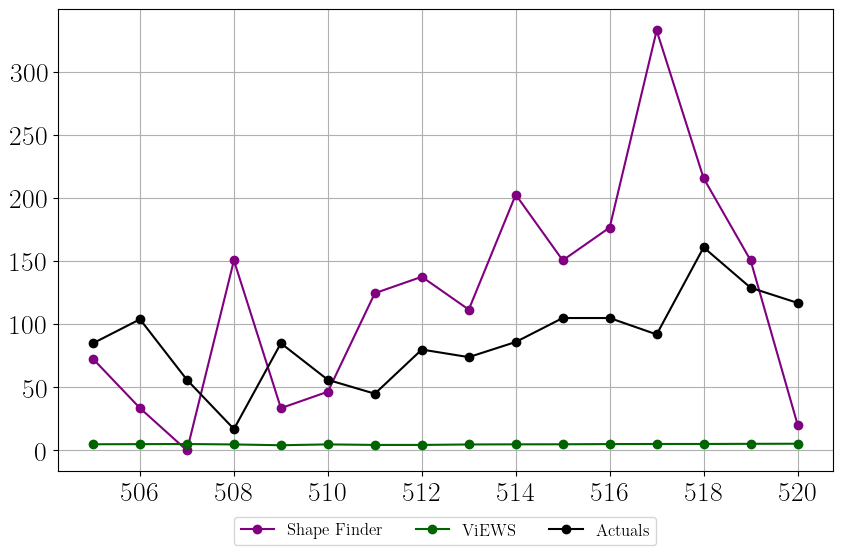

No patterns found to predict. Maybe increase the minimum distance.


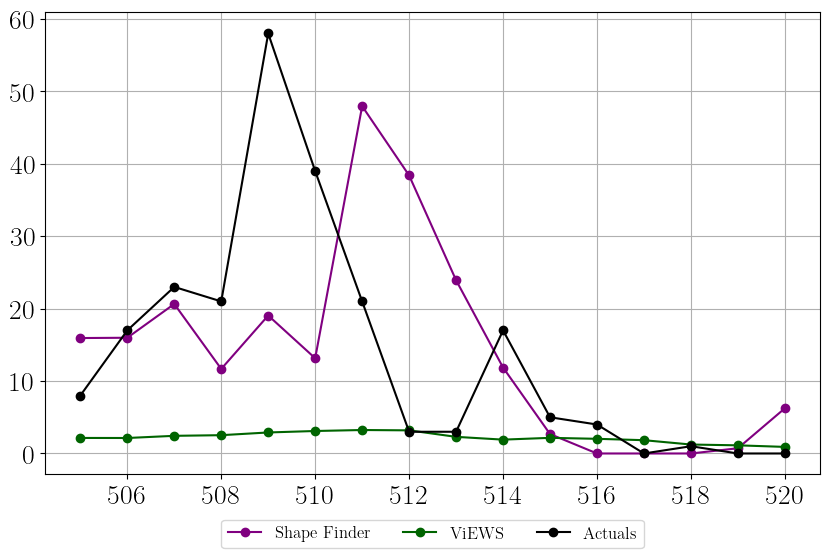

No patterns found to predict. Maybe increase the minimum distance.
No patterns found to predict. Maybe increase the minimum distance.
No patterns found to predict. Maybe increase the minimum distance.


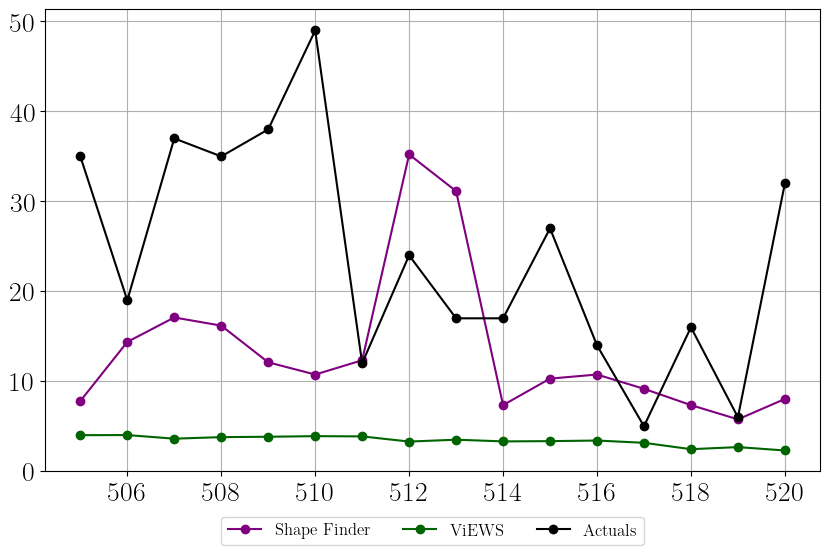

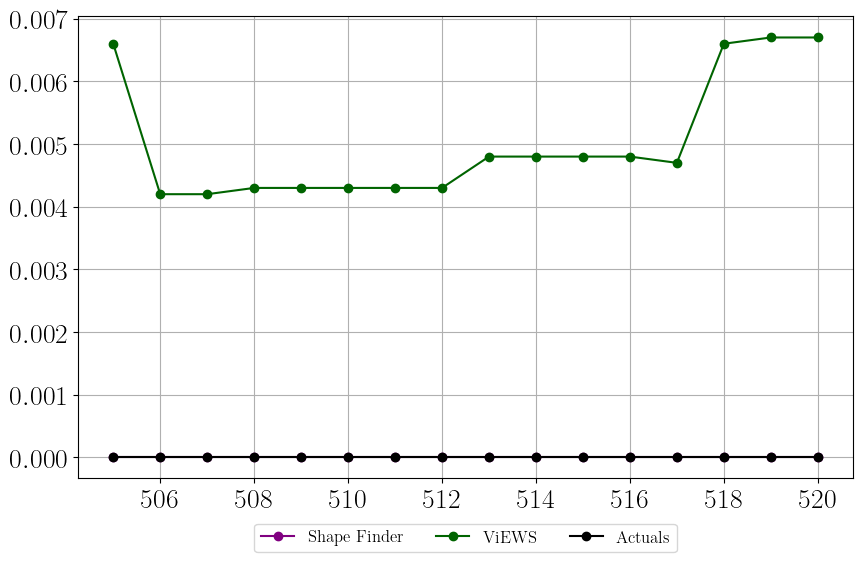

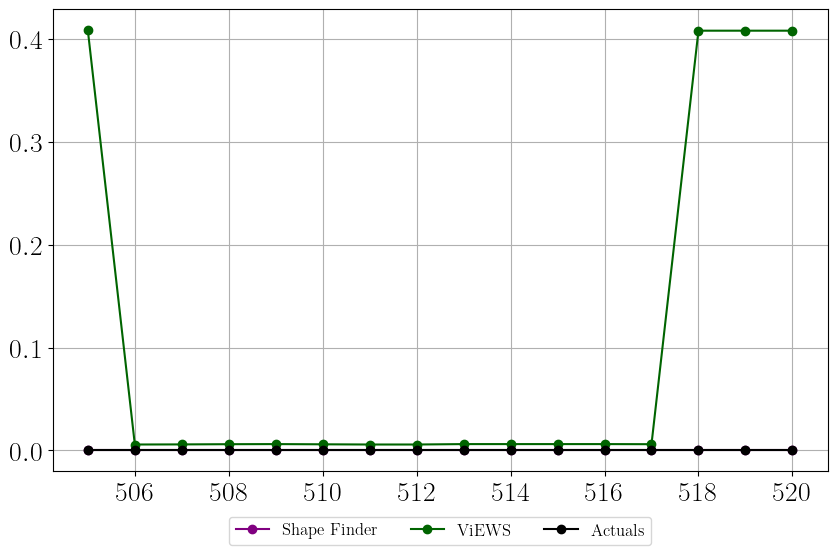

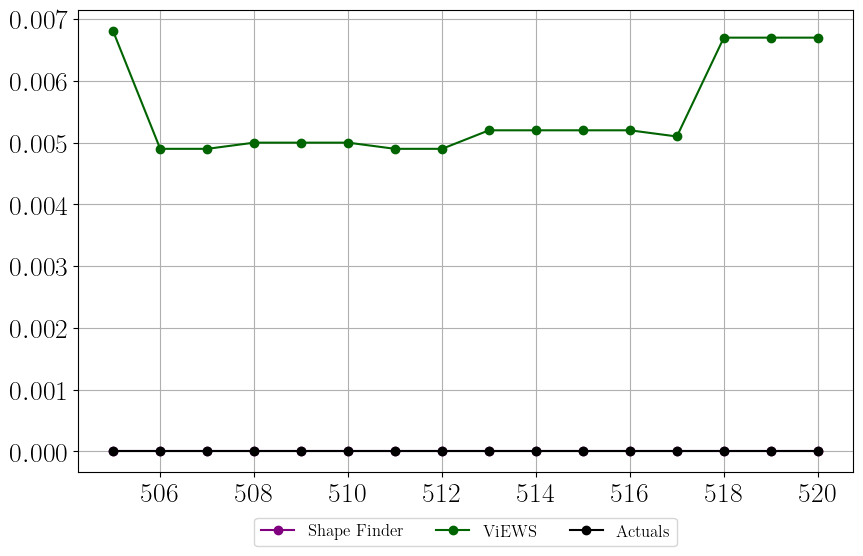

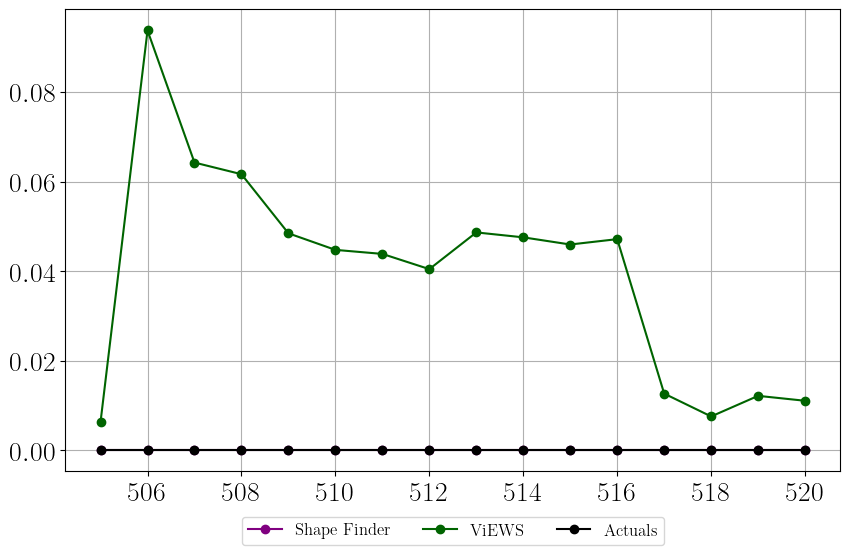

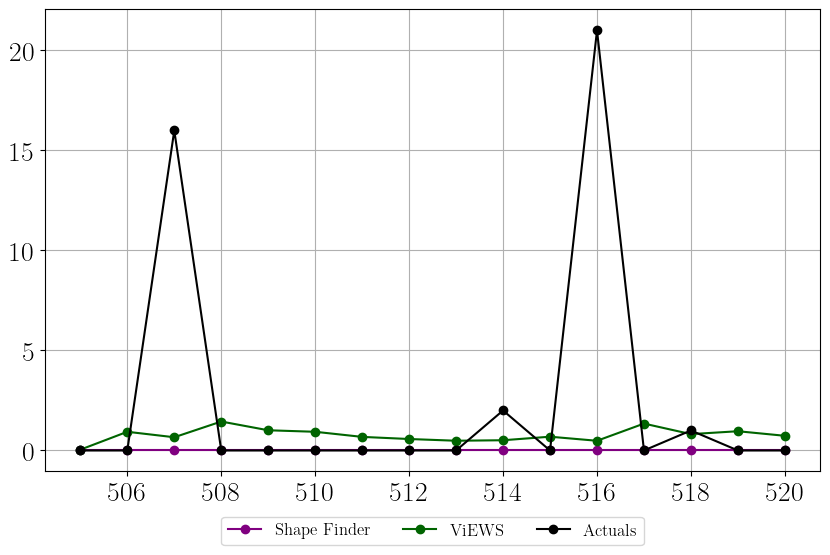

No patterns found to predict. Maybe increase the minimum distance.
No patterns found to predict. Maybe increase the minimum distance.


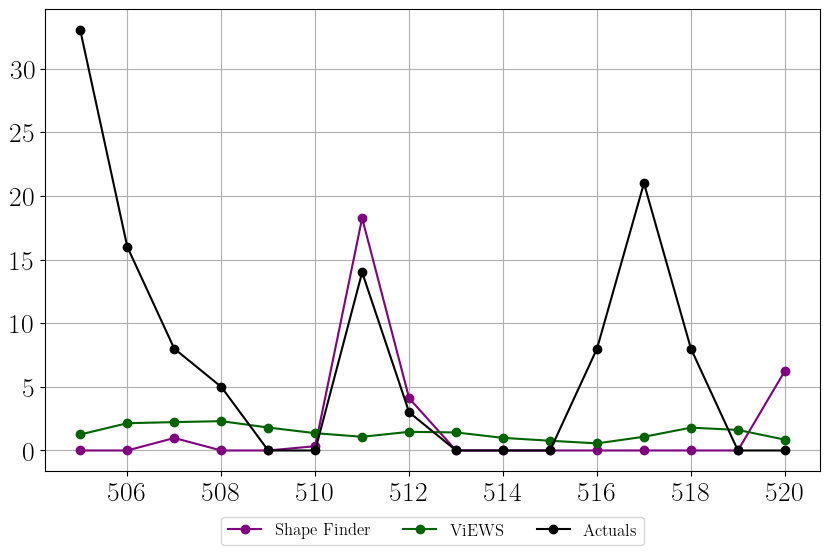

No patterns found to predict. Maybe increase the minimum distance.


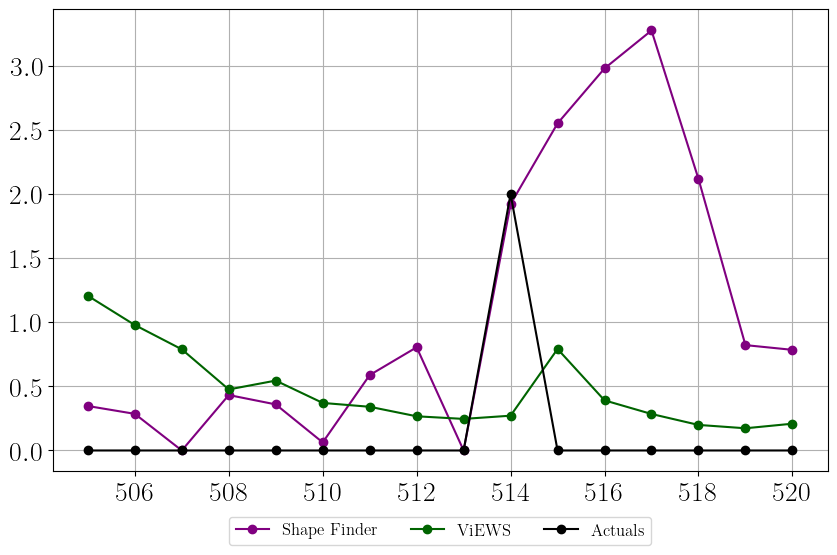

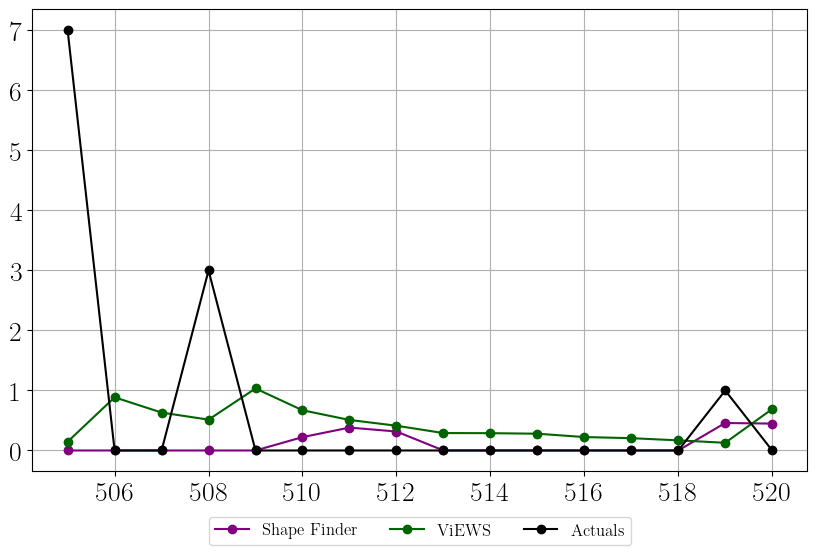

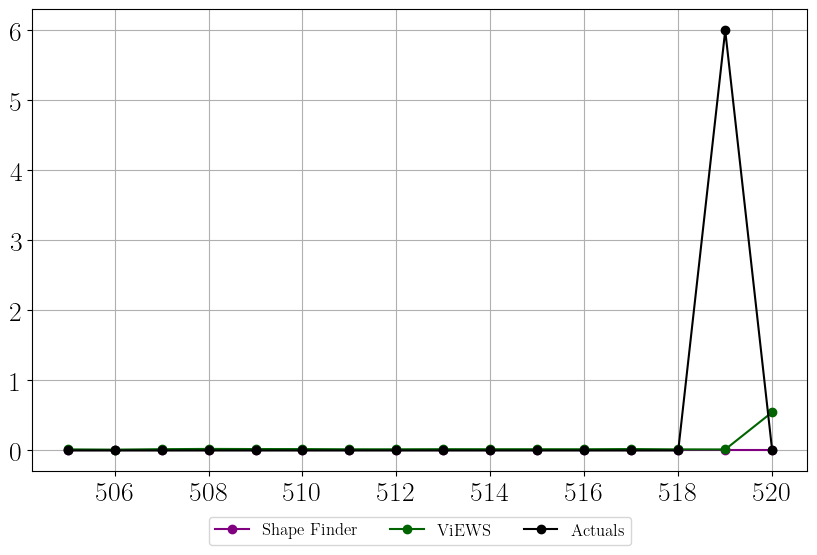

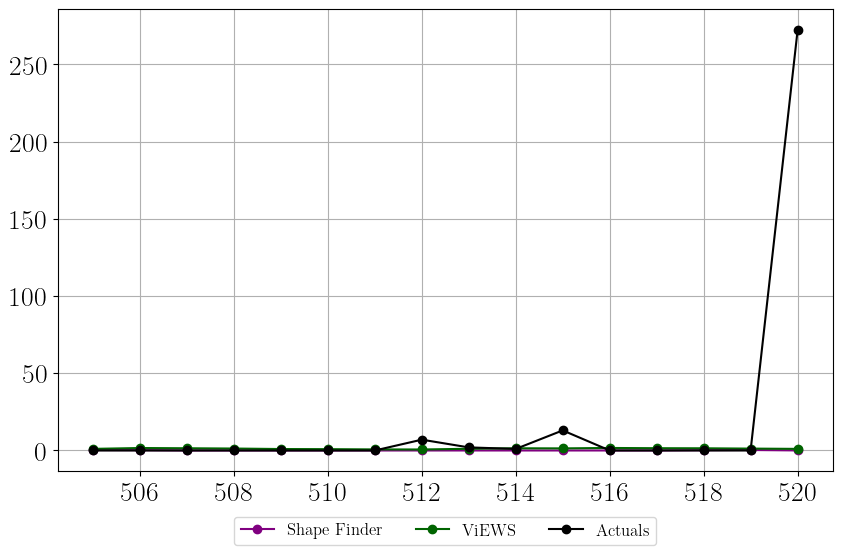

No patterns found to predict. Maybe increase the minimum distance.


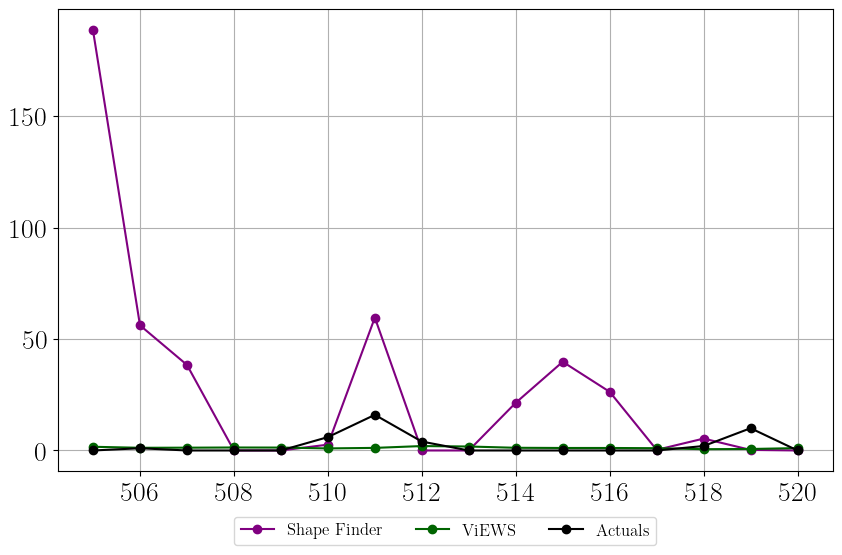

1  2  3    4  5  6  7  8  9  10  ...  232  233  234  235        237  \
505  0  0  0  0.0  0  0  0  0  0   0  ...    0    0    0    0   0.000000   
506  0  0  0  0.0  0  0  0  0  0   0  ...    0    0    0    0   0.000000   
507  0  0  0  0.0  0  0  0  0  0   0  ...    0    0    0    0   0.980953   
508  0  0  0  0.0  0  0  0  0  0   0  ...    0    0    0    0   0.000000   
509  0  0  0  0.0  0  0  0  0  0   0  ...    0    0    0    0   0.000000   
510  0  0  0  0.0  0  0  0  0  0   0  ...    0    0    0    0   0.335492   
511  0  0  0  0.0  0  0  0  0  0   0  ...    0    0    0    0  18.263115   
512  0  0  0  0.0  0  0  0  0  0   0  ...    0    0    0    0   4.104271   
513  0  0  0  0.0  0  0  0  0  0   0  ...    0    0    0    0   0.000000   
514  0  0  0  0.0  0  0  0  0  0   0  ...    0    0    0    0   0.000000   
515  0  0  0  0.0  0  0  0  0  0   0  ...    0    0    0    0   0.000000   
516  0  0  0  0.0  0  0  0  0  0   0  ...    0    0    0    0   0.000000   
517  0  0  0  0.0  0  0  0  0  0   0  ...    0    0    0    0   0.000000   
518  0  0  0  0.0  0  0  0  0  0   0  ...    0    0    0    0   0.000000   
519  0  0  0  0.0  0  0  0  0  0   0  ...    0    0    0    0   0.000000   
520  0  0  0  0.0  0  0  0  0  0   0  ...    0    0    0    0   6.249790   

          242       243  244       245         246  
505  0.346809  0.000000    0  0.269037  188.518319  
506  0.285695  0.000000    0  0.213403   56.170793  
507  0.000000  0.000000    0  0.000000   38.406115  
508  0.432506  0.000000    0  0.000000    0.000000  
509  0.359419  0.000000    0  0.000000    0.000000  
510  0.062948  0.222305    0  0.000000    2.621049  
511  0.588118  0.381638    0  0.000000   59.630230  
512  0.805032  0.315967    0  0.000000    0.000000  
513  0.000000  0.000000    0  0.000000    0.000000  
514  1.921684  0.000000    0  0.000000   21.414209  
515  2.551682  0.000000    0  0.000000   39.808287  
516  2.980461  0.000000    0  0.000000   26.321921  
517  3.276512  0.000000    0  0.000000    0.277403  
518  2.118773  0.000000    0  0.188740    5.342872  
519  0.821972  0.458058    0  0.316775    0.252699  
520  0.785075  0.448040    0  0.025212    0.000000  

[16 rows x 191 columns]

In [87]:
############
### Test ###
############

h_train=10
h=16
dtw_sel=2
min_d=0.1
min_d_e=0.1

train_df = df_input.iloc[:-16-h_train,:]
test_df = df_input.iloc[-16-h_train:,:]
            
df_sf_tot=pd.DataFrame() # Predictions shape finder, all countries

for row in range(len(test_df.columns)):
    seq=test_df.iloc[:h_train,row]
    min_d_2=min_d
                
    if (seq==0).all()==False: # check if test not flat
                    
        ### Shape Finder ###
        sh = Shape()
        sh.set_shape(np.array(seq))
        scaler = MinMaxScaler((0,1))
        df_scaler=pd.concat([seq,seq,seq],axis=1)
        df_scaler.index=range(len(df_scaler))
        df_scaler.columns = ['Prediction', 'CI lower', 'CI upper']
        fitted_scaler = scaler.fit(df_scaler)
        model = finder(train_df,Shape=sh)
        pred = model.predict(horizon=h,plot=False,metric='dtw',min_d=min_d_2,dtw_sel=dtw_sel,select=True)
                    
        while pred is None: # Increase distance until prediction is possible
            min_d_2=min_d_2+min_d_e
            pred = model.predict(horizon=h,plot=False,metric='dtw',min_d=min_d_2,dtw_sel=dtw_sel,select=True)
                    
        pred=fitted_scaler.inverse_transform(pred) # Convert to non normalized 
        pred[pred<0]=0 # Correct negative predictions 
        pred=pd.DataFrame(pred)
                    
    else: # if test is flat, flat predictions are returned
        seq=pd.Series([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])        
        pred=pd.concat([seq,seq,seq],axis=1)
        pred.columns=[0,1,2]

    # Save predictions for shape finder 
    preds_add=pred.iloc[:,0]
    preds_add.index=df_input.iloc[-16:,row].index
    df_sf_tot=pd.concat([df_sf_tot,preds_add],axis=1)

    # Plot 
    plt.figure(figsize=(10, 6))
    plt.plot(df_sf_tot.iloc[:,row], label='Shape Finder', marker='o',color='purple')
    plt.plot(df_preds.iloc[:,row], label='ViEWS', marker='o',color='darkgreen')
    plt.plot(df_input.iloc[-16:,row],label='Actuals',marker='o',color="black")
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.08), ncol=5,fontsize=12)
    plt.grid(True)
    plt.savefig(os.path.join(out_paths["analysis"],f"compare_preds_{row}.jpeg"),dpi=400,bbox_inches="tight")
    plt.show()
    
df_sf_tot=df_sf_tot.fillna(0)
df_sf_tot.columns = df_preds.columns
df_sf_tot

In [9]:
# Get data on X 
df_X_t=pd.DataFrame()
for i in range(len(df_list_input)):
    print(f'https://api.viewsforecasting.org/{list(df_list_input.keys())[i]}')
    response = requests.get(f'https://api.viewsforecasting.org/{list(df_list_input.keys())[i]}')
    json_data = response.json()
    df=pd.DataFrame(json_data["data"])
    df=df[["country_id","month_id","ucdp_ged_sb_best_sum","vdem_v12_v2x_libdem","wb_wdi_ny_gdp_pcap_kd","wb_wdi_sp_pop_totl"]]
    df_X_t = pd.concat([df_X_t, df])
    df_X_t=df_X_t.reset_index(drop=True)
    
df_X=df_X_t[df_X_t['country_id'].isin(cc_sort)]
df_X=df_X.sort_values(by=["country_id","month_id"])

# Create variables 
df_X["dummy_ucdp_ged_sb_best_sum"]=0
df_X.loc[df_X["ucdp_ged_sb_best_sum"]>0,"dummy_ucdp_ged_sb_best_sum"]=1
df_X["d_sb_lag1"]=df_X.groupby("country_id")["dummy_ucdp_ged_sb_best_sum"].shift(1).fillna(0)
df_X=df_X[["country_id","month_id","d_sb_lag1","dummy_ucdp_ged_sb_best_sum","ucdp_ged_sb_best_sum","vdem_v12_v2x_libdem","wb_wdi_ny_gdp_pcap_kd","wb_wdi_sp_pop_totl"]]

# Final dfs
df_conf_hist=df_X.pivot(index="month_id",columns='country_id',values='d_sb_lag1')
df_conf_hist=df_conf_hist[:-8]
df_libdem=df_X.pivot(index="month_id",columns='country_id',values='vdem_v12_v2x_libdem')
df_libdem=df_libdem[:-8]
df_gdp=df_X.pivot(index="month_id",columns='country_id',values='wb_wdi_ny_gdp_pcap_kd')
df_gdp=df_gdp[:-8]
df_pop=df_X.pivot(index="month_id",columns='country_id',values='wb_wdi_sp_pop_totl')
df_pop=df_pop[:-8]

https://api.viewsforecasting.org/predictors_fatalities002_0000_00/cm
https://api.viewsforecasting.org/predictors_fatalities002_0000_00/cm?page=2
https://api.viewsforecasting.org/predictors_fatalities002_0000_00/cm?page=3
https://api.viewsforecasting.org/predictors_fatalities002_0000_00/cm?page=4
https://api.viewsforecasting.org/predictors_fatalities002_0000_00/cm?page=5
https://api.viewsforecasting.org/predictors_fatalities002_0000_00/cm?page=6
https://api.viewsforecasting.org/predictors_fatalities002_0000_00/cm?page=7
https://api.viewsforecasting.org/predictors_fatalities002_0000_00/cm?page=8
https://api.viewsforecasting.org/predictors_fatalities002_0000_00/cm?page=9
https://api.viewsforecasting.org/predictors_fatalities002_0000_00/cm?page=10
https://api.viewsforecasting.org/predictors_fatalities002_0000_00/cm?page=11
https://api.viewsforecasting.org/predictors_fatalities002_0000_00/cm?page=12
https://api.viewsforecasting.org/predictors_fatalities002_0000_00/cm?page=13
https://api.vie

In [10]:
# Zero model
df_null = pd.DataFrame(0, index=range(16), columns=range(191))
df_null

0    1    2    3    4    5    6    7    8    9    ...  181  182  183  184  \
0     0    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
1     0    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
2     0    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
3     0    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
4     0    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
5     0    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
6     0    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
7     0    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
8     0    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
9     0    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
10    0    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
11    0    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
12    0    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
13    0    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
14    0    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
15    0    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   

    185  186  187  188  189  190  
0     0    0    0    0    0    0  
1     0    0    0    0    0    0  
2     0    0    0    0    0    0  
3     0    0    0    0    0    0  
4     0    0    0    0    0    0  
5     0    0    0    0    0    0  
6     0    0    0    0    0    0  
7     0    0    0    0    0    0  
8     0    0    0    0    0    0  
9     0    0    0    0    0    0  
10    0    0    0    0    0    0  
11    0    0    0    0    0    0  
12    0    0    0    0    0    0  
13    0    0    0    0    0    0  
14    0    0    0    0    0    0  
15    0    0    0    0    0    0  

[16 rows x 191 columns]

In [11]:
##############################
### General model function ###
##############################

from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

def gen_model(y,model=LinearRegression(),train_test=-16,ar=1,X=None,opti_grid=None):
    ts_seq_total=[]
    for i in range(ar,len(y)):
        ts_seq_total.append(y.iloc[i-ar:i]) 
    ts_seq_total=np.array(ts_seq_total)
    final=np.concatenate([ts_seq_total,np.array(y)[-len(ts_seq_total):].reshape(-1,1)],axis=1)
                
    if X is not None:
        if isinstance(X, pd.Series):
            final=np.concatenate([np.array(X)[-len(final):].reshape(-1,1),final],axis=1)
        elif X.shape[1]>=2:
            final=np.concatenate([np.array(X)[-len(final):,:],final],axis=1)
            
    out={"output": final[:,-1:],"input": final[:,:-1]}
        
    x_train = out['input'][:train_test,:]
    x_test = out['input'][train_test:,:]
    y_train = out['output'][:train_test]
    y_test = out['output'][train_test:]

    if opti_grid is not None: 
        train_indices = range(int(len(x_train)*0.8))
        test_indices = range(int(len(x_train)*0.8), len(x_train))
        custom_cv = [(list(train_indices), list(test_indices))]
        opti_model = GridSearchCV(estimator=model, param_grid=opti_grid, cv=custom_cv, verbose=0, n_jobs=-1)
        opti_model.fit(x_train, y_train.ravel())
        pred = opti_model.predict(x_test)
    
    else:
        model.fit(x_train, y_train.ravel())
        pred = model.predict(x_test)
        
    return(pred)

In [13]:
# t-1 model
df_t1_preds=pd.DataFrame()
for row in range(len(df_input.columns)):
    ts=df_input.iloc[:,row].fillna(0)
    preds=gen_model(ts,ar=1)
    preds[preds<0]=0 # Correct negative predictions 
    df_t1_preds=pd.concat([df_t1_preds,pd.DataFrame(preds)],axis=1)
df_t1_preds

0    0         0         0    0    0    0    0    0    0  ...    0    0  \
0   0.0  0.0  0.077491  0.385731  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
1   0.0  0.0  0.077491  0.385731  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
2   0.0  0.0  0.077491  0.360732  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
3   0.0  0.0  0.077491  0.385731  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
4   0.0  0.0  0.077491  0.385731  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
5   0.0  0.0  0.077491  0.385731  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
6   0.0  0.0  0.077491  0.385731  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
7   0.0  0.0  0.077491  0.385731  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
8   0.0  0.0  0.077491  0.385731  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
9   0.0  0.0  0.077491  0.385731  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
10  0.0  0.0  0.077491  0.385731  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
11  0.0  0.0  0.077491  0.385731  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
12  0.0  0.0  0.077491  0.385731  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
13  0.0  0.0  0.077491  0.385731  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
14  0.0  0.0  0.077491  0.385731  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
15  0.0  0.0  0.077491  0.385731  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   

           0          0          0         0         0         0          0  \
0   0.609948  13.408328   3.012779  0.215892  0.070848  0.065793   7.487307   
1   0.609948  13.408328  11.660031  0.100450  0.035887  0.065793   7.487307   
2   0.609948  13.408328   6.215465  0.100450  0.070848  0.065793   7.487307   
3   0.609948  20.225691   3.653316  0.100450  0.070848  0.065793   7.487307   
4   0.609948  13.408328   2.692511  0.100450  0.055865  0.065793   7.487307   
5   0.609948  13.408328   1.091168  0.100450  0.070848  0.065793   7.487307   
6   0.609948  13.408328   1.091168  0.100450  0.070848  0.065793   7.487307   
7   0.609948  13.408328   5.574928  0.100450  0.070848  0.065793   7.487307   
8   0.609948  13.408328   2.051973  0.100450  0.070848  0.065793  11.222266   
9   0.609948  13.408328   1.091168  0.100450  0.070848  0.065793   8.554438   
10  0.609948  14.260498   1.091168  0.133433  0.070848  0.065793   8.020872   
11  0.609948  13.408328   1.091168  0.100450  0.070848  0.065793  14.423660   
12  0.609948  22.356117   3.653316  0.100450  0.070848  0.065793   7.487307   
13  0.609948  13.408328   7.816808  0.100450  0.070848  0.065793   7.487307   
14  0.609948  13.834413   3.653316  0.100450  0.070848  0.065793   7.487307   
15  0.609948  13.408328   1.091168  0.100450  0.065854  0.018117   7.487307   

            0  
0   25.410644  
1   11.556855  
2   11.783966  
3   11.556855  
4   11.556855  
5   11.556855  
6   12.919523  
7   15.190636  
8   12.465300  
9   11.556855  
10  11.556855  
11  11.556855  
12  11.556855  
13  11.556855  
14  12.011077  
15  13.827968  

[16 rows x 191 columns]

In [14]:
# Simple random forest
random_grid = {'n_estimators': [int(x) for x in np.linspace(start = 10, stop = 2000, num = 10)],
               'max_features': ['auto', 'sqrt'],
               'max_depth': [int(x) for x in np.linspace(10, 110, num = 11)]+[None],
               'min_samples_split': [2,5,10],
               'min_samples_leaf': [1,2,4],
               'bootstrap': [True, False]}

#X = pd.concat([df_conf_hist.iloc[:,14].fillna(0), df_libdem.iloc[:,14].fillna(df_libdem.iloc[:,14].mean())],axis=1)
X = pd.concat([df_libdem.iloc[:,14].fillna(df_libdem.iloc[:,14].mean()), df_gdp.iloc[:,14].fillna(df_gdp.iloc[:,14].mean())],axis=1)
X = pd.concat([X, df_pop.iloc[:,14].fillna(df_pop.iloc[:,14].mean())],axis=1)

df_simple_preds=pd.DataFrame()
for row in range(len(df_input.columns)):
    print(row)
    ts=df_input.iloc[:,row].fillna(0)
    preds=gen_model(ts,model=RandomForestRegressor(random_state=0),ar=1,X=X,opti_grid=random_grid)
    df_simple_preds=pd.concat([df_simple_preds,pd.DataFrame(preds)],axis=1)
df_simple_preds

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190


0    0    0    0    0    0    0    0    0    0  ...    0    0         0  \
0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  1.226316   
1   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  1.226316   
2   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  1.226316   
3   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  1.226316   
4   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  1.226316   
5   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  1.226316   
6   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  1.226316   
7   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  1.226316   
8   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  1.226316   
9   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  1.226316   
10  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  1.226316   
11  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  1.226316   
12  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  1.226316   
13  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  1.226316   
14  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  1.226316   
15  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  1.226316   

            0         0    0    0    0          0          0  
0   12.445000  0.228066  0.7  0.0  0.0   0.000000  19.835714  
1   12.445000  0.624409  0.0  0.0  0.0   0.000000   0.000000  
2   12.445000  0.402197  0.0  0.0  0.0   0.000000   0.000000  
3   28.478333  0.245382  0.0  0.0  0.0   0.000000   0.000000  
4   12.445000  0.184088  0.0  0.0  0.0   0.000000   0.000000  
5   12.445000  0.116668  0.0  0.0  0.0   0.000000   0.000000  
6   12.445000  0.116668  0.0  0.0  0.0   0.000000   4.500000  
7   12.445000  0.416702  0.0  0.0  0.0   0.000000   4.500000  
8   12.445000  0.167132  0.0  0.0  0.0  11.115556   0.000000  
9   12.445000  0.116668  0.0  0.0  0.0   4.710000   0.000000  
10  12.445000  0.116668  2.1  0.0  0.0   4.710000   0.000000  
11  12.445000  0.116668  0.0  0.0  0.0  11.115556   0.000000  
12  28.478333  0.245382  0.0  0.0  0.0   0.000000   0.000000  
13  12.445000  0.569575  0.0  0.0  0.0   0.000000   0.000000  
14  12.445000  0.245382  0.0  0.0  0.0   0.000000   0.000000  
15  12.445000  0.116668  0.0  0.0  0.0   0.000000   4.500000  

[16 rows x 191 columns]

In [96]:
# Save
#df_input.to_csv('df_actuals.csv')
#df_sf_tot.to_csv('df_sf_preds.csv')
#df_preds.to_csv('df_views_preds.csv')
#df_null.to_csv('df_null_preds.csv')
#df_t1_preds.to_csv('df_t1_preds.csv')
#df_simple_preds.to_csv('df_simple_preds.csv')

In [98]:
# Load
df_input=pd.read_csv('df_actuals.csv',index_col=0)
df_sf_tot=pd.read_csv('df_sf_preds.csv',index_col=0)
df_preds=pd.read_csv('df_views_preds.csv',index_col=0)
df_null=pd.read_csv('df_null_preds.csv',index_col=0)
df_t1_preds=pd.read_csv('df_t1_preds.csv',index_col=0)
df_simple_preds=pd.read_csv('df_simple_preds.csv',index_col=0)

In [99]:
# Normalize
scaler=MinMaxScaler((0,1))
df_actuals_n=pd.DataFrame(scaler.fit_transform(df_input))
df_sf_preds_n=pd.DataFrame(scaler.transform(df_sf_tot))
df_views_preds_n=pd.DataFrame(scaler.transform(df_preds))
df_null
df_t1_preds_n=pd.DataFrame(scaler.fit_transform(df_t1_preds))
df_simple_preds_n=pd.DataFrame(scaler.fit_transform(df_simple_preds))

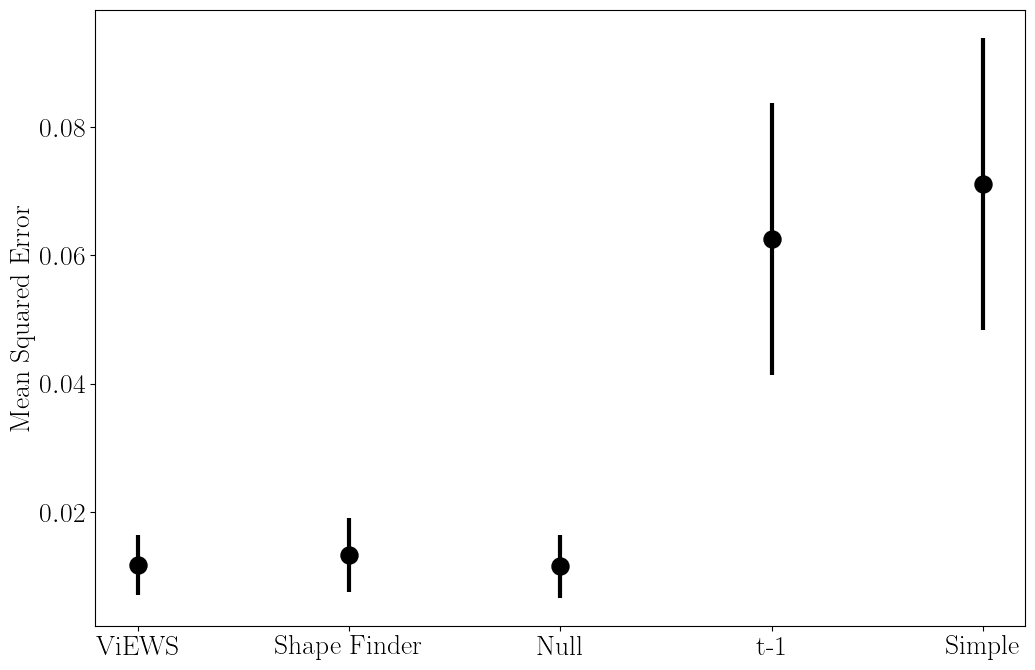

mean       std
0  0.011722  0.004724
1  0.013244  0.005785
2  0.011554  0.004923
3  0.062542  0.021226
4  0.071135  0.022771

In [100]:
# MSE
err_nn=[]
err_b=[]
err_null=[]
err_t1=[]
err_simple=[]

for i in range(len(df_sf_tot.columns)):
    err_nn.append(mean_squared_error(df_actuals_n.iloc[-16:,i], df_sf_preds_n.iloc[:,i]))  
    err_b.append(mean_squared_error(df_actuals_n.iloc[-16:,i], df_views_preds_n.iloc[:,i]))
    err_null.append(mean_squared_error(df_actuals_n.iloc[-16:,i], df_null.iloc[:,i]))
    err_t1.append(mean_squared_error(df_actuals_n.iloc[-16:,i], df_t1_preds_n.iloc[:,i]))
    err_simple.append(mean_squared_error(df_actuals_n.iloc[-16:,i], df_simple_preds_n.iloc[:,i]))
    
err_nn = np.array(err_nn)
err_b = np.array(err_b)
err_null = np.array(err_null)
err_t1 = np.array(err_t1)
err_simple = np.array(err_simple)

means = [err_b.mean(),err_nn.mean(),err_null.mean(),err_t1.mean(),err_simple.mean()]
std_error = [2*err_b.std()/np.sqrt(len(err_b)),2*err_nn.std()/np.sqrt(len(err_nn)),2*err_null.std()/np.sqrt(len(err_null)),2*err_t1.std()/np.sqrt(len(err_t1)),2*err_simple.std()/np.sqrt(len(err_simple))]
mean_mse = pd.DataFrame({
    'mean': means,
    'std': std_error
})

plt.figure(figsize=(12,8))
ax = plt.axes()
marker_size = 150
linewidth = 3
fonts=25
plt.rc('font', size=24)
plt.ylabel('Mean Squared Error')
plt.tick_params(axis='y')
plt.scatter(mean_mse.index, mean_mse['mean'], color="black", marker='o', s=marker_size)
plt.errorbar(mean_mse.index, mean_mse['mean'], yerr=mean_mse['std'], fmt='none', color="black", linewidth=linewidth)
plt.grid(False)
plt.xticks([0,1,2,3,4],['ViEWS','Shape Finder',"Null","t-1","Simple"])
plt.show()
mean_mse

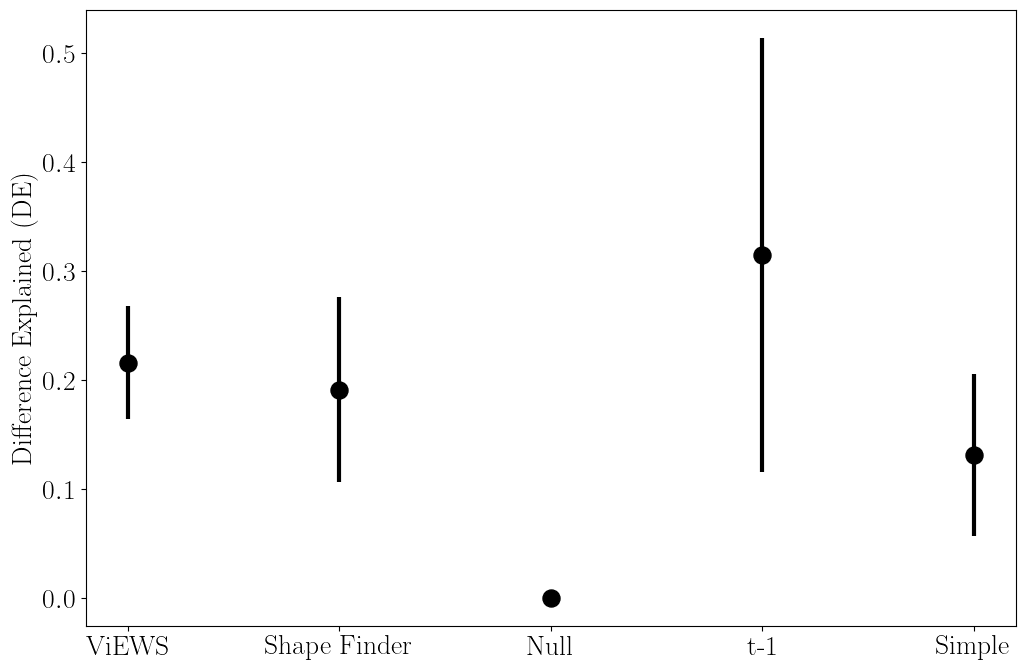

mean       std
0  0.215514  0.051752
1  0.208997  0.091268
2  0.000000  0.000000
3  0.314687  0.199228
4  0.131223  0.074290

In [101]:
# Difference explained
d_nn=[]
d_b=[]
d_null=[]
d_t1=[]
d_simple=[]

k=5
for i in range(len(df_sf_preds_n.columns)):
    real = df_actuals_n.iloc[-16:,i]
    real=real.reset_index(drop=True)
    sf=df_sf_preds_n.iloc[:,i]
    sf=sf.reset_index(drop=True)
    b1=df_views_preds_n.iloc[:,i]
    b1=b1.reset_index(drop=True)
    null=df_null.iloc[:,i]
    null=null.reset_index(drop=True)
    t1=df_t1_preds_n.iloc[:,i]
    t1=t1.reset_index(drop=True)  
    simple=df_simple_preds_n.iloc[:,i]
    simple=simple.reset_index(drop=True)       
     
    max_s=0
    max_b1=0
    max_null=0
    max_t1=0
    max_simple=0

    if (real==0).all()==False:
        for value in real[1:].index:
            if (real[value]==real[value-1]):
                1
            else:
                max_exp=0
                if (real[value]-real[value-1])/(sf[value]-sf[value-1])>0 and sf[value]-sf[value-1] != 0:
                    t=abs(((real[value]-real[value-1])-(sf[value]-sf[value-1]))/(real[value]-real[value-1]))
                    max_exp = np.exp(-(k*t))
                else:
                    if value==15:
                        if (real[value]-real[value-1])/(sf[value-1]-sf[value-2])>0 and sf[value-1]-sf[value-2] != 0:
                            t=abs(((real[value]-real[value-1])-(sf[value-1]-sf[value-2]))/(real[value]-real[value-1]))/2
                            if max_exp<np.exp(-(k*t)):
                                max_exp = np.exp(-(k*t))
                    elif value==1:
                        if (real[value]-real[value-1])/(sf[value+1]-sf[value])>0 and sf[value+1]-sf[value] != 0:
                            t=abs(((real[value]-real[value-1])-(sf[value+1]-sf[value]))/(real[value]-real[value-1]))/2
                            if max_exp<np.exp(-(k*t)):
                                max_exp = np.exp(-(k*t))
                    else : 
                        if (real[value]-real[value-1])/(sf[value-1]-sf[value-2])>0 and sf[value-1]-sf[value-2] != 0:
                            t=abs(((real[value]-real[value-1])-(sf[value-1]-sf[value-2]))/(real[value]-real[value-1]))/2
                            if max_exp<np.exp(-(k*t)):
                                max_exp = np.exp(-(k*t))
                        if (real[value]-real[value-1])/(sf[value+1]-sf[value])>0 and sf[value+1]-sf[value] != 0:
                            t=abs(((real[value]-real[value-1])-(sf[value+1]-sf[value]))/(real[value]-real[value-1]))/2
                            if max_exp<np.exp(-(k*t)):
                                max_exp = np.exp(-(k*t))
                max_s=max_s+max_exp 



                
                
                max_exp=0
                if (real[value]-real[value-1])/(b1[value]-b1[value-1])>0 and b1[value]-b1[value-1] != 0:
                    t=abs(((real[value]-real[value-1])-(b1[value]-b1[value-1]))/(real[value]-real[value-1]))
                    max_exp = np.exp(-(k*t))
                else:
                    if value==15:
                        if (real[value]-real[value-1])/(b1[value-1]-b1[value-2])>0 and b1[value-1]-b1[value-2] != 0:
                            t=abs(((real[value]-real[value-1])-(b1[value-1]-b1[value-2]))/(real[value]-real[value-1]))/2
                            if max_exp<np.exp(-(k*t)):
                                 max_exp = np.exp(-(k*t))
                    elif value==1:
                        if (real[value]-real[value-1])/(b1[value+1]-b1[value])>0 and b1[value+1]-b1[value] != 0:
                            t=abs(((real[value]-real[value-1])-(b1[value+1]-b1[value]))/(real[value]-real[value-1]))/2
                            if max_exp<np.exp(-(k*t)):
                                max_exp = np.exp(-(k*t))
                    else : 
                        if (real[value]-real[value-1])/(b1[value-1]-b1[value-2])>0 and b1[value-1]-b1[value-2] != 0:
                            t=abs(((real[value]-real[value-1])-(b1[value-1]-b1[value-2]))/(real[value]-real[value-1]))/2
                            if max_exp<np.exp(-(k*t)):
                                max_exp = np.exp(-(k*t))
                        if (real[value]-real[value-1])/(b1[value+1]-b1[value])>0 and b1[value+1]-b1[value] != 0:
                            t=abs(((real[value]-real[value-1])-(b1[value+1]-b1[value]))/(real[value]-real[value-1]))/2
                            if max_exp<np.exp(-(k*t)):
                                max_exp = np.exp(-(k*t))
                max_b1=max_b1+max_exp 



                

                max_exp=0
                if (real[value]-real[value-1])/(null[value]-null[value-1])>0 and null[value]-null[value-1] != 0:
                    t=abs(((real[value]-real[value-1])-(null[value]-null[value-1]))/(real[value]-real[value-1]))
                    max_exp = np.exp(-(k*t))
                else:
                    if value==15:
                        if (real[value]-real[value-1])/(null[value-1]-null[value-2])>0 and null[value-1]-null[value-2] != 0:
                            t=abs(((real[value]-real[value-1])-(null[value-1]-null[value-2]))/(real[value]-real[value-1]))/2
                            if max_exp<np.exp(-(k*t)):
                                 max_exp = np.exp(-(k*t))
                    elif value==1:
                        if (real[value]-real[value-1])/(null[value+1]-null[value])>0 and null[value+1]-null[value] != 0:
                            t=abs(((real[value]-real[value-1])-(null[value+1]-null[value]))/(real[value]-real[value-1]))/2
                            if max_exp<np.exp(-(k*t)):
                                max_exp = np.exp(-(k*t))
                    else : 
                        if (real[value]-real[value-1])/(null[value-1]-null[value-2])>0 and null[value-1]-null[value-2] != 0:
                            t=abs(((real[value]-real[value-1])-(null[value-1]-null[value-2]))/(real[value]-real[value-1]))/2
                            if max_exp<np.exp(-(k*t)):
                                max_exp = np.exp(-(k*t))
                        if (real[value]-real[value-1])/(null[value+1]-null[value])>0 and null[value+1]-null[value] != 0:
                            t=abs(((real[value]-real[value-1])-(null[value+1]-null[value]))/(real[value]-real[value-1]))/2
                            if max_exp<np.exp(-(k*t)):
                                max_exp = np.exp(-(k*t))
                max_null=max_null+max_exp 



                max_exp=0
                if (real[value]-real[value-1])/(t1[value]-t1[value-1])>0 and t1[value]-t1[value-1] != 0:
                    t=abs(((real[value]-real[value-1])-(t1[value]-t1[value-1]))/(real[value]-real[value-1]))
                    max_exp = np.exp(-(k*t))
                else:
                    if value==15:
                        if (real[value]-real[value-1])/(t1[value-1]-t1[value-2])>0 and t1[value-1]-t1[value-2] != 0:
                            t=abs(((real[value]-real[value-1])-(t1[value-1]-t1[value-2]))/(real[value]-real[value-1]))/2
                            if max_exp<np.exp(-(k*t)):
                                 max_exp = np.exp(-(k*t))
                    elif value==1:
                        if (real[value]-real[value-1])/(t1[value+1]-t1[value])>0 and t1[value+1]-t1[value] != 0:
                            t=abs(((real[value]-real[value-1])-(t1[value+1]-t1[value]))/(real[value]-real[value-1]))/2
                            if max_exp<np.exp(-(k*t)):
                                max_exp = np.exp(-(k*t))
                    else : 
                        if (real[value]-real[value-1])/(t1[value-1]-t1[value-2])>0 and t1[value-1]-t1[value-2] != 0:
                            t=abs(((real[value]-real[value-1])-(t1[value-1]-t1[value-2]))/(real[value]-real[value-1]))/2
                            if max_exp<np.exp(-(k*t)):
                                max_exp = np.exp(-(k*t))
                        if (real[value]-real[value-1])/(t1[value+1]-t1[value])>0 and t1[value+1]-t1[value] != 0:
                            t=abs(((real[value]-real[value-1])-(t1[value+1]-t1[value]))/(real[value]-real[value-1]))/2
                            if max_exp<np.exp(-(k*t)):
                                max_exp = np.exp(-(k*t))
                max_t1=max_t1+max_exp     

                

                
                max_exp=0
                if (real[value]-real[value-1])/(simple[value]-simple[value-1])>0 and simple[value]-simple[value-1] != 0:
                    t=abs(((real[value]-real[value-1])-(simple[value]-simple[value-1]))/(real[value]-real[value-1]))
                    max_exp = np.exp(-(k*t))
                else:
                    if value==15:
                        if (real[value]-real[value-1])/(simple[value-1]-simple[value-2])>0 and simple[value-1]-simple[value-2] != 0:
                            t=abs(((real[value]-real[value-1])-(simple[value-1]-simple[value-2]))/(real[value]-real[value-1]))/2
                            if max_exp<np.exp(-(k*t)):
                                 max_exp = np.exp(-(k*t))
                    elif value==1:
                        if (real[value]-real[value-1])/(simple[value+1]-simple[value])>0 and simple[value+1]-simple[value] != 0:
                            t=abs(((real[value]-real[value-1])-(simple[value+1]-simple[value]))/(real[value]-real[value-1]))/2
                            if max_exp<np.exp(-(k*t)):
                                max_exp = np.exp(-(k*t))
                    else : 
                        if (real[value]-real[value-1])/(simple[value-1]-simple[value-2])>0 and simple[value-1]-simple[value-2] != 0:
                            t=abs(((real[value]-real[value-1])-(simple[value-1]-simple[value-2]))/(real[value]-real[value-1]))/2
                            if max_exp<np.exp(-(k*t)):
                                max_exp = np.exp(-(k*t))
                        if (real[value]-real[value-1])/(simple[value+1]-simple[value])>0 and simple[value+1]-simple[value] != 0:
                            t=abs(((real[value]-real[value-1])-(simple[value+1]-simple[value]))/(real[value]-real[value-1]))/2
                            if max_exp<np.exp(-(k*t)):
                                max_exp = np.exp(-(k*t))
                max_simple=max_simple+max_exp 


    
    d_nn.append(max_s)
    d_b.append(max_b1)
    d_null.append(max_null)
    d_t1.append(max_t1)
    d_simple.append(max_simple)

d_nn = np.array(d_nn)
d_b = np.array(d_b)
d_null = np.array(d_null)
d_t1 = np.array(d_t1)
d_simple = np.array(d_simple)

means = [d_b.mean(),d_nn.mean(),d_null.mean(),d_t1.mean(),d_simple.mean()]
std = [2*d_b.std()/np.sqrt(len(d_b)),2*d_nn.std()/np.sqrt(len(d_nn)),2*d_null.std()/np.sqrt(len(d_null)),2*d_t1.std()/np.sqrt(len(d_t1)),2*d_simple.std()/np.sqrt(len(d_simple))]
mean_de = pd.DataFrame({
    'mean': means,
    'std': std
})

plt.figure(figsize=(12,8))
marker_size = 150
linewidth = 3
fonts=25
plt.rc('font', size=24)
plt.ylabel('Difference Explained (DE)')
plt.tick_params(axis='y')
plt.scatter(mean_de.index, mean_de['mean'], color="black", marker='o', s=marker_size)
plt.errorbar(mean_de.index, mean_de['mean'], yerr=mean_de['std'], fmt='none', color="black", linewidth=linewidth)
plt.grid(False)
plt.xticks([0,1,2,3,4],['ViEWS','Shape Finder',"Null","t-1","Simple"])
plt.show()
mean2_data

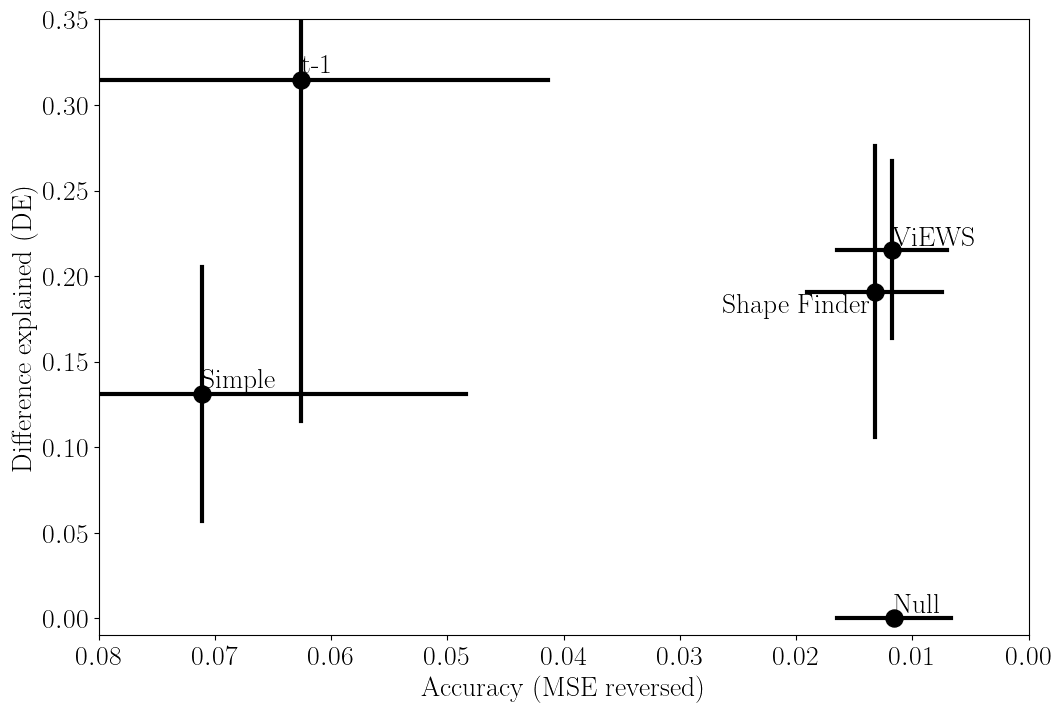

In [102]:
fig,ax = plt.subplots(figsize=(12,8))

plt.scatter(mean_mse["mean"][0],mean_de["mean"][0],color="black",s=150)
plt.scatter(mean_mse["mean"][1],mean_de["mean"][1],color="black",s=150)
plt.scatter(mean_mse["mean"][2],mean_de["mean"][2],color="black",s=150)
plt.scatter(mean_mse["mean"][3],mean_de["mean"][3],color="black",s=150)
plt.scatter(mean_mse["mean"][4],mean_de["mean"][4],color="black",s=150)

# ViEWS
plt.plot([mean_mse["mean"][0],mean_mse["mean"][0]],[mean_de["mean"][0]-mean_de["std"][0],mean_de["mean"][0]+mean_de["std"][0]],linewidth=3,color="black")
plt.plot([mean_mse["mean"][0]-mean_mse["std"][0],mean_mse["mean"][0]+mean_mse["std"][0]],[mean_de["mean"][0],mean_de["mean"][0]],linewidth=3,color="black")
plt.text(mean_mse["mean"][0], mean_de["mean"][0]+0.002, "ViEWS", size=20, color='black')

# Shape Finder
plt.plot([mean_mse["mean"][1],mean_mse["mean"][1]],[mean_de["mean"][1]-mean_de["std"][1],mean_de["mean"][1]+mean_de["std"][1]],linewidth=3,color="black")
plt.plot([mean_mse["mean"][1]-mean_mse["std"][1],mean_mse["mean"][1]+mean_mse["std"][1]],[mean_de["mean"][1],mean_de["mean"][1]],linewidth=3,color="black")
plt.text(mean_mse["mean"][1]+0.013, mean_de["mean"][1]-0.013, "Shape Finder", size=20, color='black')

# Null
plt.plot([mean_mse["mean"][2],mean_mse["mean"][2]],[mean_de["mean"][2]-mean_de["std"][2],mean_de["mean"][2]+mean_de["std"][2]],linewidth=3,color="black")
plt.plot([mean_mse["mean"][2]-mean_mse["std"][2],mean_mse["mean"][2]+mean_mse["std"][2]],[mean_de["mean"][2],mean_de["mean"][2]],linewidth=3,color="black")
plt.text(mean_mse["mean"][2], mean_de["mean"][2]+0.003, "Null", size=20, color='black')

# t-1
plt.plot([mean_mse["mean"][3],mean_mse["mean"][3]],[mean_de["mean"][3]-mean_de["std"][3],mean_de["mean"][3]+mean_de["std"][3]],linewidth=3,color="black")
plt.plot([mean_mse["mean"][3]-mean_mse["std"][3],mean_mse["mean"][3]+mean_mse["std"][3]],[mean_de["mean"][3],mean_de["mean"][3]],linewidth=3,color="black")
plt.text(mean_mse["mean"][3], mean_de["mean"][3]+0.004, "t-1", size=20, color='black')

# Simple
plt.plot([mean_mse["mean"][4],mean_mse["mean"][4]],[mean_de["mean"][4]-mean_de["std"][4],mean_de["mean"][4]+mean_de["std"][4]],linewidth=3,color="black")
plt.plot([mean_mse["mean"][4]-mean_mse["std"][4],mean_mse["mean"][4]+mean_mse["std"][4]],[mean_de["mean"][4],mean_de["mean"][4]],linewidth=3,color="black")
plt.text(mean_mse["mean"][4], mean_de["mean"][4]+0.003, "Simple", size=20, color='black')

plt.xlabel("Accuracy (MSE reversed)")
plt.ylabel("Difference explained (DE)")

#plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), fontsize=12,ncol=3)
ax.set_ylim([-0.01, 0.35])
ax.set_yticks([0, 0.05, 0.1, 0.15, 0.2, 0.25,0.3,0.35])
ax.set_xlim([0, 0.08])
ax.set_xticks([0, 0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08])
ax.invert_xaxis()
